In [1]:
# Python packages and utilities
import os
import sys
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML

try:
    import mlxtend
except ModuleNotFoundError:
    !pip install mlxtend

#RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs

# Mordred
try:
    import mordred
    from mordred import Calculator, descriptors
except ModuleNotFoundError:
    !pip install 'mordred[full]'
    import mordred
    from mordred import Calculator, descriptors
    

# scikit-learn
try:
    import sklearn
except ModuleNotFoundError:
    !pip install -U scikit-learn
    import sklearn
    
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.feature_selection import RFECV, RFE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#imbalenced learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
except ModuleNotFoundError:
    !pip install -U imbalanced-learn
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN

# seaborn
try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt

#PIL
from PIL import Image

# scikitplot library
try:
    import scikitplot as skplt
except ModuleNotFoundError:
    !pip install scikit-plot
    import scikitplot as skplt

!pip install pip install -U imbalanced-learn

# own module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from Modules import classification_metrics as cmetrics
try:
    from Modules import finger_prints as fp
except ModuleNotFoundError:
    !python -m pip install "dask[complete]"
    from Modules import finger_prints as fp
from Modules import molecules_and_images as mo
from Modules import plotting_sklearn as pltsk
from Modules import classification_workflow_functions as cwf

# utility
%load_ext autoreload
%autoreload 2
%aimport
import importlib


import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)


random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



# Load target data

In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

In [3]:
data = pd.read_csv("Second_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [4]:
log.info("Columns: {}".format(data.columns))

Columns: Index(['reaction', 'substrate', 'catalyst', 'solvent', 'solvent_code',
       'temperature', 'ee', 'ddg', 'paper'],
      dtype='object')


In [5]:
data

,reaction,substrate,catalyst,solvent,solvent_code,temperature,ee,ddg,paper
0,0,O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,0.0,0.000000,ORGLETT 2008
1,1,O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,0.0,0.000000,ORGLETT 2008
2,2,O=C1CCC(Cl)N1CCC2=CSC=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,30.0,1.426491,ORGLETT 2008
3,3,O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,15.0,0.696565,ORGLETT 2008
4,4,O=C1CCC(Cl)N1CCC2=CNC=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,60.0,3.194526,ORGLETT 2008
...,...,...,...,...,...,...,...,...,...
85,85,O=C1CCC(C)(Cl)N1CCC2=CNC3=CC=C(OC)C=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,91.0,4.957045,JACS 2007
86,86,O=C1CCCC(Cl)N1CCC2=CNC3=CC=CC=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-55.0,81.0,4.088429,JACS 2007
87,87,O=C1CCCC(C)(Cl)N1CCC2=CNC3=CC=CC=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,92.0,5.156630,JACS 2007
88,88,O=C1CCCC(CCCC)(Cl)N1CCC2=CNC3=CC=CC=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,96.0,6.314769,JACS 2007


In [6]:
substratesmiles = data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles.head()))

catalystsmiles = data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles.head()))

reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

ddg = data["ddg"]
log.info("DGG: {}".format(ddg.head()))

Substrate SMILES: 0        O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2
1    O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2
2              O=C1CCC(Cl)N1CCC2=CSC=C2
3      O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3
4              O=C1CCC(Cl)N1CCC2=CNC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
1    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
2    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
3    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
4    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
Name: catalyst, dtype: object
Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64
DGG: 0    0.000000
1    0.000000
2    1.426491
3    0.696565
4    3.194526
Name: ddg, dtype: float64


# Set Target Properties

In [7]:
targets = ddg

# Make Mordred Features

In [8]:
# Mordred for substrates

In [9]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list = [cwf.get_mol_from_smiles(s) for s in substratesmiles]
subfeatures_df = calc.pandas(submolecule_list)

100%|██████████| 90/90 [00:18<00:00,  5.00it/s]


In [10]:
subbackup_feature_df = subfeatures_df.copy()
#features_df = backup_feature_df

In [11]:
subfeatures_df.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df.index)))
threshold = 0.5
subfeatures_df.drop(subfeatures_df.std()[subfeatures_df.std() < threshold].index.values, axis=1)
subfeatures_df.columns = [ent.strip() for ent in subfeatures_df.columns]
subfeatures_df.head()

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,ABC,ABCGG,nAcid,nBase,SpAbs_A,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,12.865821,11.266795,0,0,21.826366,...,22,84.0,96.0,5.805556,3.888889
1,14.239595,12.684052,0,0,24.263559,...,27,94.0,109.0,6.916667,4.416667
2,10.744501,10.260282,0,0,17.982356,...,15,70.0,80.0,4.444444,3.138889
3,14.199155,12.457708,0,0,23.804025,...,25,96.0,114.0,5.166667,3.944444
4,10.744501,10.260282,0,0,17.982356,...,15,70.0,80.0,4.444444,3.138889


In [12]:
log.info(subfeatures_df)
subfeature_types = "some_catagorical" # other options 'some_catagorical', 'no_catagorical'

          ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  \
0   12.865821  11.266795      0      0  21.826366  ...    22     84.0   
1   14.239595  12.684052      0      0  24.263559  ...    27     94.0   
2   10.744501  10.260282      0      0  17.982356  ...    15     70.0   
3   14.199155  12.457708      0      0  23.804025  ...    25     96.0   
4   10.744501  10.260282      0      0  17.982356  ...    15     70.0   
..        ...        ...    ...    ...        ...  ...   ...      ...   
85  16.507753  14.449726      0      0  26.915709  ...    32    114.0   
86  14.906262  12.447004      0      0  24.908084  ...    28    100.0   
87  15.800646  13.284771      0      0  25.538663  ...    31    108.0   
88  17.763048  14.857121      0      0  29.788121  ...    36    120.0   
89  15.093540  13.289946      0      0  24.480946  ...    28    104.0   

    Zagreb2  mZagreb1  mZagreb2  
0      96.0  5.805556  3.888889  
1     109.0  6.916667  4.416667  
2      80.0  4.444444

In [13]:
# Mordred for catalysts

In [14]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list = [cwf.get_mol_from_smiles(s) for s in catalystsmiles]
catfeatures_df = calc.pandas(catmolecule_list)

100%|██████████| 90/90 [00:36<00:00,  2.47it/s]


In [15]:
catbackup_feature_df = catfeatures_df.copy()

In [16]:
catfeatures_df.dropna(inplace=True, thresh=int(0.9*len(catfeatures_df.index)))
threshold = 0.5
catfeatures_df.drop(catfeatures_df.std()[catfeatures_df.std() < threshold].index.values, axis=1)
catfeatures_df.columns = [ent.strip() for ent in catfeatures_df.columns]
catfeatures_df.head()

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,ABC,ABCGG,nAcid,nBase,SpAbs_A,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,27.439682,23.068997,0,0,44.916702,...,56,182.0,211.0,13.423611,8.027778
1,27.439682,23.068997,0,0,44.916702,...,56,182.0,211.0,13.423611,8.027778
2,27.439682,23.068997,0,0,44.916702,...,56,182.0,211.0,13.423611,8.027778
3,27.439682,23.068997,0,0,44.916702,...,56,182.0,211.0,13.423611,8.027778
4,27.439682,23.068997,0,0,44.916702,...,56,182.0,211.0,13.423611,8.027778


In [17]:
log.info(catfeatures_df)
catfeature_types = "some_catagorical" 

          ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  \
0   27.439682  23.068997      0      0  44.916702  ...    56    182.0   
1   27.439682  23.068997      0      0  44.916702  ...    56    182.0   
2   27.439682  23.068997      0      0  44.916702  ...    56    182.0   
3   27.439682  23.068997      0      0  44.916702  ...    56    182.0   
4   27.439682  23.068997      0      0  44.916702  ...    56    182.0   
..        ...        ...    ...    ...        ...  ...   ...      ...   
85  27.439682  23.068997      0      0  44.916702  ...    56    182.0   
86  27.439682  23.068997      0      0  44.916702  ...    56    182.0   
87  27.439682  23.068997      0      0  44.916702  ...    56    182.0   
88  27.439682  23.068997      0      0  44.916702  ...    56    182.0   
89  27.439682  23.068997      0      0  44.916702  ...    56    182.0   

    Zagreb2   mZagreb1  mZagreb2  
0     211.0  13.423611  8.027778  
1     211.0  13.423611  8.027778  
2     211.0  13.42

# Pearson correlation coefficent and Spearman's rank correlation coefficient
In the next cells we can investigate how well each bit correlates against our property of interest and checks for signficance using a one tail permutation test: how many times out of the n_sample do I obtain a correlation coefficient that is greater than the observed value.

In the next block the feature with a reasonable correlation and statistically significant are chosen. The `sig_metric` is the significance testing metric correlation coefficent names are two tail p tests. to do one tail enter replacing option with `gt` for greater than and `lt` for less than and the correction coefficent name one of `pearsron`, `spearman` or `kendalltau`, `onetail_$option_$correlation_coefficent`.

In [32]:
subreasonable_predicted_properties, subsignificant_fearures = cwf.find_correlating_features(subfeatures_df, targets, thresh=0.38, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0     0.000000
1     0.000000
2     1.426491
3     0.696565
4     3.194526
        ...   
85    4.957045
86    4.088429
87    5.156630
88    6.314769
89    4.464572
Name: ddg, Length: 90, dtype: float64
Significance will be calculated for the correlations
SpMax_A: 0.3876 P: 0.0004 Significant at 0.0500 level? True
ATS0s: 0.4182 P: 0.0004 Significant at 0.0500 level? True
ATS2s: 0.3840 P: 0.0004 Significant at 0.0500 level? True
ATSC8se: -0.4105 P: 0.0002 Significant at 0.0500 level? True
AATSC1pe: -0.3965 P: 0.0002 Significant at 0.0500 level? True
AATSC1are: -0.3853 P: 0.0004 Significant at 0.0500 level? True
VR2_Dzse: 0.3804 P: 0.0004 Significant at 0.0500 level? True
VR2_Dzpe: 0.3802 P: 0.0004 Significant at 0.0500 level? True
VR2_Dzare: 0.3803 P: 0.0004 Significant at 0.0500 level? True
AXp-3d: -0.4070 P: 0.0002 Significant at 0.0500 level? True
AXp-5d: -0.4042 P: 0.0002 Significant at 0.0500 level? True
AXp-6d: -0.4009 P: 0.0002 Significant at 0.0500 level? True
AXp-7d: -0.4183 P:

In [33]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_fearures, len(subsignificant_fearures)))
use_significant = True
use_reasonable = False

['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are', 'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d', 'AXp-5d', 'AXp-6d', 'AXp-7d', 'TIC1', 'FilterItLogS', 'MID_N', 'MPC2', 'MPC4', 'MPC6', 'TMPC10', 'GGI6', 'MWC02', 'MWC03', 'MWC04', 'MWC05', 'MWC06', 'MWC07', 'MWC08', 'MWC09', 'MWC10', 'SRW04', 'SRW06', 'SRW08', 'SRW10', 'TSRW10'] 35
['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are', 'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d', 'AXp-5d', 'AXp-6d', 'AXp-7d', 'TIC1', 'FilterItLogS', 'MID_N', 'MPC2', 'MPC4', 'MPC6', 'TMPC10', 'GGI6', 'MWC02', 'MWC03', 'MWC04', 'MWC05', 'MWC06', 'MWC07', 'MWC08', 'MWC09', 'MWC10', 'SRW04', 'SRW06', 'SRW08', 'SRW10', 'TSRW10'] 35


In [34]:
catreasonable_predicted_properties, catsignificant_fearures = cwf.find_correlating_features(catfeatures_df, targets, thresh=0.49, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0     0.000000
1     0.000000
2     1.426491
3     0.696565
4     3.194526
        ...   
85    4.957045
86    4.088429
87    5.156630
88    6.314769
89    4.464572
Name: ddg, Length: 90, dtype: float64
Significance will be calculated for the correlations
AATS7s: -0.4934 P: 0.0002 Significant at 0.0500 level? True
AATS7se: -0.4962 P: 0.0002 Significant at 0.0500 level? True
AATS7pe: -0.5249 P: 0.0002 Significant at 0.0500 level? True
AATS7are: -0.5153 P: 0.0002 Significant at 0.0500 level? True
AATSC0d: -0.5154 P: 0.0002 Significant at 0.0500 level? True
AATSC2d: 0.4946 P: 0.0002 Significant at 0.0500 level? True
AATSC3v: 0.4905 P: 0.0002 Significant at 0.0500 level? True
AATSC3p: 0.4906 P: 0.0002 Significant at 0.0500 level? True
MATS8c: 0.4964 P: 0.0002 Significant at 0.0500 level? True
MATS1s: 0.4917 P: 0.0002 Significant at 0.0500 level? True
GATS2c: 0.5127 P: 0.0002 Significant at 0.0500 level? True
GATS4dv: 0.5051 P: 0.0002 Significant at 0.0500 level? True
GATS4d: 0.5401 P: 0.00

In [35]:
log.info("{} {}".format(catreasonable_predicted_properties, len(catreasonable_predicted_properties)))
log.info("{} {}".format(catsignificant_fearures, len(catsignificant_fearures)))
use_significant = True
use_reasonable = False

['AATS7s', 'AATS7se', 'AATS7pe', 'AATS7are', 'AATSC0d', 'AATSC2d', 'AATSC3v', 'AATSC3p', 'MATS8c', 'MATS1s', 'GATS2c', 'GATS4dv', 'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'NssssC', 'ETA_shape_x', 'ZMIC3', 'ZMIC4', 'SlogP_VSA3', 'JGI5'] 22
['AATS7s', 'AATS7se', 'AATS7pe', 'AATS7are', 'AATSC0d', 'AATSC2d', 'AATSC3v', 'AATSC3p', 'MATS8c', 'MATS1s', 'GATS2c', 'GATS4dv', 'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'NssssC', 'ETA_shape_x', 'ZMIC3', 'ZMIC4', 'SlogP_VSA3', 'JGI5'] 22


In [36]:
subfeats_df = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_fearures:
        subfeats_df[k] = subfeatures_df[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df[k] = subfeatures_df[k]

In [37]:
catfeats_df = pd.DataFrame()

if use_significant is True:
    for k in catsignificant_fearures:
        catfeats_df[k] = catfeatures_df[k]
        
elif use_reasonable is True:
    for k in catreasonable_predicted_properties:
        catfeats_df[k] = catfeatures_df[k]

In [38]:
features_df = subfeats_df.join(catfeats_df, lsuffix="subfeats_df", rsuffix="catfeats_df")

In [39]:
features_df

,SpMax_A,ATS0s,ATS2s,ATSC8se,AATSC1pe,AATSC1are,VR2_Dzse,VR2_Dzpe,VR2_Dzare,AXp-3d,AXp-5d,AXp-6d,AXp-7d,TIC1,FilterItLogS,MID_N,MPC2,MPC4,MPC6,TMPC10,GGI6,...,AATS7se,AATS7pe,AATS7are,AATSC0d,AATSC2d,AATSC3v,AATSC3p,MATS8c,MATS1s,GATS2c,GATS4dv,GATS4d,Xc-3d,Xc-4d,Xc-6d,NssssC,ETA_shape_x,ZMIC3,ZMIC4,SlogP_VSA3,JGI5
0,2.338919,122.171963,158.944444,-0.094886,0.004733,0.003721,4.636227,4.636651,4.637568,0.199703,0.086401,0.058955,0.039421,105.445456,-3.453405,2.188644,24,34,32,318,0.232744,...,7.209765,5.616365,5.533711,0.566924,0.004526,-4.492273,-0.022431,0.10354,-0.045652,1.252388,1.280093,1.20245,3.153016,0.288675,0.117851,1,0.028143,29.604637,27.803492,4.794537,0.020476
1,2.353478,139.199741,182.222222,1.339931,0.005089,0.003393,4.910514,4.909946,4.908520,0.192703,0.085092,0.055922,0.036628,116.636641,-3.723991,2.189560,27,41,39,389,0.232744,...,7.209765,5.616365,5.533711,0.566924,0.004526,-4.492273,-0.022431,0.10354,-0.045652,1.252388,1.280093,1.20245,3.153016,0.288675,0.117851,1,0.028143,29.604637,27.803492,4.794537,0.020476
2,2.336958,95.564281,114.450617,-0.125538,0.003397,0.002877,4.217824,4.221473,4.227801,0.196886,0.088258,0.056718,0.037991,84.927220,-2.749070,2.185365,20,29,22,224,0.163265,...,7.209765,5.616365,5.533711,0.566924,0.004526,-4.492273,-0.022431,0.10354,-0.045652,1.252388,1.280093,1.20245,3.153016,0.288675,0.117851,1,0.028143,29.604637,27.803492,4.794537,0.020476
3,2.410734,111.119837,146.827160,-0.286498,0.003150,0.002663,4.961369,4.962518,4.966273,0.181357,0.080059,0.051065,0.033416,109.861035,-4.111971,2.191332,28,48,48,473,0.305306,...,7.209765,5.616365,5.533711,0.566924,0.004526,-4.492273,-0.022431,0.10354,-0.045652,1.252388,1.280093,1.20245,3.153016,0.288675,0.117851,1,0.028143,29.604637,27.803492,4.794537,0.020476
4,2.336958,102.394185,128.944444,-0.523547,-0.000548,-0.001694,4.216448,4.218443,4.223536,0.196886,0.088258,0.056718,0.037991,91.097750,-2.689619,4.173041,20,29,22,224,0.163265,...,7.209765,5.616365,5.533711,0.566924,0.004526,-4.492273,-0.022431,0.10354,-0.045652,1.252388,1.280093,1.20245,3.153016,0.288675,0.117851,1,0.028143,29.604637,27.803492,4.794537,0.020476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2.451224,140.762241,198.206790,-0.544659,0.001801,0.000430,5.358114,5.358426,5.359029,0.178465,0.075169,0.049000,0.031764,144.819267,-4.927323,4.249134,34,57,64,614,0.468571,...,7.209765,5.616365,5.533711,0.566924,0.004526,-4.492273,-0.022431,0.10354,-0.045652,1.252388,1.280093,1.20245,3.153016,0.288675,0.117851,1,0.028143,29.604637,27.803492,4.794537,0.020476
86,2.407056,122.199741,171.472222,-0.654779,0.000947,0.000164,5.070042,5.071402,5.075127,0.182901,0.078487,0.053263,0.033660,124.453912,-4.333140,4.259281,29,49,53,498,0.306122,...,7.209765,5.616365,5.533711,0.566924,0.004526,-4.492273,-0.022431,0.10354,-0.045652,1.252388,1.280093,1.20245,3.153016,0.288675,0.117851,1,0.028143,29.604637,27.803492,4.794537,0.020476
87,2.427288,127.984463,182.512346,-0.821033,0.001486,0.000769,5.194946,5.196764,5.200784,0.178603,0.076036,0.052174,0.032574,134.415330,-4.934313,4.253513,32,53,58,539,0.413832,...,7.209765,5.616365,5.533711,0.566924,0.004526,-4.492273,-0.022431,0.10354,-0.045652,1.252388,1.280093,1.20245,3.153016,0.288675,0.117851,1,0.028143,29.604637,27.803492,4.794537,0.020476
88,2.441920,140.734463,209.464506,-0.778701,0.002373,0.001798,5.594552,5.597553,5.602077,0.179169,0.077336,0.051446,0.033118,154.148296,-6.126950,4.281332,35,60,68,633,0.515057,...,7.209765,5.616365,5.533711,0.566924,0.004526,-4.492273,-0.022431,0.10354,-0.045652,1.252388,1.280093,1.20245,3.153016,0.288675,0.117851,1,0.028143,29.604637,27.803492,4.794537,0.020476


# Classify Molecules
Use these two next cells to classify the amines into 'good' and 'bad' in terms of capacity. To visualize all of these structure set show to True.

In [40]:
classes=[]
for index, value in ddg.items():
    if value < 4:
        classes.append(0)
    else:
        classes.append(1)

In [41]:
classes
class_targets_df = pd.DataFrame(np.array([classes]).T, columns=["classes"])
features_and_classes_df = features_df.copy()
features_and_classes_df["classes"] = classes

# Feature exploration
In the section I explore the features and their relationships. 
Use these two next cells to classify the amines into 'good' and 'bad' in terms of capacity. To visualize all of these structure set show to True.

In [42]:
# features_df

In [43]:
pd.set_option('display.max_columns', len(features_df.columns))
features_df.describe()

,SpMax_A,ATS0s,ATS2s,ATSC8se,AATSC1pe,AATSC1are,VR2_Dzse,VR2_Dzpe,VR2_Dzare,AXp-3d,AXp-5d,AXp-6d,AXp-7d,TIC1,FilterItLogS,MID_N,MPC2,MPC4,MPC6,TMPC10,GGI6,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,SRW04,SRW06,SRW08,SRW10,TSRW10,AATS7s,AATS7se,AATS7pe,AATS7are,AATSC0d,AATSC2d,AATSC3v,AATSC3p,MATS8c,MATS1s,GATS2c,GATS4dv,GATS4d,Xc-3d,Xc-4d,Xc-6d,NssssC,ETA_shape_x,ZMIC3,ZMIC4,SlogP_VSA3,JGI5
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,2.422912,124.906435,171.290324,-0.669303,0.000109,-0.000865,5.050127,5.051731,5.055777,0.181163,0.079285,0.051034,0.033492,123.137904,-4.259659,4.167023,29.411111,49.644444,49.455556,482.466667,0.325118,4.608935,5.466357,6.345651,7.216280,8.099207,8.973815,9.857872,10.734386,11.618909,5.065858,6.577520,8.174340,9.815904,68.059782,1.911832,7.246532,5.667891,5.582752,0.589744,-0.006061,-5.978468,-0.030023,0.088581,-0.057090,1.195499,1.243105,1.163150,3.602535,0.350120,0.145447,1.200000,0.033240,32.647835,30.721888,6.753372,0.022017
std,0.037605,17.029727,25.095422,0.286270,0.001783,0.002051,0.356661,0.357462,0.358206,0.005777,0.003246,0.002236,0.001448,19.474441,0.668427,0.432769,4.829438,9.233928,10.479687,99.513558,0.070972,0.139672,0.150787,0.165871,0.178007,0.193337,0.205751,0.221110,0.233685,0.249075,0.143411,0.167819,0.197884,0.230718,3.740769,0.257171,0.091026,0.105613,0.104962,0.051636,0.029338,3.204228,0.017686,0.037776,0.027695,0.122034,0.089235,0.096213,0.961978,0.183270,0.089157,0.621705,0.017190,5.136081,5.034155,5.148141,0.003767
min,2.336958,95.564281,114.450617,-1.362240,-0.004961,-0.007113,4.216448,4.218443,4.223536,0.165452,0.070111,0.044733,0.030467,84.927220,-6.415913,2.185365,20.000000,29.000000,22.000000,224.000000,0.163265,4.262680,5.081404,5.921578,6.753438,7.597396,8.433594,9.279027,10.117510,10.963757,4.709530,6.150603,7.666222,9.224342,60.747309,1.667279,7.177717,5.560068,5.480860,0.513158,-0.110055,-17.120733,-0.103001,-0.093230,-0.203000,0.584181,0.794663,0.741670,1.927825,0.000000,0.000000,0.000000,0.000000,27.181540,25.298781,4.794537,0.018805
25%,2.410734,117.949741,162.222222,-0.672010,0.000203,-0.000662,4.961344,4.962409,4.966110,0.181357,0.078780,0.051065,0.033416,116.326040,-4.327318,4.246913,28.000000,48.000000,48.000000,473.000000,0.305306,4.574711,5.433722,6.308098,7.178545,8.056110,8.929700,9.808132,10.683111,11.561839,5.030438,6.535241,8.122371,9.752141,67.100439,1.818891,7.209765,5.616365,5.533711,0.566924,-0.003496,-7.253694,-0.034317,0.087570,-0.061115,1.209503,1.232269,1.165749,3.153016,0.288675,0.117851,1.000000,0.027372,29.604637,27.803492,4.794537,0.020476
50%,2.410734,117.949741,162.222222,-0.672010,0.000203,-0.000662,4.961344,4.962409,4.966110,0.181357,0.080059,0.051065,0.033416,116.326040,-4.058288,4.246913,28.000000,48.000000,48.000000,473.000000,0.305306,4.574711,5.433722,6.308098,7.178545,8.056110,8.929700,9.808132,10.683111,11.561839,5.030438,6.535241,8.122371,9.752141,67.100439,1.818891,7.209765,5.616911,5.533711,0.566924,0.004526,-4.492273,-0.022431,0.103540,-0.045652,1.252388,1.280093,1.202450,3.153016,0.288675,0.117851,1.000000,0.028143,29.701711,27.803492,4.794537,0.020476
75%,2.426398,122.597310,171.493056,-0.672010,0.000203,-0.000662,5.048328,5.050227,5.054292,0.181357,0.080059,0.051065,0.033416,123.180793,-4.058288,4.246913,28.750000,48.750000,50.250000,491.750000,0.305918,4.605018,5.459476,6.329644,7.195515,8.069781,8.938977,9.814704,10.685480,11.565359,5.059288,6.569290,8.168560,9.815148,67.100439,

The next cell shows counts of for each sub-structure bit how many with and how many without that sub-structure are in each class

In [30]:
for ith, cat_feat in enumerate(features_df.columns):
    log.info("{} {}".format(cat_feat, ith))
    log.info("\n{}\n".format(pd.crosstab(features_df[cat_feat], class_targets_df["classes"])))

ATS0s 0

classes     0  1
ATS0s           
95.564281   1  0
102.394185  2  0
108.178908  0  1
111.119837  1  0
112.428908  1  0
...        .. ..
168.101871  0  1
169.379649  0  1
172.351871  0  1
176.129649  0  1
179.727519  0  2

[34 rows x 2 columns]

ATSC8se 1

classes    0  1
ATSC8se        
-1.362240  0  1
-1.358702  0  1
-1.229953  0  1
-1.223404  0  1
-1.121572  0  1
...       .. ..
-0.349716  0  1
-0.286498  1  0
-0.125538  1  0
-0.094886  1  0
 1.339931  1  0

[35 rows x 2 columns]

AATSC1pe 2

classes    0  1
AATSC1pe       
-0.004961  1  0
-0.004698  0  1
-0.004462  0  1
-0.004165  0  1
-0.004054  0  1
...       .. ..
 0.002466  1  0
 0.003150  1  0
 0.003397  1  0
 0.004733  1  0
 0.005089  1  0

[32 rows x 2 columns]

AXp-3d 3

classes   0  1
AXp-3d        
0.165452  0  1
0.166829  0  1
0.167943  0  1
0.168165  0  1
0.169191  0  1
...      .. ..
0.189751  1  0
0.190755  1  0
0.192703  1  0
0.196886  3  0
0.199703  1  0

[31 rows x 2 columns]

AXp-5d 4

classes   0  1
AXp-5

Xc-6d 35

classes    0   1
Xc-6d           
0.000000   0   1
0.117851  23  55
0.214076   2   0
0.219913   1   0
0.284518   1   0
...       ..  ..
0.380040   2   0
0.406526   1   0
0.439826   1   0
0.492799   1   0
0.577350   1   0

[11 rows x 2 columns]

NssssC 36

classes   0   1
NssssC         
0         0   1
1        23  55
2         4   0
3         6   0
4         1   0

ETA_shape_x 37

classes      0  1
ETA_shape_x      
0.000000     0  1
0.022971     1  0
0.023511     1  0
0.024077     1  1
0.024671     2  0
...         .. ..
0.077855     1  0
0.085662     1  0
0.089686     1  0
0.096271     1  0
0.104063     1  0

[35 rows x 2 columns]

ZMIC3 38

classes    0  1
ZMIC3          
27.181540  0  1
28.966618  0  1
29.059976  0  2
29.107191  0  1
29.472399  0  1
...       .. ..
44.063669  1  0
45.447986  1  0
45.702899  1  0
47.448600  1  0
57.607111  1  0

[45 rows x 2 columns]

ZMIC4 39

classes    0  1
ZMIC4          
25.298781  0  1
27.609346  0  1
27.618547  0  1
27.631443  0  1

The next cell show this data visually xaxis 0, 1 is is the group present or absent. Colour bars are with in the the group being present or not present do the molecules fall in to the 'bad' (0 catagory) or 'good' (1 cat).

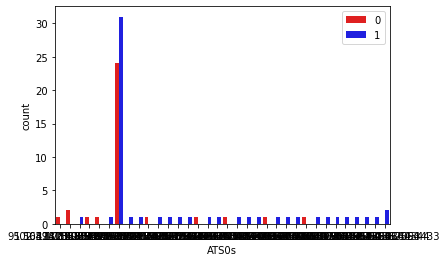

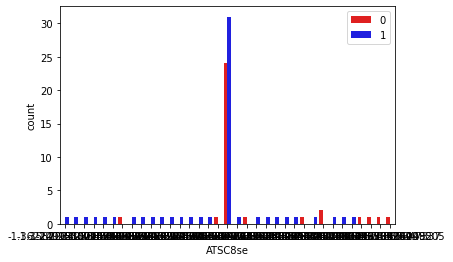

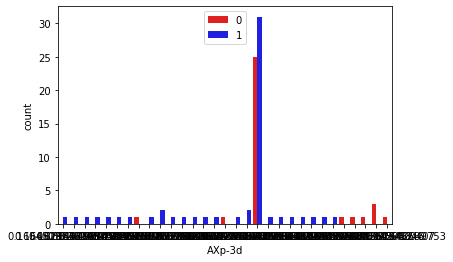

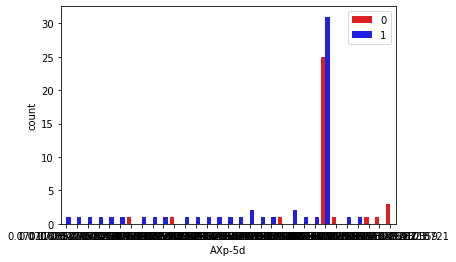

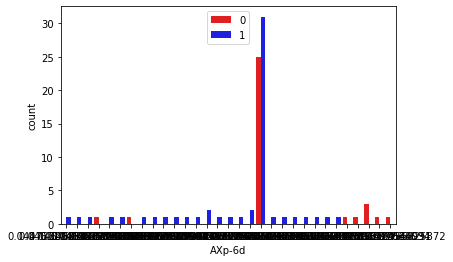

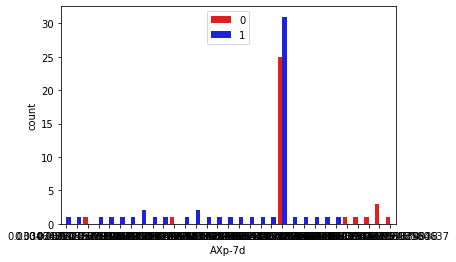

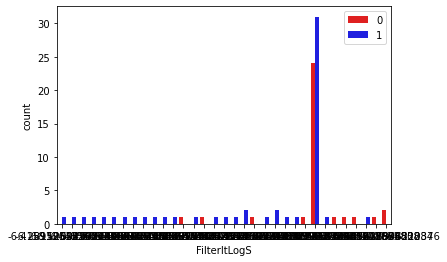

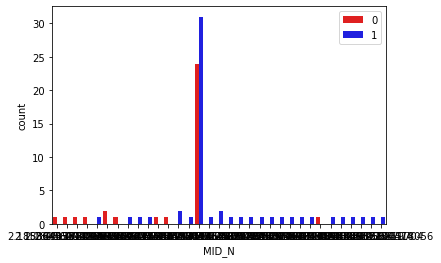

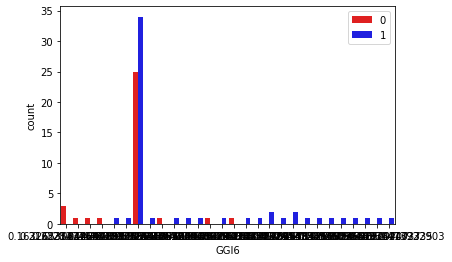

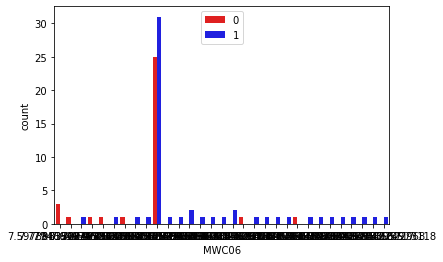

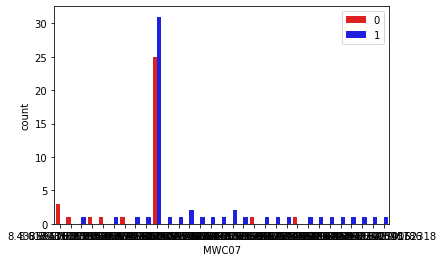

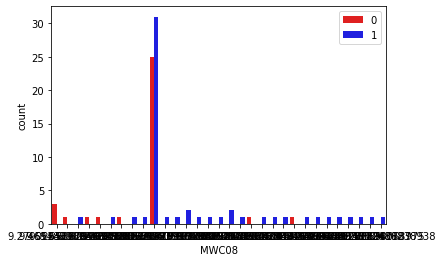

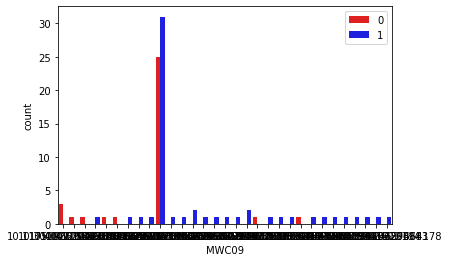

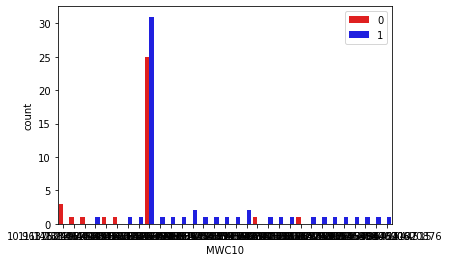

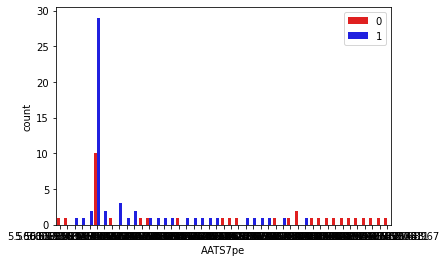

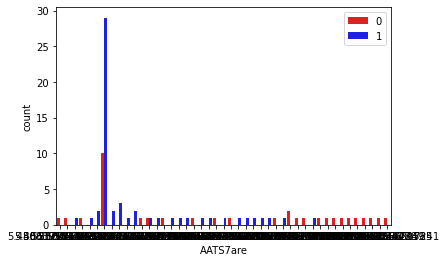

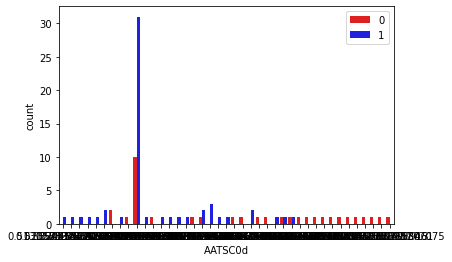

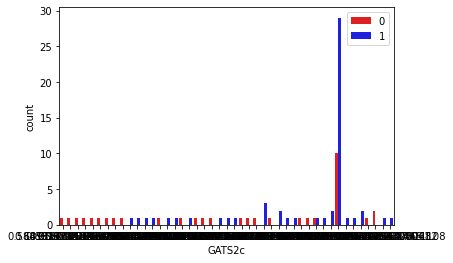

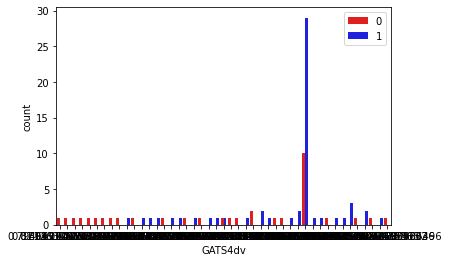

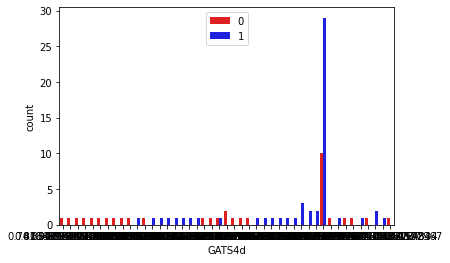

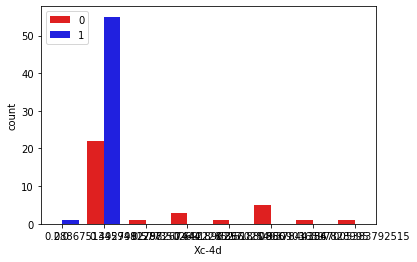

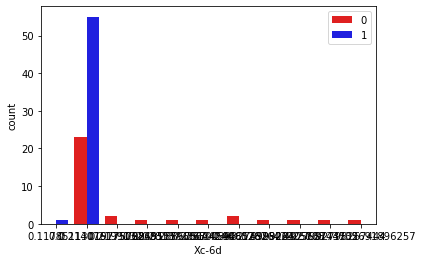

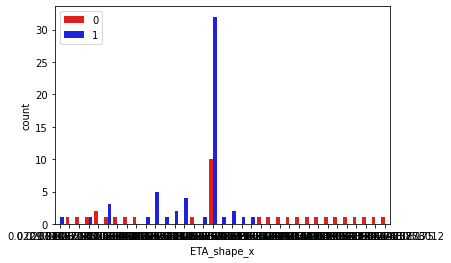

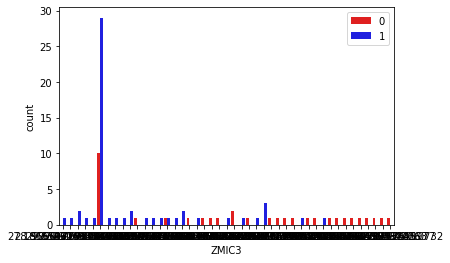

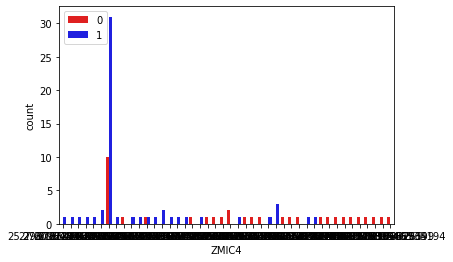

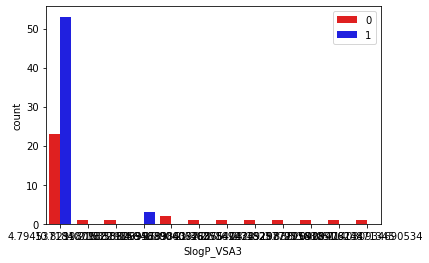

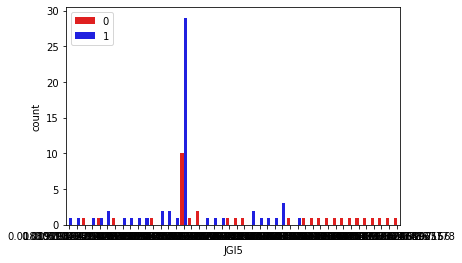

In [70]:
for cat_feat in features_df.columns:
    plt.figure()
    sns.countplot(data=features_df, x=cat_feat, hue=class_targets_df["classes"].values, palette = ['red', "blue"])
    plt.savefig("{}.png".format(cat_feat))
    plt.show()

The next cell is more geared for continuous data but shows the break down of the molecules in each class into bins of not haveing a sub-structure (0 x-axis) and having a sub-structure (1 x-axis).

Over all classes


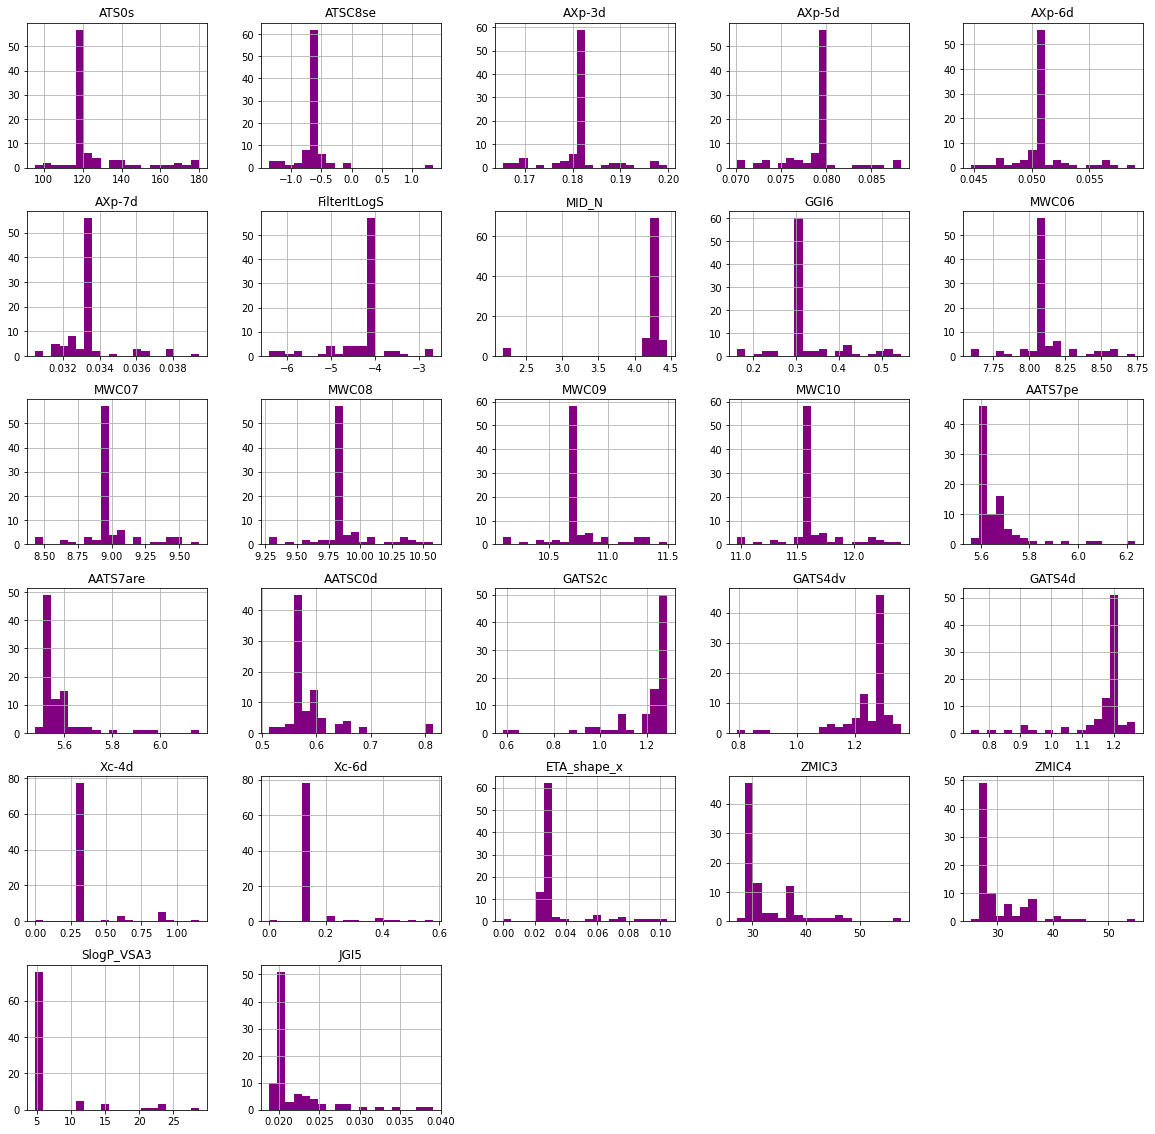

Class 0 only


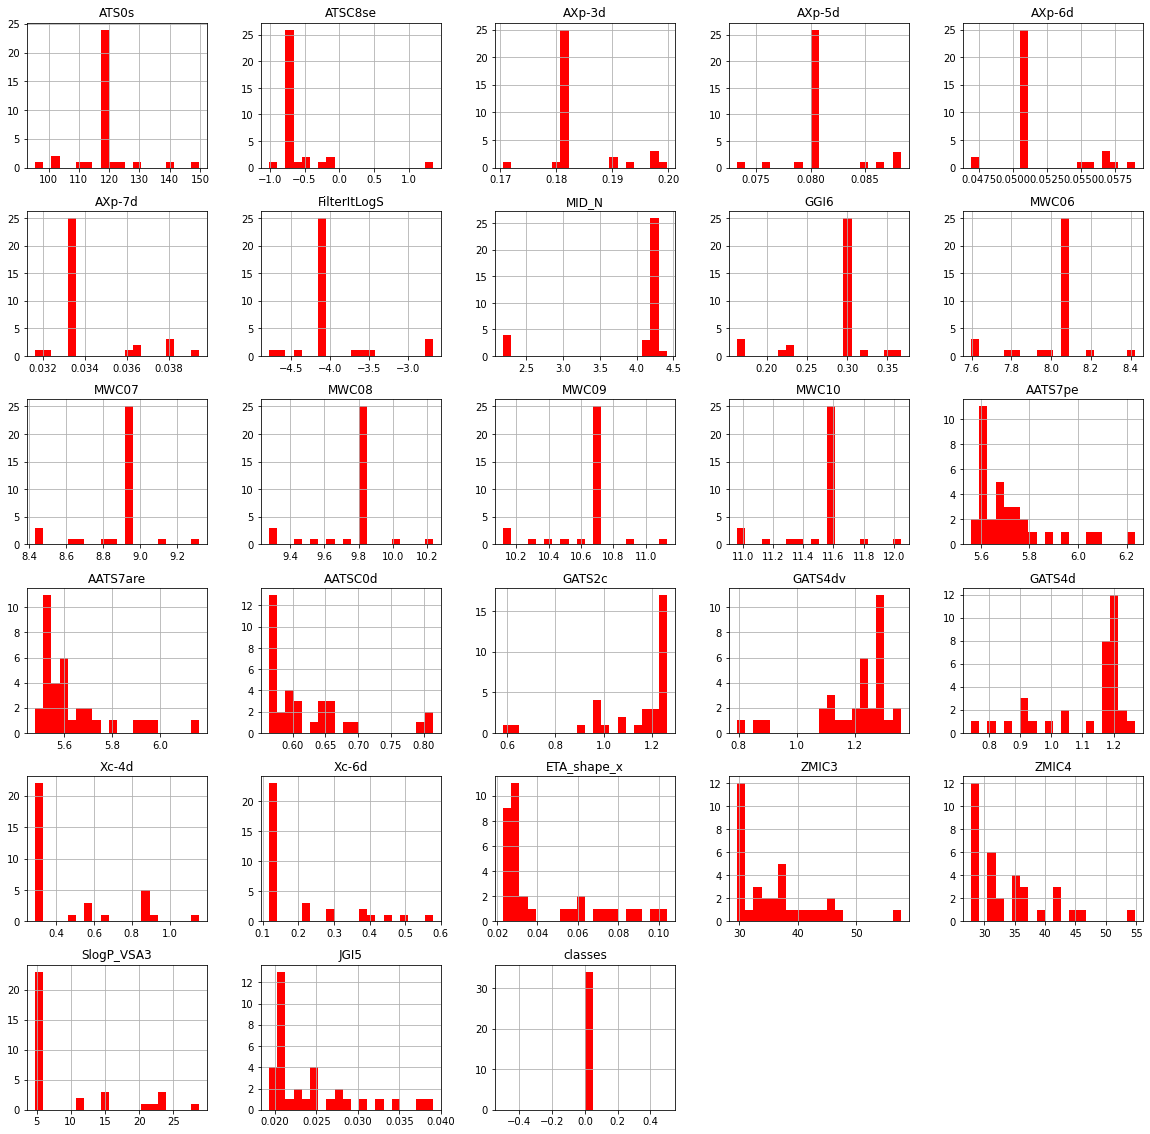

Class 1 only


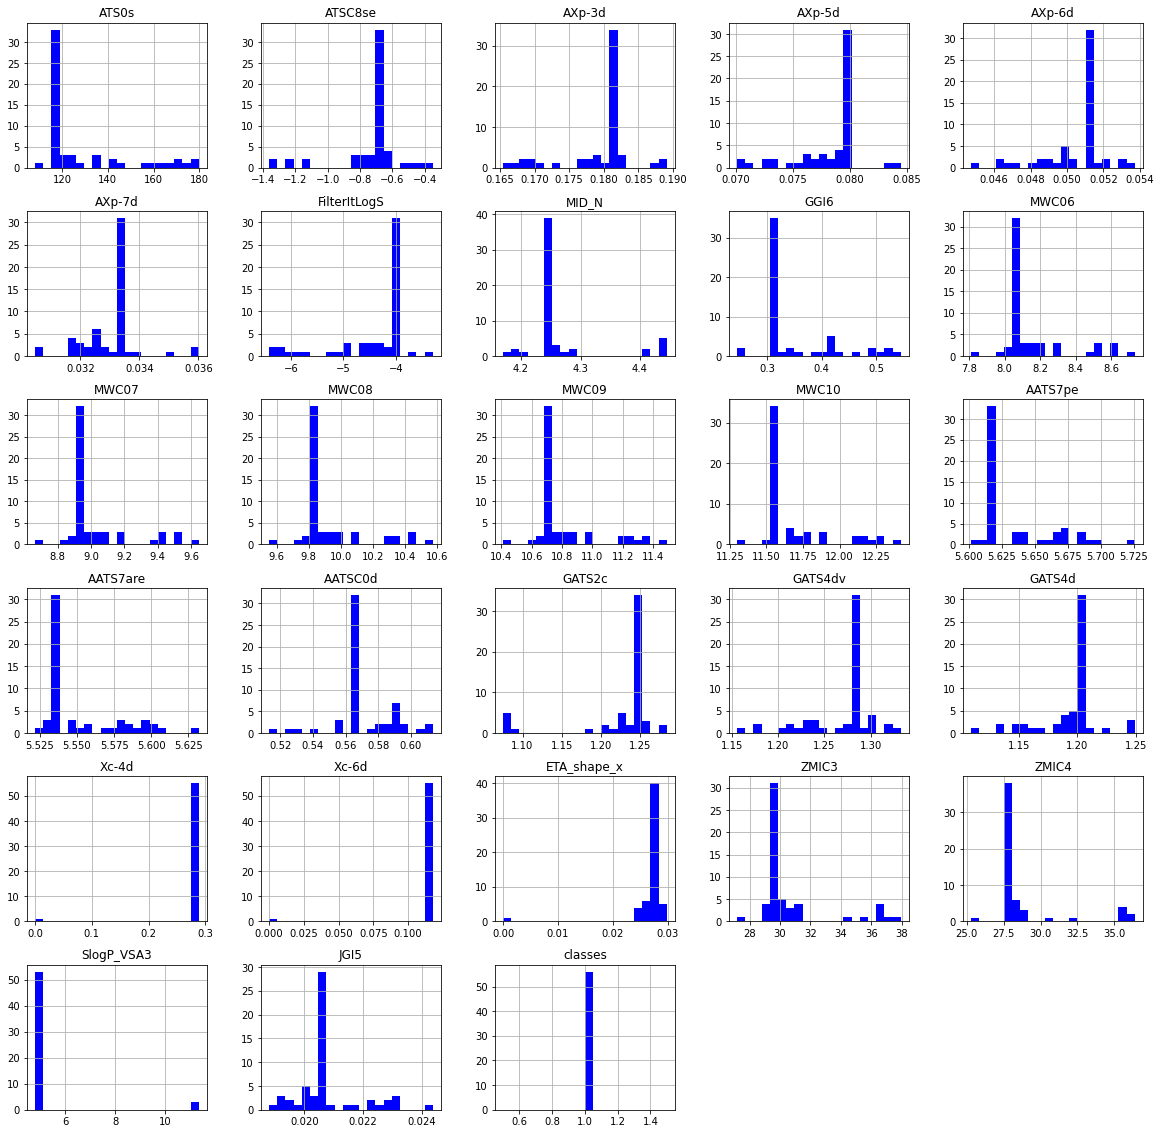

In [71]:
log.info("Over all classes")
features_df.hist(bins=20, figsize=(20,20), color="purple")
plt.savefig("features_all_classes.png")
plt.show()

log.info("Class 0 only")
features_and_classes_df[features_and_classes_df["classes"]==0].hist(bins=20, figsize=(20,20), color="red")
plt.savefig("features_class_0.png")
plt.show()

log.info("Class 1 only")
features_and_classes_df[features_and_classes_df["classes"]==1].hist(bins=20, figsize=(20,20), color="blue")
plt.savefig("features_class_1.png")
plt.show()

In [44]:
class_targets_df["classes"].values

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

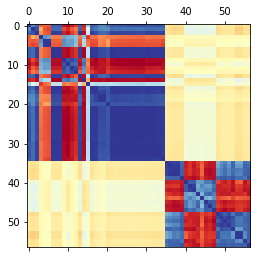

In [45]:
plt.matshow(features_df.iloc[:,:].corr(method="pearson"), cmap=plt.cm.RdYlBu)
plt.show()

Using this plot we can see that the two classes overlap considerably when considering the features which most stringly correlate with mass capacity. Looking firstly along the diagonal we want to identify the features where the distrbutions do not perfectly overlap as this suggestion there is some separation of the classes possible using this feature. We can also conside those whose distrbutions do match in terms of trends. For example if one class shows bimodality and the other unimodality then there is another possible boundary via this feature.

Looking at those not along the diagonals we can start to see combinations of features which push the classes to be more or less separated. In most cases the scatter plots overlap considerably between the two classes. In this case we want to identify the combinations which show clustering of classes as there is a better chance of an informative decision boundary being found around these tighter clusters in a latent space.


In [46]:
features_df.to_csv("features.csv")

# Classification
In this section we test out a range of classification models.

## Data scaling

In [47]:
feature_types = 'some_catagorical'

In [49]:
# feature_types = "some_catagorical"
# NOTE: USER DEFINES THE LIST BELOW!!!!!! here is with 0.4 for subs and 0.6 for cats no categorical-spearman
# for 0.36 sub and o.55 cats -spearman
# catagorical_indxs = [23, 25, 48, 49, 50]
# for pearson with 0.36 sub and o.55 cats 
catagorical_indxs = [16,17, 18 ,19, 51]
feature_columns = features_df.columns

# Backup
backup_feats_df = features_df.copy()

# None catagorical only scale the data as numbers
if feature_types == "no_catagorical":
    mm_scaler = MinMaxScaler()
    features_df = mm_scaler.fit_transform(features_df)
    log.info(pd.DataFrame(features_df, columns=feature_columns))
    features_df = pd.DataFrame(features_df, columns=feature_columns)
    
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    numeric_features = [feature_columns[i] for i in range(len(feature_columns)) if i not in catagorical_indxs]
    numerical_transformer = MinMaxScaler()
    categorical_features = [feature_columns[i] for i in range(len(feature_columns)) if i in catagorical_indxs]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    if any(ent in categorical_features for ent in numeric_features):
        log.warning("WARNING - numeric and catagorical feature specififed overlap")
        log.info(numeric_features)
        log.info(categorical_features)
    else:
        log.info("Numerical features:\n{} {}".format(numeric_features, len(numeric_features)))
        log.info("Catagorical features:\n{} {}".format(categorical_features, len(catagorical_indxs)))
    
    preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numeric_features),
        ('catagorical', categorical_transformer, categorical_features)])
    
    features_df = preprocessor.fit_transform(features_df)
    feature_names = cwf.get_feature_names_from_column_transformers(preprocessor)
    catagorical_indxs = [i for i in range(len(numeric_features), len(feature_names))]
    log.info(feature_names)

    log.info(pd.DataFrame(features_df, columns=feature_names))
    features_df = pd.DataFrame(features_df, columns=feature_names)
    log.info("catagorical indexes {}".format(catagorical_indxs))
    log.info("Catagorical features start on column name {} and end on {}".format(features_df.columns[catagorical_indxs[0]], features_df.columns[catagorical_indxs[-1]]))
    
# All catagorical
elif feature_types == "catagorical":
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    features_df = categorical_transformer.fit_transform(features_df).toarray()
    feature_names = [categorical_transformer.get_feature_names(feature_columns)]
    features_df = pd.DataFrame(features_df, columns=feature_names)
    log.info(features_df)

# No scaling or other encoding
else:
    log.info("No scaling")

Numerical features:
['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are', 'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d', 'AXp-5d', 'AXp-6d', 'AXp-7d', 'TIC1', 'FilterItLogS', 'MID_N', 'GGI6', 'MWC02', 'MWC03', 'MWC04', 'MWC05', 'MWC06', 'MWC07', 'MWC08', 'MWC09', 'MWC10', 'SRW04', 'SRW06', 'SRW08', 'SRW10', 'TSRW10', 'AATS7s', 'AATS7se', 'AATS7pe', 'AATS7are', 'AATSC0d', 'AATSC2d', 'AATSC3v', 'AATSC3p', 'MATS8c', 'MATS1s', 'GATS2c', 'GATS4dv', 'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'ETA_shape_x', 'ZMIC3', 'ZMIC4', 'SlogP_VSA3', 'JGI5'] 52
Catagorical features:
['MPC2', 'MPC4', 'MPC6', 'TMPC10', 'NssssC'] 5

-----
Getting feature names from column transformer
-----

Transformer index: 0
Tranformer name: numerical
Transformer: MinMaxScaler()
Original feature names: ['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are', 'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d', 'AXp-5d', 'AXp-6d', 'AXp-7d', 'TIC1', 'FilterItLogS', 'MID_N', 'GGI6', 'MWC02', 'MWC03', 'MWC04', 'MWC0

catagorical indexes [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153]
Catagorical features start on column name MPC2_20 and end on NssssC_4


## Using synthetic data sampling

In this section I investigate the use of synthetic sampling methods, i.e. generate additional sampling points for the minority class or undersample the majority class. Both of these techniques look to provide a better balence between the classes and hence improve the learning of a decision boundary. SMOTE https://arxiv.org/pdf/1106.1813.pdf.


In [50]:
nneighbours = min(5, len(class_targets_df[class_targets_df["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No catagorical
if feature_types == "no_catagorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=catagorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All catagorical
elif feature_types == "catagorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


Check that there are only features in the feature dataframe and classes in the classes dataframe.

In [51]:
log.info("Feature decriptions:\n{}".format(features_df.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df.columns.values))

Feature decriptions:
['SpMax_A' 'ATS0s' 'ATS2s' 'ATSC8se' 'AATSC1pe' 'AATSC1are' 'VR2_Dzse'
 'VR2_Dzpe' 'VR2_Dzare' 'AXp-3d' 'AXp-5d' 'AXp-6d' 'AXp-7d' 'TIC1'
 'FilterItLogS' 'MID_N' 'GGI6' 'MWC02' 'MWC03' 'MWC04' 'MWC05' 'MWC06'
 'MWC07' 'MWC08' 'MWC09' 'MWC10' 'SRW04' 'SRW06' 'SRW08' 'SRW10' 'TSRW10'
 'AATS7s' 'AATS7se' 'AATS7pe' 'AATS7are' 'AATSC0d' 'AATSC2d' 'AATSC3v'
 'AATSC3p' 'MATS8c' 'MATS1s' 'GATS2c' 'GATS4dv' 'GATS4d' 'Xc-3d' 'Xc-4d'
 'Xc-6d' 'ETA_shape_x' 'ZMIC3' 'ZMIC4' 'SlogP_VSA3' 'JGI5' 'MPC2_20'
 'MPC2_23' 'MPC2_24' 'MPC2_26' 'MPC2_27' 'MPC2_28' 'MPC2_29' 'MPC2_30'
 'MPC2_31' 'MPC2_32' 'MPC2_34' 'MPC2_35' 'MPC2_37' 'MPC2_39' 'MPC2_40'
 'MPC2_41' 'MPC2_43' 'MPC2_44' 'MPC2_48' 'MPC4_29' 'MPC4_33' 'MPC4_34'
 'MPC4_39' 'MPC4_40' 'MPC4_41' 'MPC4_42' 'MPC4_48' 'MPC4_49' 'MPC4_51'
 'MPC4_52' 'MPC4_53' 'MPC4_57' 'MPC4_59' 'MPC4_60' 'MPC4_62' 'MPC4_66'
 'MPC4_67' 'MPC4_68' 'MPC4_72' 'MPC4_73' 'MPC4_74' 'MPC4_75' 'MPC4_86'
 'MPC6_22' 'MPC6_25' 'MPC6_32' 'MPC6_33' 'MPC6_36' 'MPC6_

In [52]:
features_df.columns.values

array(['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are',
       'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d', 'AXp-5d', 'AXp-6d',
       'AXp-7d', 'TIC1', 'FilterItLogS', 'MID_N', 'GGI6', 'MWC02',
       'MWC03', 'MWC04', 'MWC05', 'MWC06', 'MWC07', 'MWC08', 'MWC09',
       'MWC10', 'SRW04', 'SRW06', 'SRW08', 'SRW10', 'TSRW10', 'AATS7s',
       'AATS7se', 'AATS7pe', 'AATS7are', 'AATSC0d', 'AATSC2d', 'AATSC3v',
       'AATSC3p', 'MATS8c', 'MATS1s', 'GATS2c', 'GATS4dv', 'GATS4d',
       'Xc-3d', 'Xc-4d', 'Xc-6d', 'ETA_shape_x', 'ZMIC3', 'ZMIC4',
       'SlogP_VSA3', 'JGI5', 'MPC2_20', 'MPC2_23', 'MPC2_24', 'MPC2_26',
       'MPC2_27', 'MPC2_28', 'MPC2_29', 'MPC2_30', 'MPC2_31', 'MPC2_32',
       'MPC2_34', 'MPC2_35', 'MPC2_37', 'MPC2_39', 'MPC2_40', 'MPC2_41',
       'MPC2_43', 'MPC2_44', 'MPC2_48', 'MPC4_29', 'MPC4_33', 'MPC4_34',
       'MPC4_39', 'MPC4_40', 'MPC4_41', 'MPC4_42', 'MPC4_48', 'MPC4_49',
       'MPC4_51', 'MPC4_52', 'MPC4_53', 'MPC4_57', 'MPC4_59', 'MPC4_60

Sample using smote to balence the dataset using synthetic samples for the under represented class.

In [53]:
features_smote, classes_smote = sm.fit_resample(features_df.to_numpy(), class_targets_df.to_numpy())
n_sythetic_points = features_smote.shape[0] - len(features_df.index)
log.info("SMOTE has added {} sythetic features to balence the classes".format(n_sythetic_points))

SMOTE has added 22 sythetic features to balence the classes


In [54]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote, features_smote.shape, classes_smote, classes_smote.shape))

Resampled X
[[0.01080974 0.31614375 0.31255104 ... 0.         0.         0.        ]
 [0.09106937 0.51846223 0.47606796 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.40671097 0.26597669 0.3355761  ... 0.         0.         0.        ]
 [0.40671097 0.26597669 0.3355761  ... 0.         0.         0.        ]
 [0.40671097 0.26597669 0.3355761  ... 0.         0.         0.        ]]
(112, 154)
Resampled y:
[0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0
 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
(112,)


In [55]:
features_smote_df = pd.DataFrame(data=features_smote, columns=features_df.columns.values)
classes_smote_df = pd.DataFrame(data=classes_smote, columns=["classes"])

comb_df_res = features_smote_df.copy()
comb_df_res["classes"] = classes_smote
comb_df_res.to_csv("resampled_synthetic_data_set.csv")
comb_df_res

,SpMax_A,ATS0s,ATS2s,ATSC8se,AATSC1pe,AATSC1are,VR2_Dzse,VR2_Dzpe,VR2_Dzare,AXp-3d,AXp-5d,AXp-6d,AXp-7d,TIC1,FilterItLogS,MID_N,GGI6,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,SRW04,SRW06,...,TMPC10_389,TMPC10_473,TMPC10_498,TMPC10_502,TMPC10_515,TMPC10_524,TMPC10_527,TMPC10_528,TMPC10_537,TMPC10_539,TMPC10_570,TMPC10_571,TMPC10_582,TMPC10_606,TMPC10_607,TMPC10_614,TMPC10_633,TMPC10_670,TMPC10_674,TMPC10_697,TMPC10_782,TMPC10_841,NssssC_0,NssssC_1,NssssC_2,NssssC_3,NssssC_4,classes
0,0.010810,0.316144,0.312551,0.469013,0.964545,1.000000,0.200480,0.199238,0.196700,1.000000,0.897703,1.000000,1.000000,0.178660,0.795028,0.001451,0.182229,0.219819,0.203143,0.185599,0.173925,0.160359,0.151329,0.140816,0.133726,0.125376,0.215377,0.210889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,0.091069,0.518462,0.476068,1.000000,1.000000,0.969707,0.331475,0.329439,0.325426,0.795641,0.825526,0.786735,0.688119,0.276107,0.722413,0.001857,0.182229,0.355672,0.344762,0.330821,0.322486,0.310378,0.302851,0.292699,0.286099,0.277556,0.350685,0.346111,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.000000,0.000000,0.000000,0.457670,0.831581,0.922102,0.000657,0.001443,0.002026,0.917761,1.000000,0.842677,0.840363,0.000000,0.984045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,0.406711,0.184826,0.227432,0.398103,0.807019,0.902275,0.355762,0.354485,0.352863,0.464370,0.548194,0.445252,0.329318,0.217109,0.618293,0.002641,0.372547,0.381119,0.394796,0.396384,0.404237,0.404013,0.409253,0.408341,0.412155,0.410973,0.382240,0.391413,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,0.000000,0.081151,0.101813,0.310377,0.439021,0.500143,0.000000,0.000000,0.000000,0.917761,1.000000,0.842677,0.840363,0.053729,1.000000,0.879662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.406711,0.265977,0.335576,0.255435,0.513810,0.595401,0.355751,0.354433,0.352786,0.464370,0.548194,0.445252,0.329318,0.273402,0.632700,0.912355,0.372547,0.381119,0.394796,0.396384,0.404237,0.404013,0.409253,0.408341,0.412155,0.410973,0.382240,0.391413,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
108,0.000000,0.017578,0.022054,0.425764,0.746547,0.830700,0.000515,0.001131,0.001587,0.917761,1.000000,0.842677,0.840363,0.011638,0.987501,0.190547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
109,0.406711,0.265977,0.335576,0.255435,0.513810,0.595401,0.355751,0.354433,0.352786,0.464370,0.548194,0.445252,0.329318,0.273402,0.632700,0.912355,0.372547,0.381119,0.394796,0.396384,0.404237,0.404013,0.409253,0.408341,0.412155,0.410973,0.382240,0.391413,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
110,0.406711,0.265977,0.335576,0.255435,0.513810,0.595401,0.355751,0.354433,0.352786,0.464370,0.548194,0.445252,0.329318,0.273402,0.632700,0.912355,0.372547,0.381119,0.394796,0.396384,0.404237,0.404013,0.409253,0.408341,0.412155,0.410973,0.382240,0.391413,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [56]:
#features_plot = sns.pairplot(comb_df_res, hue="classes", diag_kind="kde", kind="scatter", palette = ["red", "blue"], corner=True)
#features_plot.savefig("var_resamp_features_plot.png")
#features_plot

## Using balenced classes Kfold
This section tests the relience of the model on the training set

In [57]:
kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "Logistic Regression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "Nearest Neighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "Gaussian Process": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "Decision Tree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "Logistic Regression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

Features: Index(['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are',
       'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d',
       ...
       'TMPC10_670', 'TMPC10_674', 'TMPC10_697', 'TMPC10_782', 'TMPC10_841',
       'NssssC_0', 'NssssC_1', 'NssssC_2', 'NssssC_3', 'NssssC_4'],
      dtype='object', length=154)
Features:       SpMax_A     ATS0s     ATS2s   ATSC8se  AATSC1pe  AATSC1are  VR2_Dzse  \
0    0.010810  0.316144  0.312551  0.469013  0.964545   1.000000  0.200480   
1    0.091069  0.518462  0.476068  1.000000  1.000000   0.969707  0.331475   
2    0.000000  0.000000  0.000000  0.457670  0.831581   0.922102  0.000657   
3    0.406711  0.184826  0.227432  0.398103  0.807019   0.902275  0.355762   
4    0.000000  0.081151  0.101813  0.310377  0.439021   0.500143  0.000000   
..        ...       ...       ...       ...       ...        ...       ...   
107  0.406711  0.265977  0.335576  0.255435  0.513810   0.595401  0.355751   
108  0.000000  0.017578  0.022054  0.425

	Train indx [  0   1   2   3   4   7   8   9  10  11  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  32  34  35  36  37  38  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  76  77  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 104 105 106 107 109 110 111]
	Test indx: [  5   6  18  31  33  39  56  57  75  78 103 108]
	Best parameters; {'n_neighbors': 9}
	0.8240 (+/-0.1408) for {'n_neighbors': 2}
	0.8410 (+/-0.1121) for {'n_neighbors': 3}
	0.8430 (+/-0.1210) for {'n_neighbors': 4}
	0.8390 (+/-0.1100) for {'n_neighbors': 5}
	0.8540 (+/-0.1190) for {'n_neighbors': 6}
	0.8240 (+/-0.1437) for {'n_neighbors': 7}
	0.8500 (+/-0.1294) for {'n_neighbors': 8}
	0.8580 (+/-0.1317) for {'n_neighbors': 9}

	----- Predicting using: Nearest_Neighbors -----
	ROC analysis area under the curve: 0.9722222222222223
	Confusion matrix (Nearest_Neighb

	Confusion matrix (Nearest_Neighbors):
[[5 1]
 [0 5]]


	score (Nearest_Neighbors): 0.9090909090909091
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.83      1.00      0.91      0.91      0.82         6
          1       0.83      1.00      0.83      0.91      0.91      0.85         5

avg / total       0.92      0.91      0.92      0.91      0.91      0.83        11

	 Index | Predicted | Label
	------------------
	11   |   1   |   0
	13   |   1   |   1
	17   |   1   |   1
	19   |   1   |   1
	28   |   0   |   0
	45   |   1   |   1
	74   |   0   |   0
	76   |   1   |   1
	91   |   0   |   0
	102   |   0   |   0
	105   |   0   |   0
-----

----- Nearest_Neighbors: Fold 6 -----
[3, 7, 23, 26, 38, 40, 41, 85, 86, 95, 96]
	Train indx [  0   1   2   4   5   6   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  24  25  27  28  29  30  31  32  33  34  35  36  37 

/Users/matina/Desktop/Workflow/Modules/classification_workflow_functions.py:1032: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  figure.tight_layout()


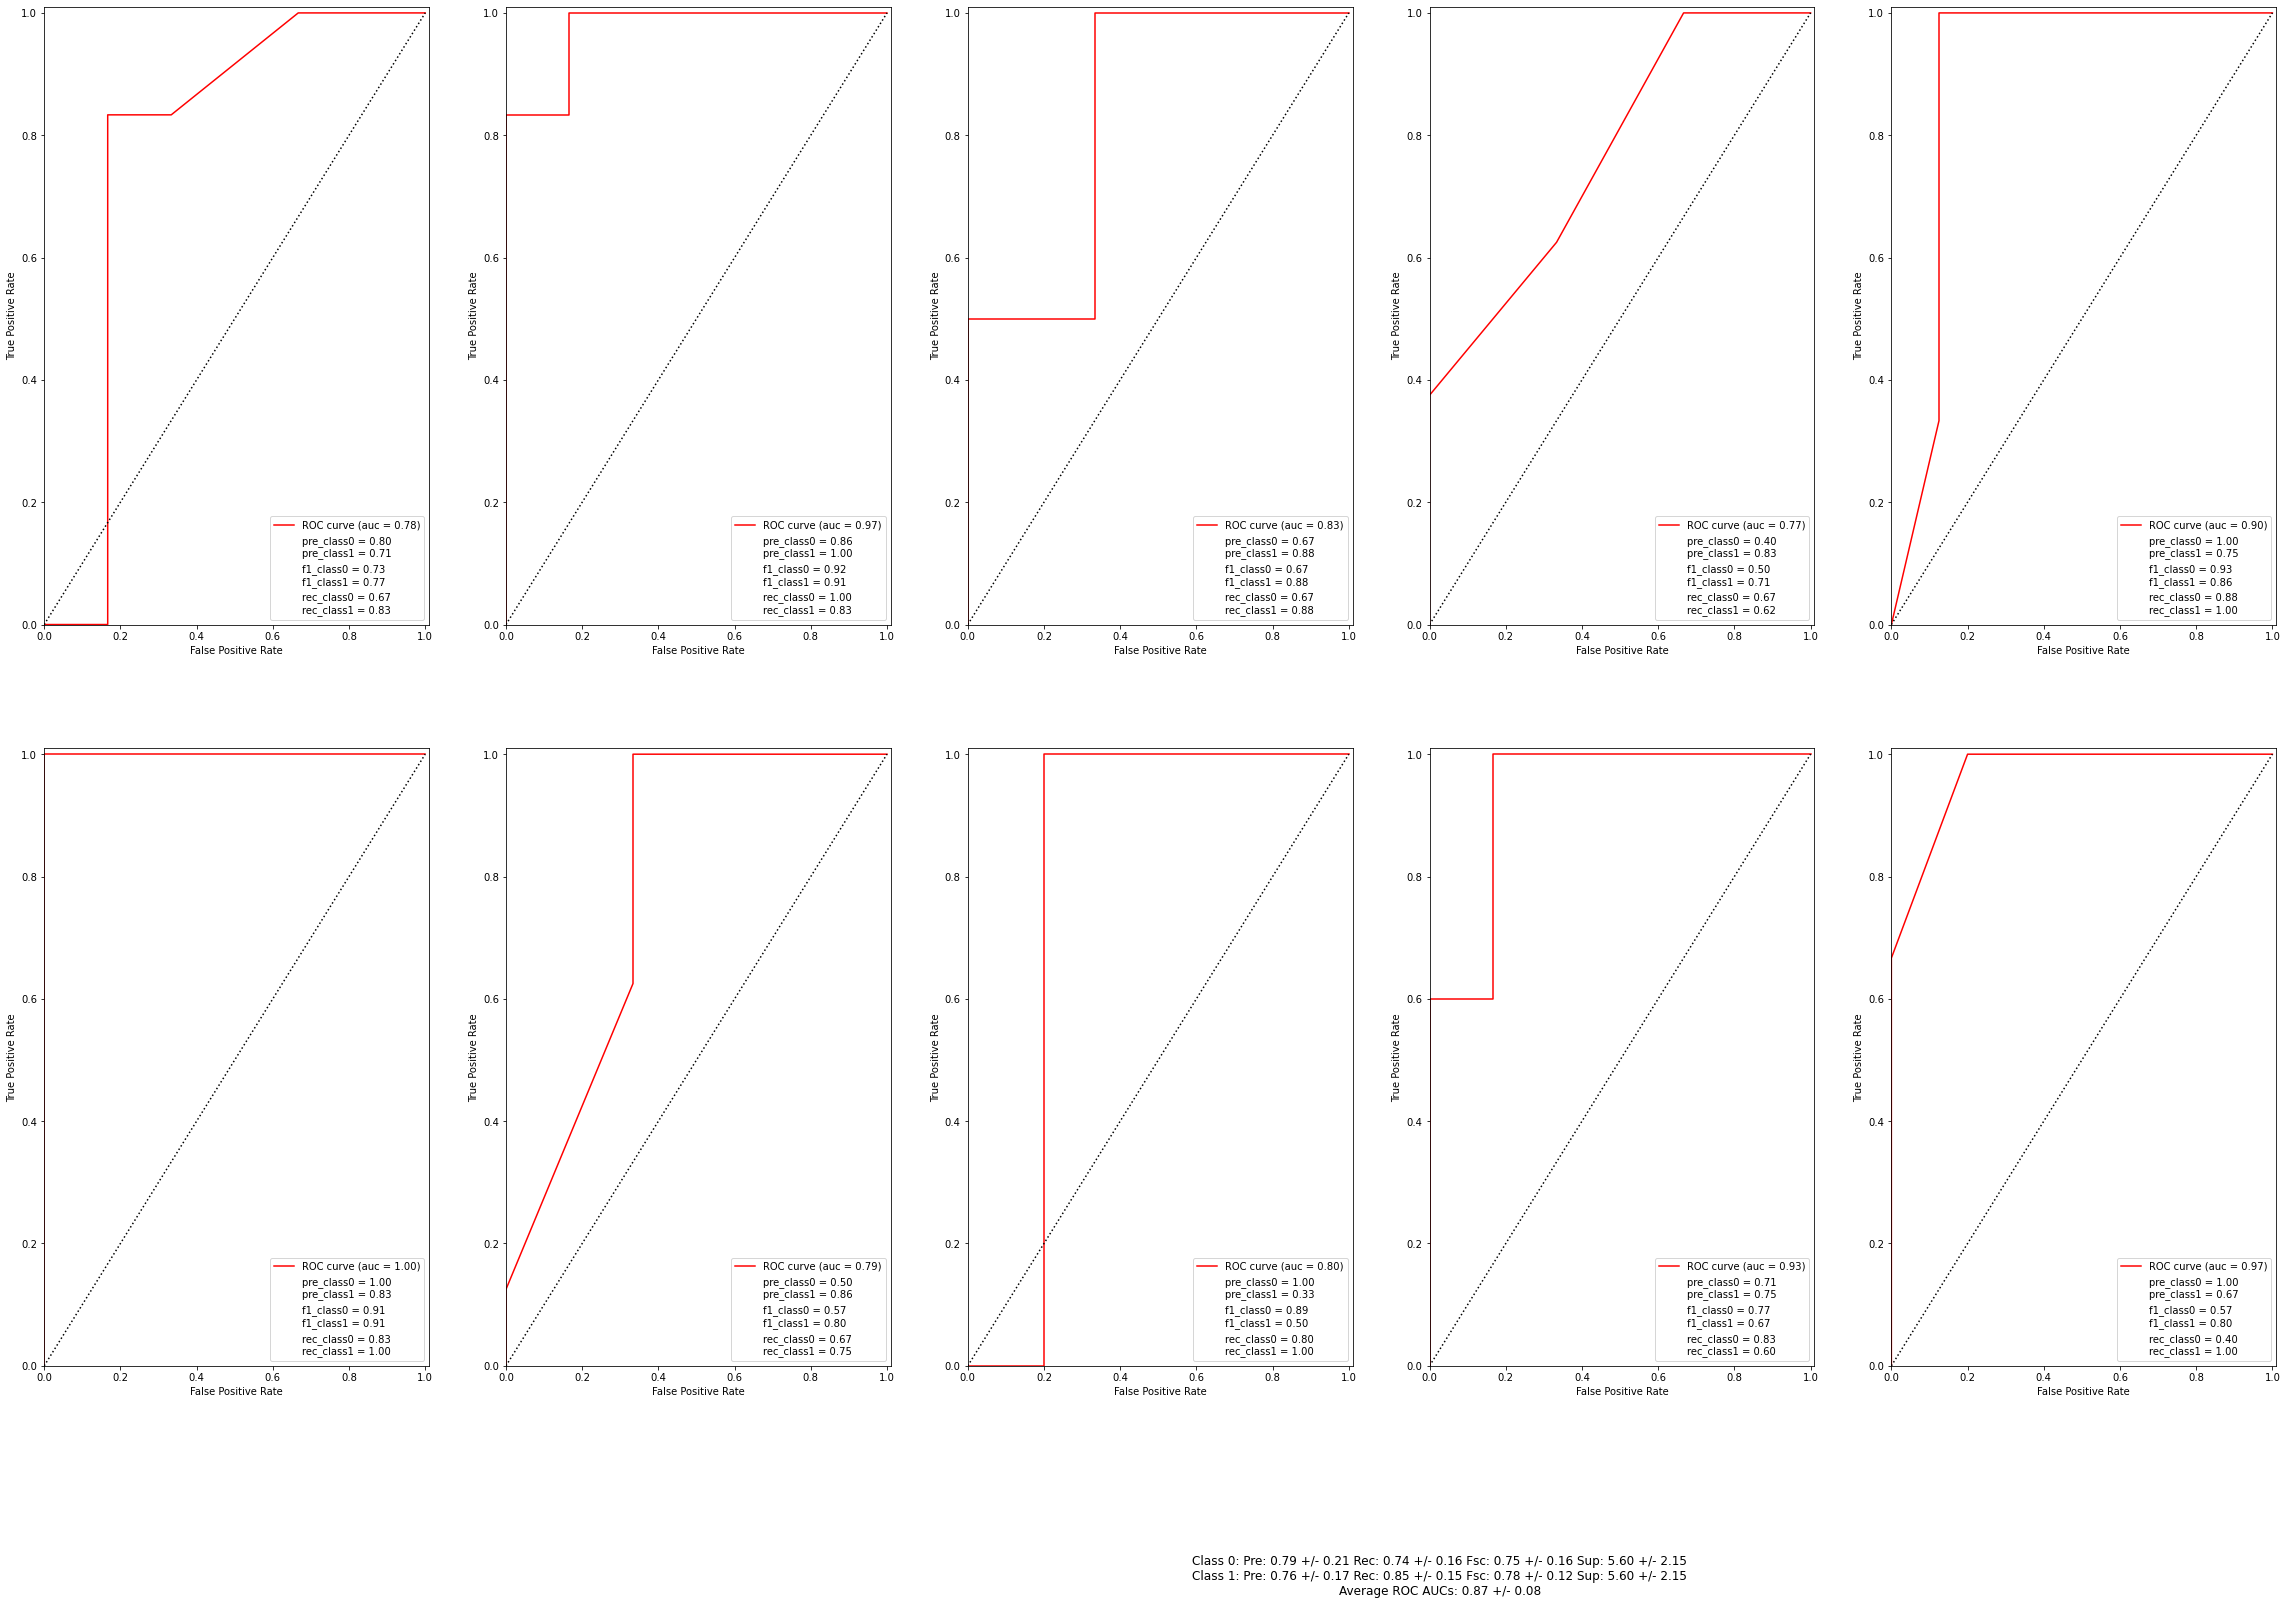


-----
Begin Gaussian Process
-----

----- Gaussian_Process: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/skl

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
	Best parameters; {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8737 (+/-0.0622) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8697 (+/-0.0611) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.8697 (+/-0.0611) for {'kernel': 1**2 * RBF(length_scale=1)}
	0.8697 (+/-0.0611) for {'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5)}

	----- Predicting using: Gaussian_Process -----
	ROC analysis area under the curve: 0.6666666666666667
	Confusion matrix (Gaussian_Process):
[[1 2]
 [1 7]]


	score (Gaussian_Process): 0.7272727272727273
	Imbalence reports:
	Imbalence classification report:
                   pre       rec

	 Index | Predicted | Label
	------------------
	16   |   1   |   1
	30   |   0   |   0
	32   |   0   |   0
	35   |   1   |   1
	37   |   0   |   0
	58   |   0   |   0
	59   |   0   |   1
	60   |   0   |   0
	68   |   1   |   0
	94   |   0   |   0
	98   |   0   |   0
-----

----- Gaussian_Process: Fold 5 -----
[11, 13, 17, 19, 28, 45, 74, 76, 91, 102, 105]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  18  20  21
  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  75  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  92  93  94  95  96  97  98
  99 100 101 103 104 106 107 108 109 110 111]
	Test indx: [ 11  13  17  19  28  45  74  76  91 102 105]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
	Best parameters; {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8964 (+/-0.0437) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8885 (+/-0.0482) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.8887 (+/-0.0525) for {'kernel': 1**2 * RBF(length_scale=1)}
	0.8887 (+/-0.0525) for {'kernel': 1**2 * RBF(len

	 Index | Predicted | Label
	------------------
	15   |   1   |   1
	36   |   1   |   0
	49   |   1   |   1
	69   |   1   |   1
	70   |   1   |   1
	77   |   1   |   1
	82   |   1   |   1
	104   |   1   |   0
	106   |   0   |   0
	107   |   0   |   0
	110   |   0   |   0
-----

All points have been used in a test case over all fold as they should have been
[[0.80297619 0.76825397]
 [0.76083333 0.84333333]
 [0.76681013 0.78230965]
 [5.6        5.6       ]] [[0.17881828 0.17963703]
 [0.19126952 0.13227707]
 [0.15418384 0.12575605]
 [2.15406592 2.15406592]] 0.8688888888888888 0.09360575322616146
/Users/matina/Desktop/Workflow/Modules/classification_workflow_functions.py:1032: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  figure.tight_layout()


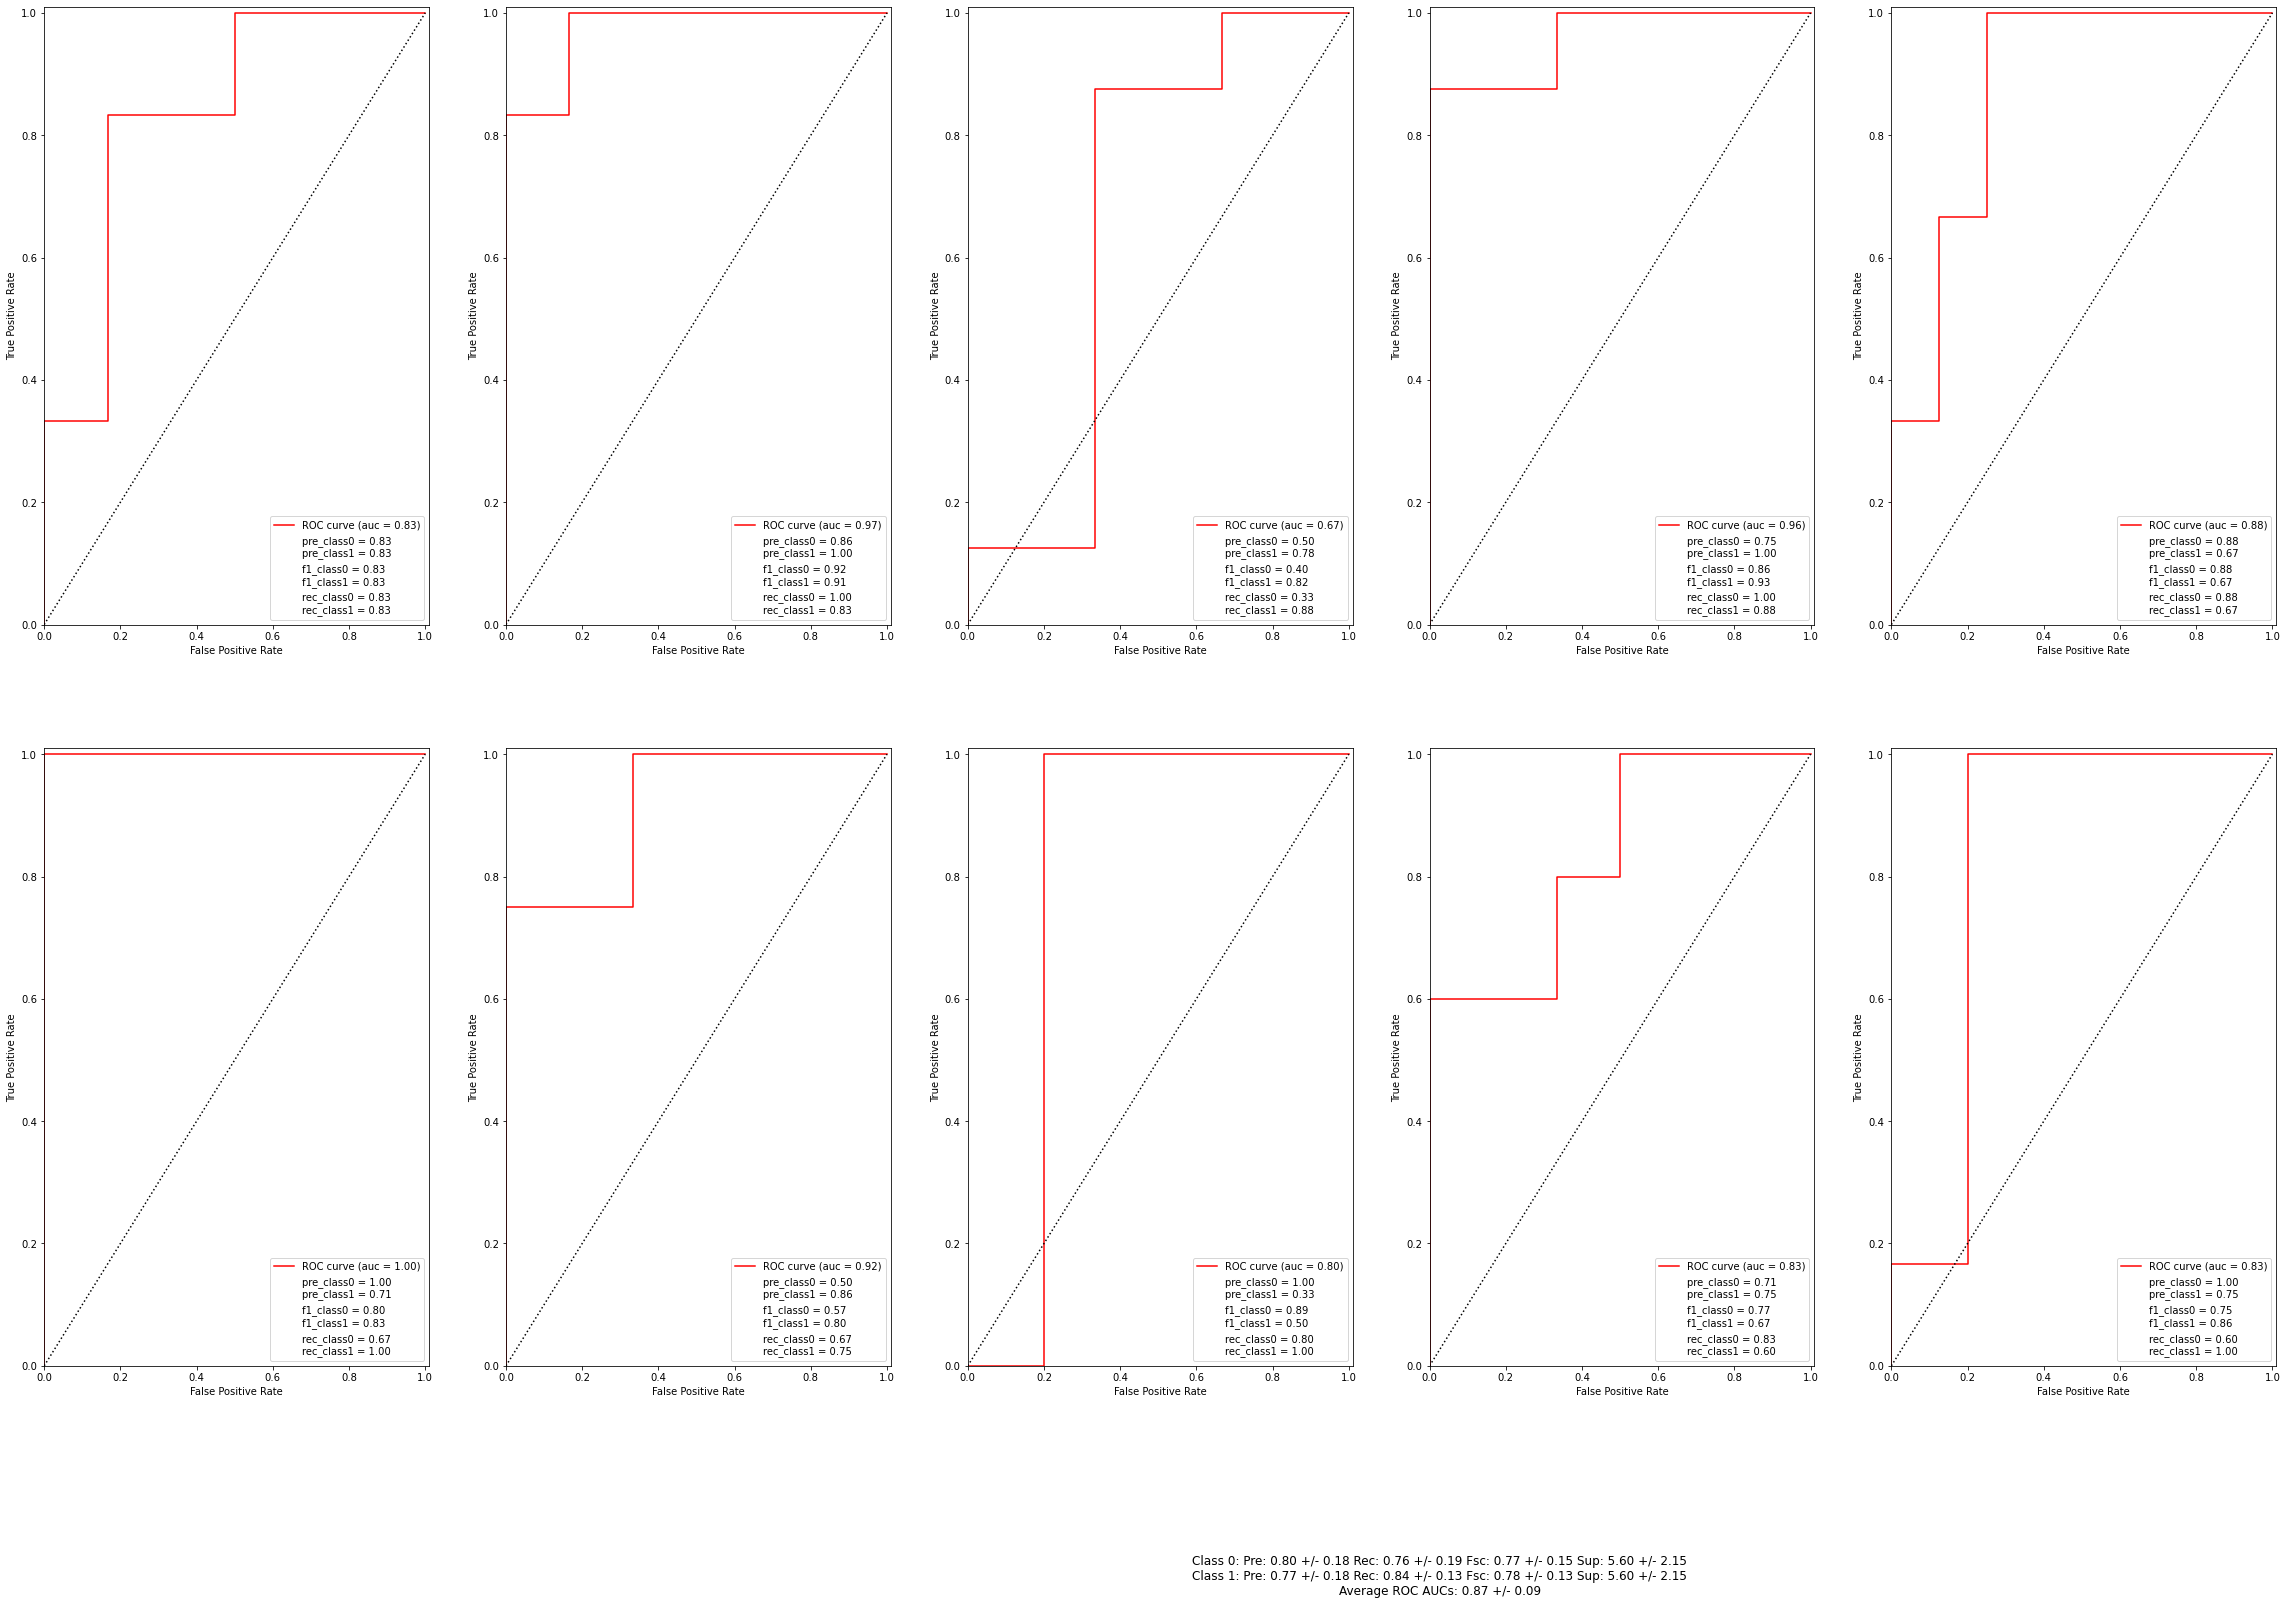


-----
Begin Decision Tree
-----

----- Decision_Tree: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
	Best parameters; {'max_depth': 4}
	0.7500 (+/-0.0632) for {'max_depth': 2}
	0.8190 (+/-0.1103) for {'max_depth': 3}
	0.8330 (+/-0.1051) for {'max_depth': 4}
	0.8170 (+/-0.0972) for {'max_depth': 5}
	0.7870 (+/-0.1081) for {'max_depth': 7}
	0.7600 (+/-0.1319) for {'max_depth': 10}

	----- Predicting using: Decision_Tree -----
	ROC analysis area under the curve: 0.6666666666666667
	Confusion matrix (Decision_Tree)

	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.75      0.33      0.75      0.50      0.26         8
          1       0.33      0.33      0.75      0.33      0.50      0.24         3

avg / total       0.64      0.64      0.45      0.64      0.50      0.25        11

	 Index | Predicted | Label
	------------------
	16   |   1   |   1
	30   |   0   |   0
	32   |   0   |   0
	35   |   0   |   1
	37   |   0   |   0
	58   |   0   |   0
	59   |   0   |   1
	60   |   1   |   0
	68   |   1   |   0
	94   |   0   |   0
	98   |   0   |   0
-----

----- Decision_Tree: Fold 5 -----
[11, 13, 17, 19, 28, 45, 74, 76, 91, 102, 105]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  18  20  21
  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70

	Best parameters; {'max_depth': 10}
	0.7556 (+/-0.1500) for {'max_depth': 2}
	0.7705 (+/-0.1229) for {'max_depth': 3}
	0.7645 (+/-0.1046) for {'max_depth': 4}
	0.7485 (+/-0.1041) for {'max_depth': 5}
	0.7645 (+/-0.0945) for {'max_depth': 7}
	0.7745 (+/-0.0897) for {'max_depth': 10}

	----- Predicting using: Decision_Tree -----
	ROC analysis area under the curve: 0.9166666666666667
	Confusion matrix (Decision_Tree):
[[5 0]
 [1 5]]


	score (Decision_Tree): 0.9090909090909091
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      1.00      0.83      0.91      0.91      0.85         5
          1       1.00      0.83      1.00      0.91      0.91      0.82         6

avg / total       0.92      0.91      0.92      0.91      0.91      0.83        11

	 Index | Predicted | Label
	------------------
	15   |   1   |   1
	36   |   0   |   0
	49   |   1   |   1
	69   |   0   |   1
	70 

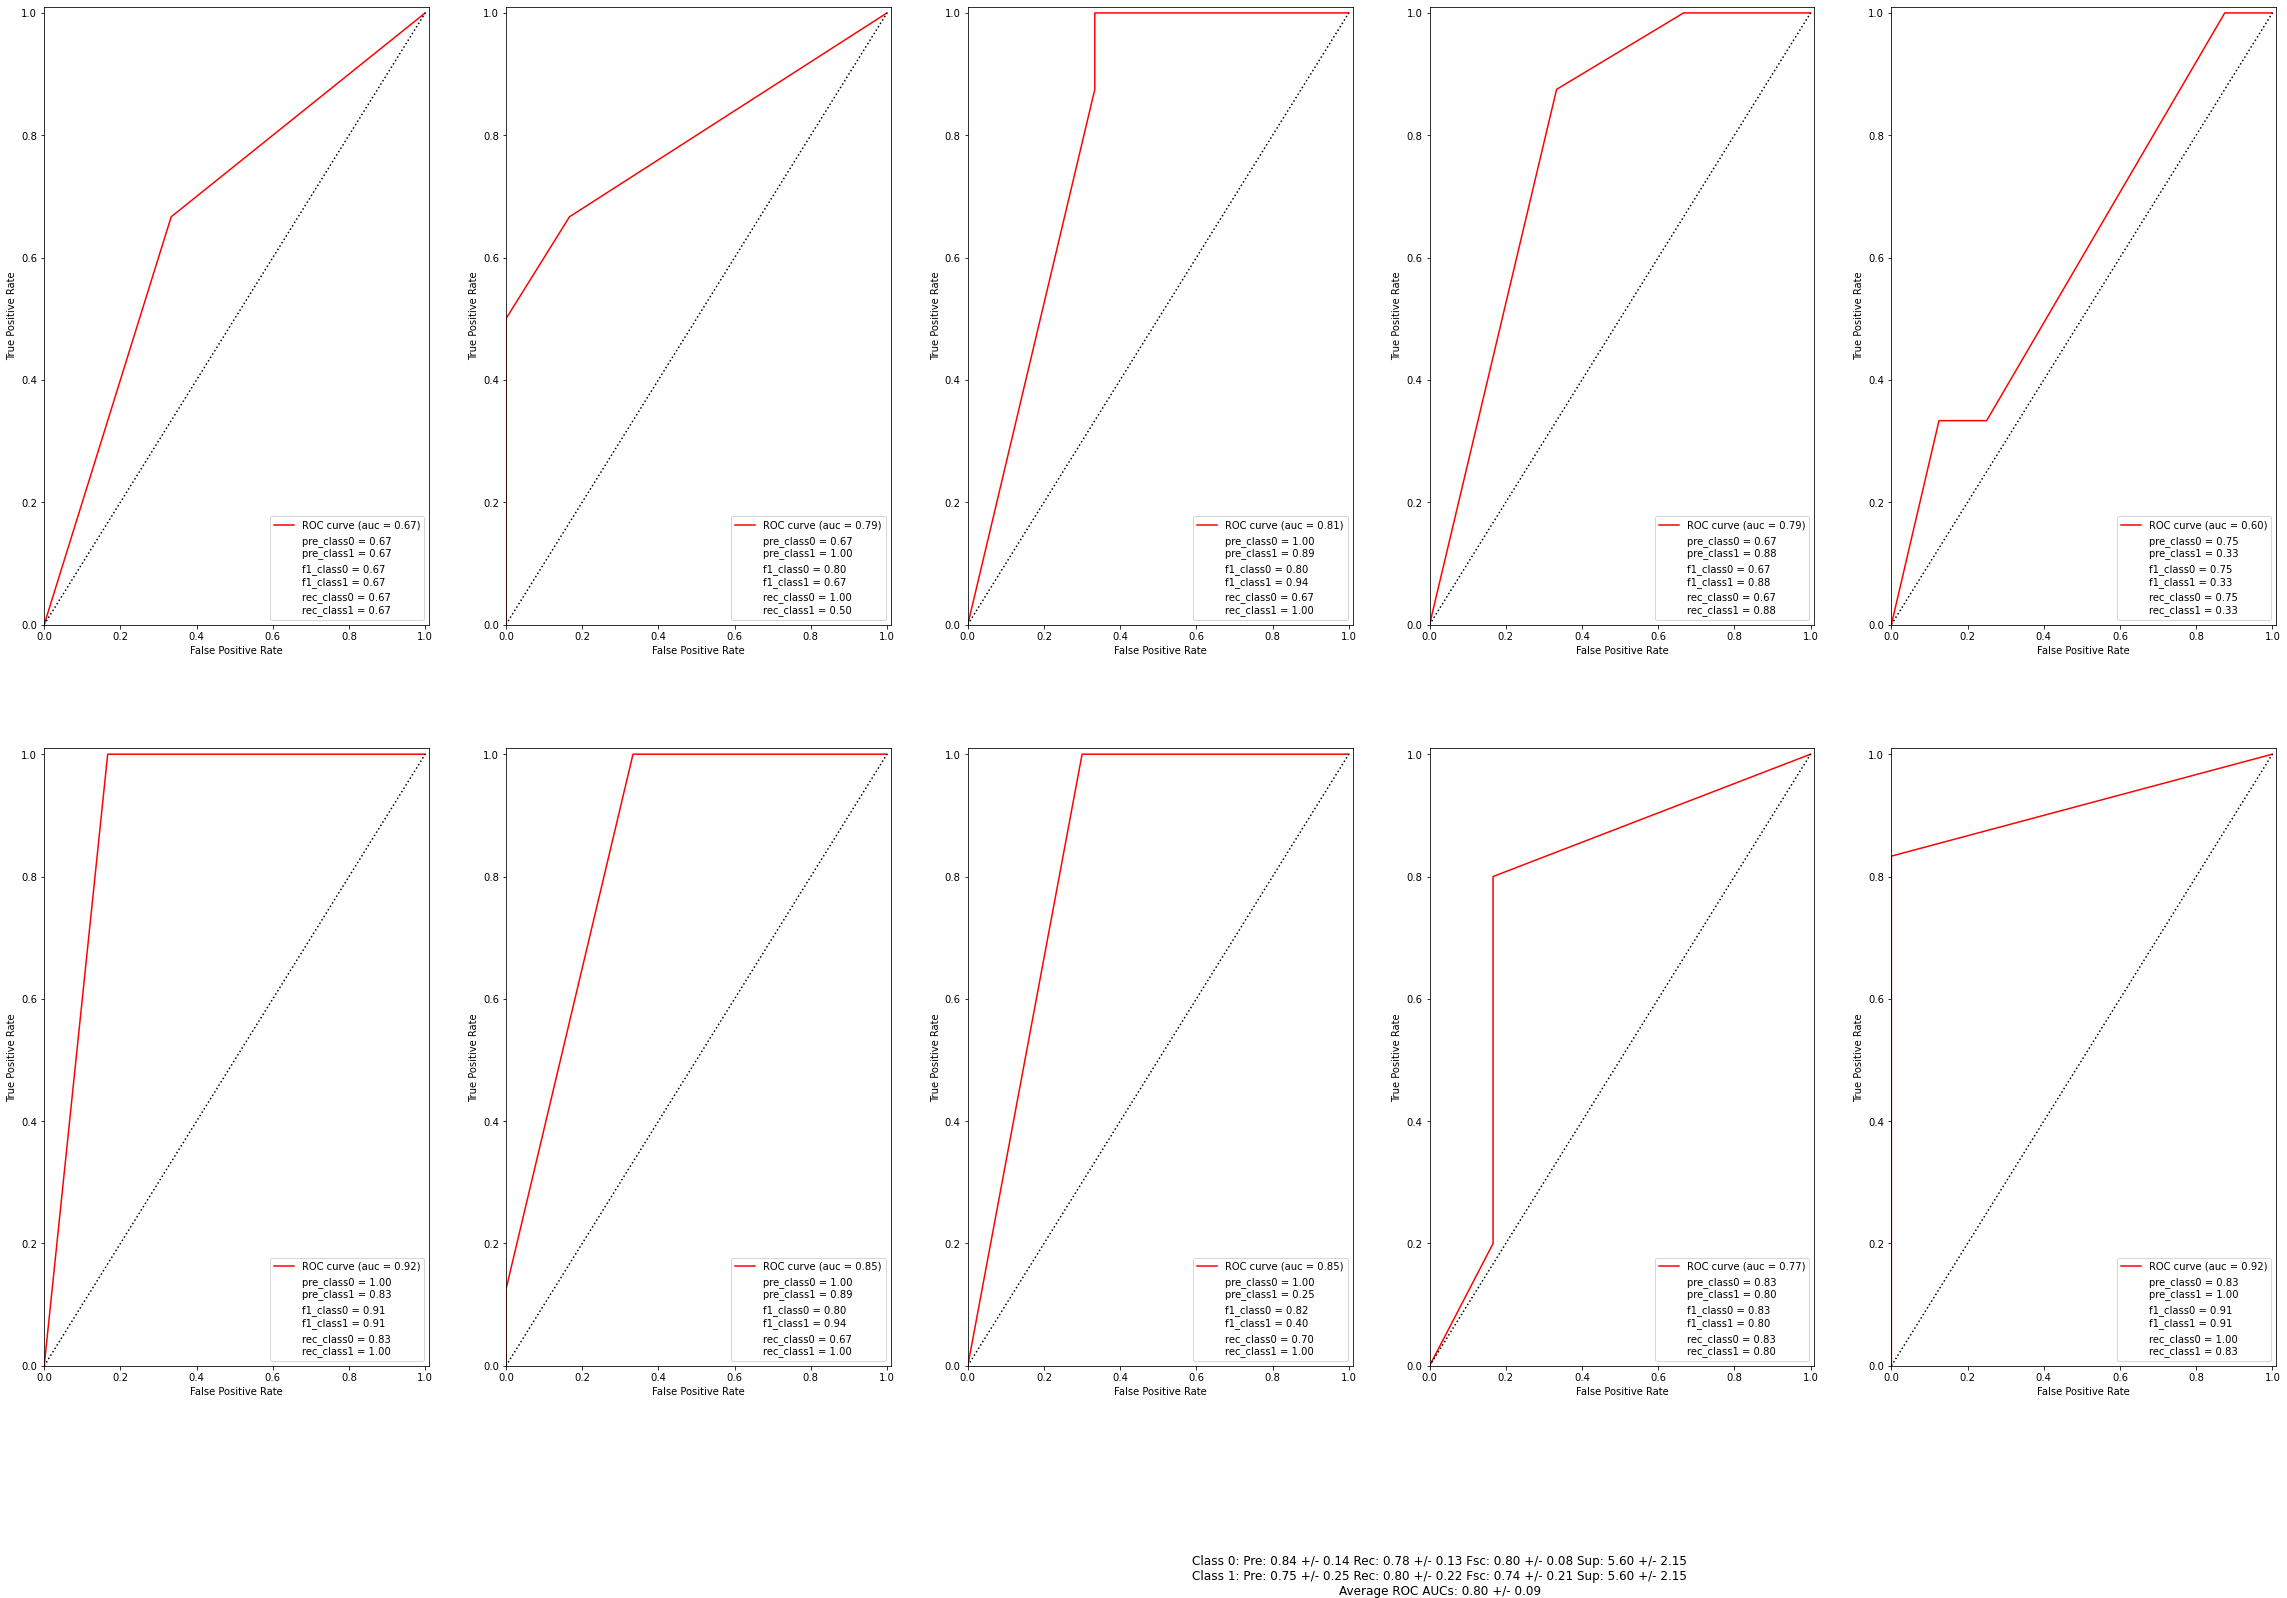


-----
Begin ExtraTreesClassifier
-----

----- ExtraTreesClassifier: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
	Best parameters; {'max_depth': 7, 'n_estimators': 50}
	0.8100 (+/-0.1043) for {'max_depth': 2, 'n_estimators': 10}
	0.8630 (+/-0.1309) for {'max_depth': 2, 'n_estimators': 20}
	0.8770 (+/-0.0866) for {'max_depth': 2, 'n_estimators': 50}
	0.8970 (+/-0.0822) for {'max_depth': 2, 'n_estimators': 100}
	0.8680 (+/-0.1291) for {'max_depth': 3, 'n_estimators': 10}
	0.8920 (+/-0.1236) for {'max_depth': 3, 

	Confusion matrix (ExtraTreesClassifier):
[[1 2]
 [2 6]]


	score (ExtraTreesClassifier): 0.6363636363636364
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.33      0.33      0.75      0.33      0.50      0.24         3
          1       0.75      0.75      0.33      0.75      0.50      0.26         8

avg / total       0.64      0.64      0.45      0.64      0.50      0.25        11

	 Index | Predicted | Label
	------------------
	22   |   1   |   1
	46   |   1   |   1
	50   |   1   |   1
	52   |   1   |   1
	53   |   0   |   1
	54   |   0   |   1
	72   |   1   |   0
	73   |   1   |   0
	80   |   1   |   1
	88   |   1   |   1
	109   |   0   |   0
-----

----- ExtraTreesClassifier: Fold 3 -----
[8, 14, 24, 42, 48, 51, 61, 64, 71, 81, 83]
	Train indx [  0   1   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  19
  20  21  22  23  25  26  27  28  29  30  31  32  33  34

	Best parameters; {'max_depth': 5, 'n_estimators': 20}
	0.8258 (+/-0.1206) for {'max_depth': 2, 'n_estimators': 10}
	0.8501 (+/-0.1107) for {'max_depth': 2, 'n_estimators': 20}
	0.8711 (+/-0.1143) for {'max_depth': 2, 'n_estimators': 50}
	0.8698 (+/-0.1109) for {'max_depth': 2, 'n_estimators': 100}
	0.8356 (+/-0.1171) for {'max_depth': 3, 'n_estimators': 10}
	0.8665 (+/-0.1130) for {'max_depth': 3, 'n_estimators': 20}
	0.8636 (+/-0.1139) for {'max_depth': 3, 'n_estimators': 50}
	0.8649 (+/-0.1252) for {'max_depth': 3, 'n_estimators': 100}
	0.8544 (+/-0.1238) for {'max_depth': 4, 'n_estimators': 10}
	0.8710 (+/-0.1128) for {'max_depth': 4, 'n_estimators': 20}
	0.8902 (+/-0.0928) for {'max_depth': 4, 'n_estimators': 50}
	0.8791 (+/-0.1037) for {'max_depth': 4, 'n_estimators': 100}
	0.8904 (+/-0.0849) for {'max_depth': 5, 'n_estimators': 10}
	0.9084 (+/-0.0832) for {'max_depth': 5, 'n_estimators': 20}
	0.8909 (+/-0.0938) for {'max_depth': 5, 'n_estimators': 50}
	0.8782 (+/-0.1065) for {'m

	0.9136 (+/-0.0534) for {'max_depth': 10, 'n_estimators': 20}
	0.9478 (+/-0.0557) for {'max_depth': 10, 'n_estimators': 50}
	0.9296 (+/-0.0514) for {'max_depth': 10, 'n_estimators': 100}

	----- Predicting using: ExtraTreesClassifier -----
	ROC analysis area under the curve: 0.8
	Confusion matrix (ExtraTreesClassifier):
[[8 2]
 [0 1]]


	score (ExtraTreesClassifier): 0.8181818181818182
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.80      1.00      0.89      0.89      0.78        10
          1       0.33      1.00      0.80      0.50      0.89      0.82         1

avg / total       0.94      0.82      0.98      0.85      0.89      0.79        11

	 Index | Predicted | Label
	------------------
	2   |   0   |   0
	12   |   0   |   0
	20   |   1   |   0
	29   |   0   |   0
	34   |   0   |   0
	62   |   0   |   0
	67   |   1   |   1
	97   |   1   |   0
	100   |   0   

In [ ]:
cwf.kfold_test_imbalenced_classifiers_with_optimization(features_smote_df, classes_smote_df, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale=True, cv=5, n_repeats=10, smiles=None, names=None,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

In [49]:
directory_names = cwf.directory_names_from_classfier_names(kfold_clf_names)

In [50]:
directory_names

['Nearest_Neighbors',
 'Gaussian_Process',
 'Decision_Tree',
 'ExtraTreesClassifier',
 'AdaBoost',
 'Logistic_Regression']

## Analyses the output over all folds and predictions therefore for all moleucles
The next cell reads in the predictions from each fold (n_repeats max_folds should = n_repeats).


Nearest_Neighbors
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_nearest_neighbors_morderd.png
['ddg_nearest_neighbors_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 45, 'fp': 11, 'fn': 9, 'tp': 47}
[[45 11]
 [ 9 47]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Gaussian_Process
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_gaussian_process_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 46, 'fp': 10, 'fn': 7, 'tp': 49}
[[46 10]
 [ 7 49]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Decision_Tree
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_decision_tree_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 42, 'fp': 14, 'fn': 10, 'tp': 46}
[[42 14]
 [10 46]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

ExtraTreesClassifier
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_extratreesclassifier_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 44, 'fp': 12, 'fn': 6, 'tp': 50}
[[44 12]
 [ 6 50]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

AdaBoost
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_adaboost_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 47, 'fp': 9, 'fn': 9, 'tp': 47}
[[47  9]
 [ 9 47]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Logistic_Regression
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_logistic_regression_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png', 'ddg_logistic_regression_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 42, 'fp': 14, 'fn': 8, 'tp': 48}
[[42 14]
 [ 8 48]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  sensitivity &  specificity &       mcc &  precision &    g-mean \\
\midrule
nearest neighbors      &  0.821429 &     0.839286 &     0.803571 &  0.643268 &   0.810345 &  0.821234 \\
gaussian process       &  0.848214 &     0.875000 &     0.821429 &  0.697430 &   0.830508 &  0.847791 \\
decision tree          &  0.785714 &     0.821429 &     0.750000 &  0.572892 &   0.766667 &  0.784902 \\
extra trees classifier &  0.839286 &     0.892857 &     0.785714 &  0.682500 &   0.806452 &  0.837574 \\
adaboost               &  0.839286 &     0.839286 &     0.839286 &  0.678571 &   0.839286 &  0.839286 \\
logistic regression    &  0.803571 &     0.857143 &     0.750000 &  0.610658 &   0.774194 &  0.801784 \\
\bottomrule
\end{tabular}



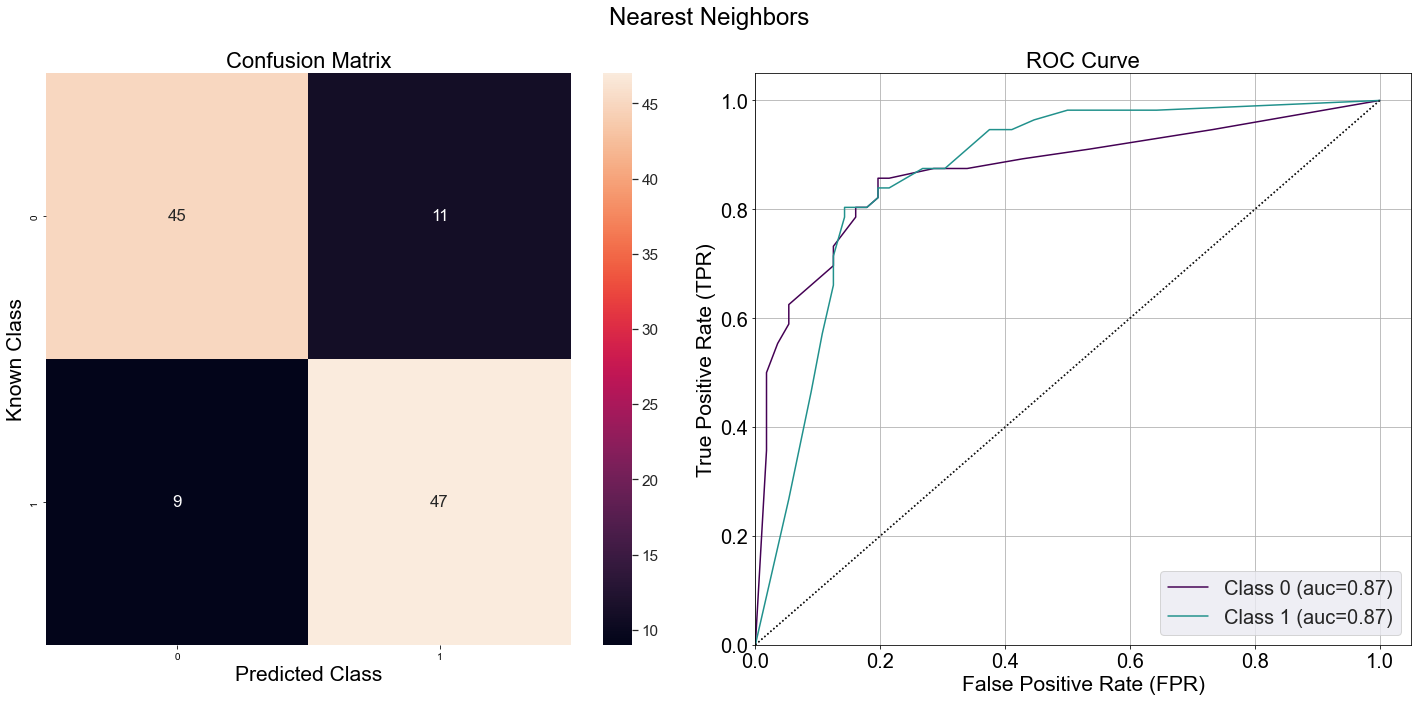

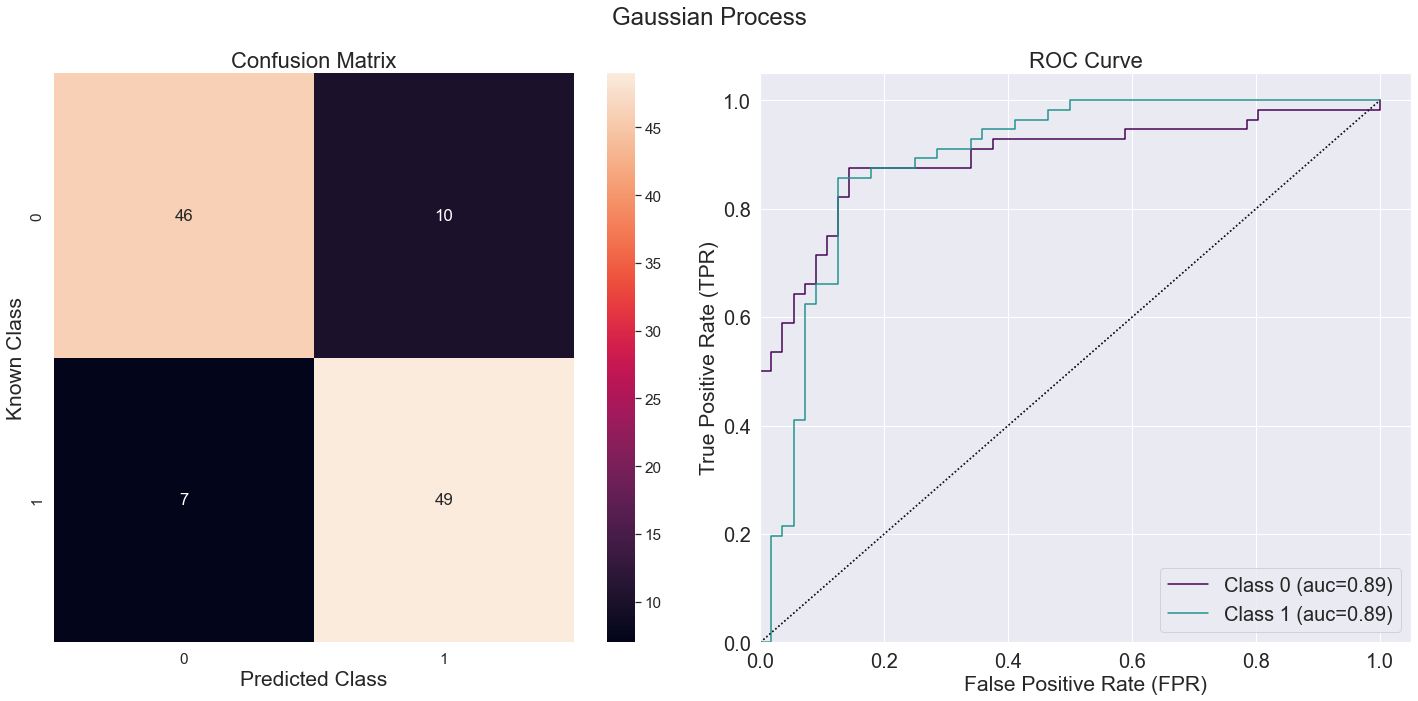

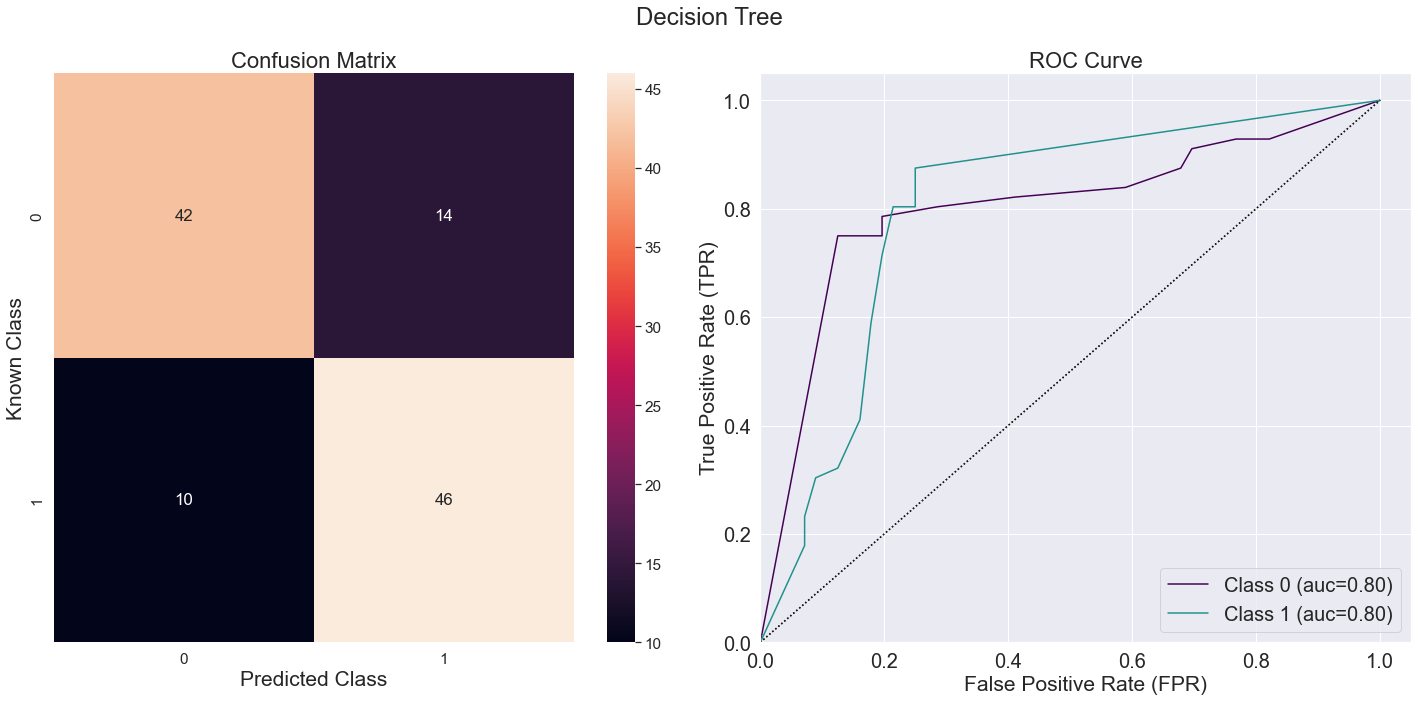

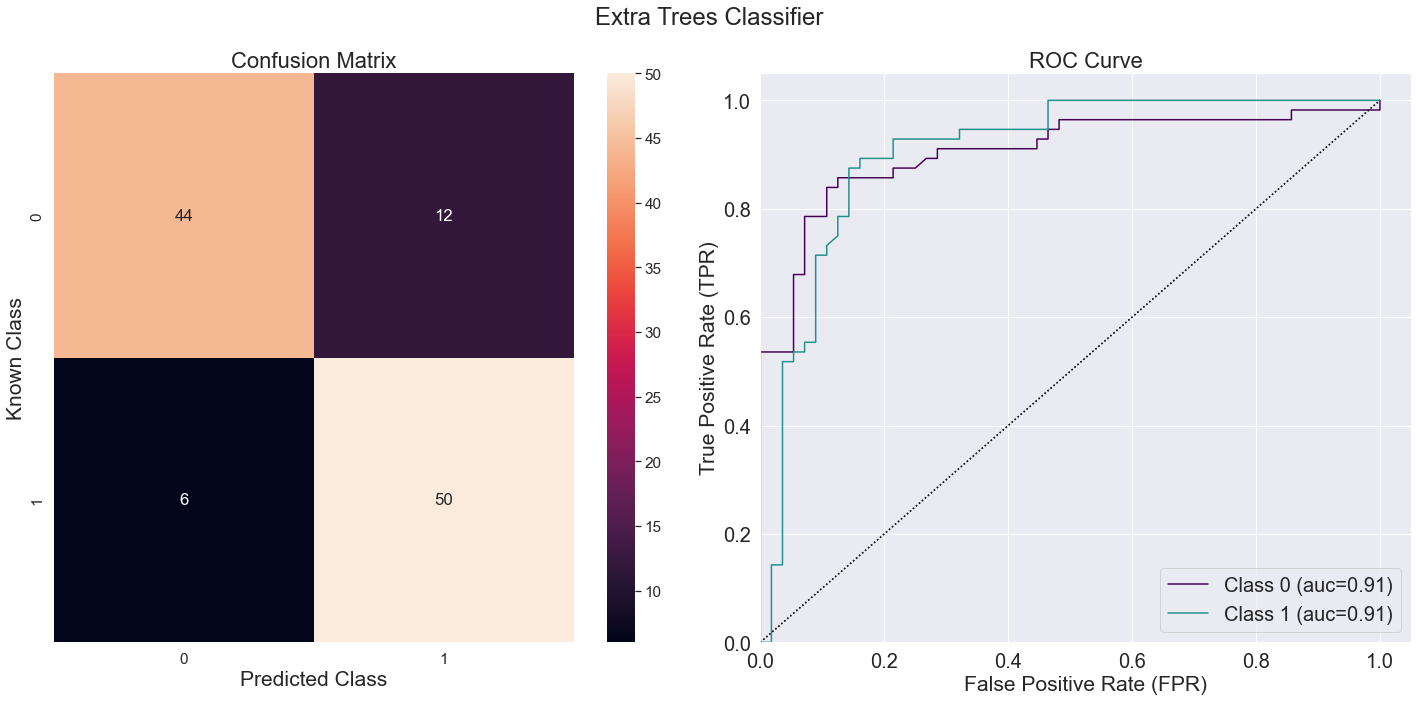

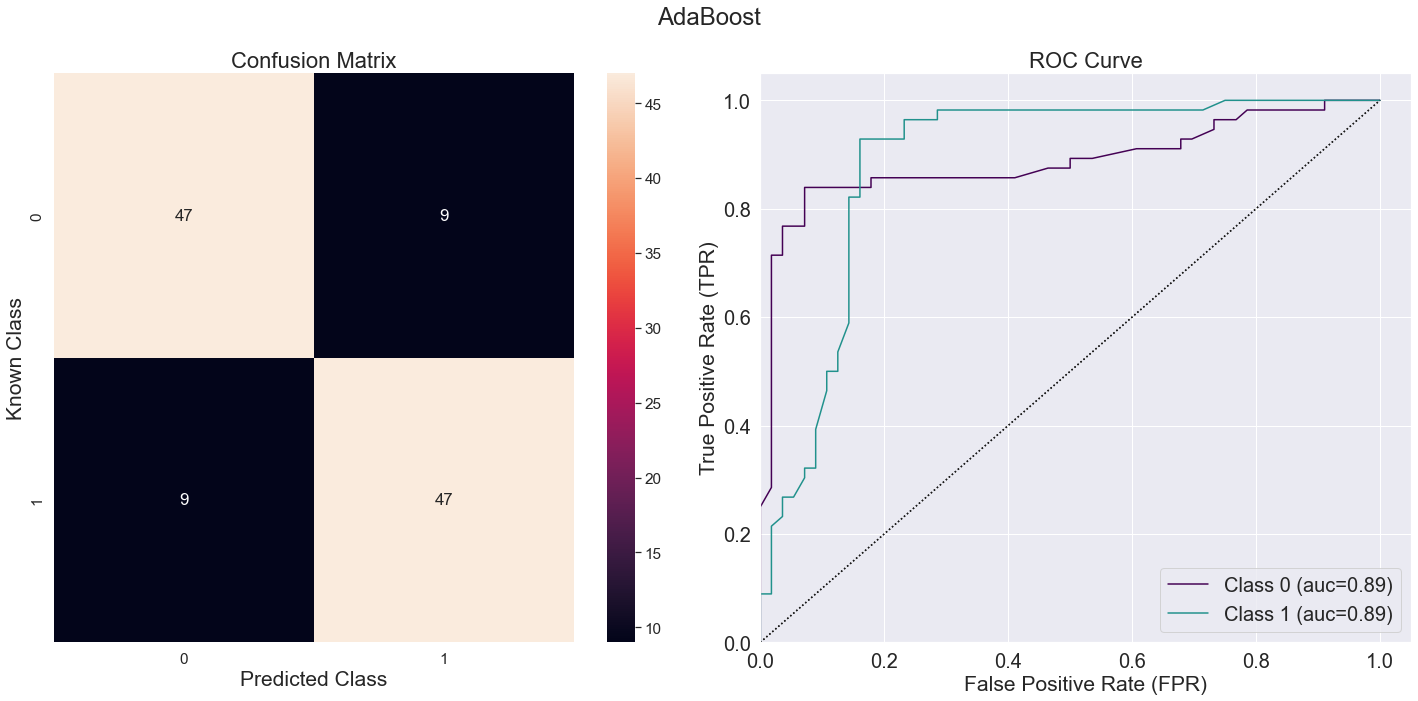

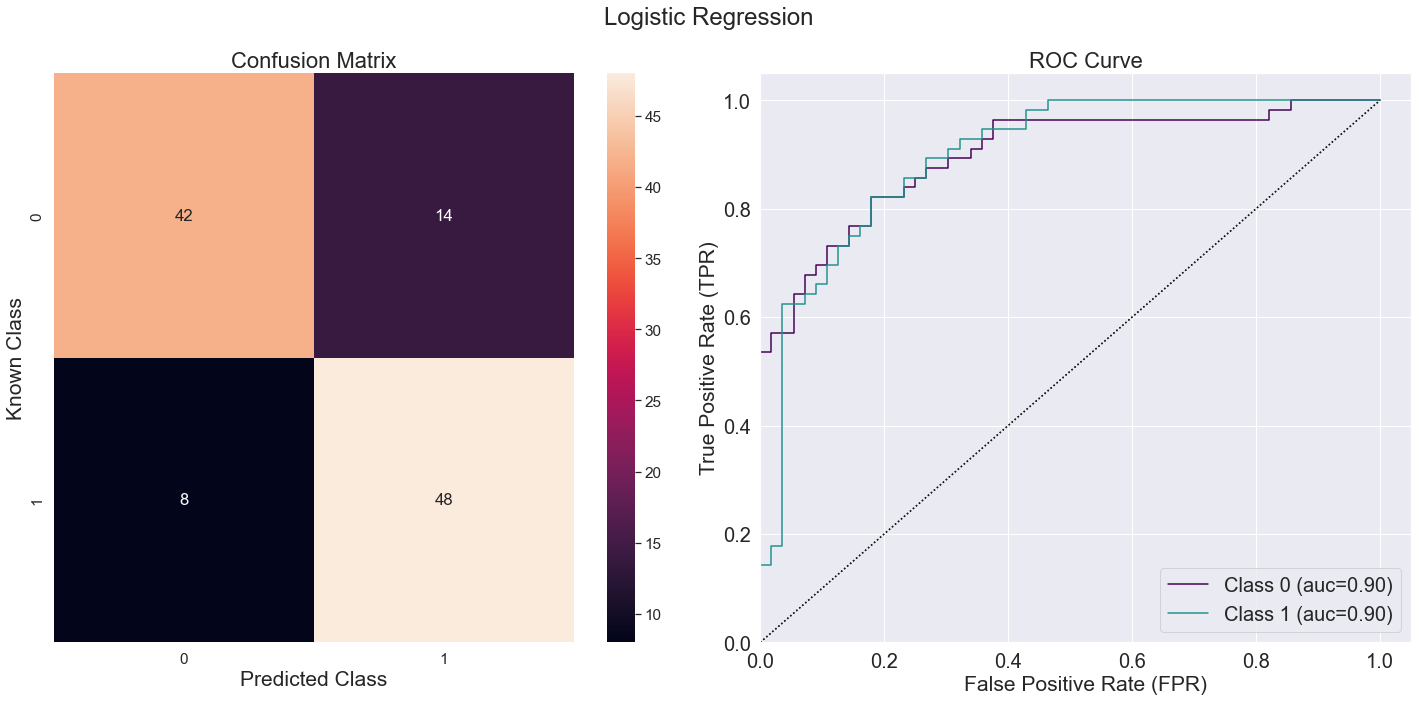

In [51]:
files_plt = []

kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Extra Trees Classifier", "AdaBoost",
         "Logistic Regression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=10)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_morderd.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [52]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_mordred.png")

Combining 6 images
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
New image will be W:1440 H:4320
Image 0 added at offset height 0
Image 1 added at offset height 720
Image 2 added at offset height 1440
Image 3 added at offset height 2160
Image 4 added at offset height 2880
Image 5 added at offset height 3600


# Now first we split 90%-10% (train-test)

In [53]:
data = pd.read_csv("Second_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [54]:
data

,reaction,substrate,catalyst,solvent,solvent_code,temperature,ee,ddg,paper
0,0,O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,0.0,0.000000,ORGLETT 2008
1,1,O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,0.0,0.000000,ORGLETT 2008
2,2,O=C1CCC(Cl)N1CCC2=CSC=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,30.0,1.426491,ORGLETT 2008
3,3,O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,15.0,0.696565,ORGLETT 2008
4,4,O=C1CCC(Cl)N1CCC2=CNC=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,60.0,3.194526,ORGLETT 2008
...,...,...,...,...,...,...,...,...,...
85,85,O=C1CCC(C)(Cl)N1CCC2=CNC3=CC=C(OC)C=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,91.0,4.957045,JACS 2007
86,86,O=C1CCCC(Cl)N1CCC2=CNC3=CC=CC=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-55.0,81.0,4.088429,JACS 2007
87,87,O=C1CCCC(C)(Cl)N1CCC2=CNC3=CC=CC=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,92.0,5.156630,JACS 2007
88,88,O=C1CCCC(CCCC)(Cl)N1CCC2=CNC3=CC=CC=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,96.0,6.314769,JACS 2007


We know which data points we are using for test set, for consistency reasons. 
These are: 

In [58]:
test_reactions = [49, 33, 19, 1, 6, 51, 66,47, 58] 

In [59]:
reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64


we romove from the data the test reactions

In [60]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

In [61]:
train_data

,reaction,substrate,catalyst,solvent,solvent_code,temperature,ee,ddg,paper
0,0,O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,0.0,0.000000,ORGLETT 2008
2,2,O=C1CCC(Cl)N1CCC2=CSC=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,30.0,1.426491,ORGLETT 2008
3,3,O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,15.0,0.696565,ORGLETT 2008
4,4,O=C1CCC(Cl)N1CCC2=CNC=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,60.0,3.194526,ORGLETT 2008
5,5,O=C1CCC(C)(Cl)N1CCC2=CNC=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,90.0,4.777572,ORGLETT 2008
...,...,...,...,...,...,...,...,...,...
85,85,O=C1CCC(C)(Cl)N1CCC2=CNC3=CC=C(OC)C=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,91.0,4.957045,JACS 2007
86,86,O=C1CCCC(Cl)N1CCC2=CNC3=CC=CC=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-55.0,81.0,4.088429,JACS 2007
87,87,O=C1CCCC(C)(Cl)N1CCC2=CNC3=CC=CC=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,92.0,5.156630,JACS 2007
88,88,O=C1CCCC(CCCC)(Cl)N1CCC2=CNC3=CC=CC=C32,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,96.0,6.314769,JACS 2007


and we generate the test dataframe

In [62]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [63]:
test_data

,reaction,substrate,catalyst,solvent,solvent_code,temperature,ee,ddg,paper
49,49,O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32,S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=CC=CC=C3)CCCC1...,MTBE,4,4.0,80.0,5.063205,JACS 2007
33,33,O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32,S=C(N[C@H]1[C@H](NS(C(C)(C)C)=O)CCCC1)NC2=CC(C...,MTBE,4,4.0,4.0,0.184448,JACS 2007
19,19,O=C1CCCC(CCCC)(Cl)N1CCC2=CN([Si](C(C)C)(C(C)C)...,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-55.0,97.0,7.590046,ORGLETT 2008
1,1,O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,4.0,0.0,0.000000,ORGLETT 2008
6,6,O=C1CCC(CCCC)(Cl)N1CCC2=CNC=C2,CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...,MTBE,4,-78.0,91.0,4.957045,ORGLETT 2008
51,51,O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32,S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=CC=CC=C3)CCCC1...,MTBE,4,4.0,74.0,4.380500,JACS 2007
66,66,O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32,S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=C(C=CC=C4)C4=C...,MTBE,4,4.0,66.0,3.653862,JACS 2007
47,47,O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32,S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=CC=CC=C3)CCCC1...,MTBE,4,4.0,84.0,5.628056,JACS 2007
58,58,O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32,S=C(N[C@H]1[C@H](N2C=CC(C(OC(C)(C)C)=O)=C2C(C)...,MTBE,4,4.0,64.0,3.494216,JACS 2007


In [64]:
substratesmiles_train = train_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_train.head()))

catalystsmiles_train = train_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_train.head()))

ddg_train = train_data["ddg"]
log.info("DGG: {}".format(ddg_train.head()))

Substrate SMILES: 0      O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2
2            O=C1CCC(Cl)N1CCC2=CSC=C2
3    O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3
4            O=C1CCC(Cl)N1CCC2=CNC=C2
5         O=C1CCC(C)(Cl)N1CCC2=CNC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
2    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
3    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
4    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
5    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
Name: catalyst, dtype: object
DGG: 0    0.000000
2    1.426491
3    0.696565
4    3.194526
5    4.777572
Name: ddg, dtype: float64


In [65]:
target_train = ddg_train

In [66]:
substratesmiles_test = test_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_test.head()))

catalystsmiles_test = test_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_test.head()))

ddg_test = test_data["ddg"]
log.info("DGG: {}".format(ddg_test.head()))

Substrate SMILES: 49                     O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32
33                     O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32
19    O=C1CCCC(CCCC)(Cl)N1CCC2=CN([Si](C(C)C)(C(C)C)...
1                    O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2
6                        O=C1CCC(CCCC)(Cl)N1CCC2=CNC=C2
Name: substrate, dtype: object
Catalyst SMILES: 49    S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=CC=CC=C3)CCCC1...
33    S=C(N[C@H]1[C@H](NS(C(C)(C)C)=O)CCCC1)NC2=CC(C...
19    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
1     CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
6     CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
Name: catalyst, dtype: object
DGG: 49    5.063205
33    0.184448
19    7.590046
1     0.000000
6     4.957045
Name: ddg, dtype: float64


In [67]:
target_test = ddg_test

Generating Mordred Descriptors for the training set

First for the substrates

In [68]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_train = [cwf.get_mol_from_smiles(s) for s in substratesmiles_train]
subfeatures_df_train = calc.pandas(submolecule_list_train)

100%|██████████| 81/81 [00:17<00:00,  4.55it/s]


In [69]:
subfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df_train.index)))
threshold = 0.5
subfeatures_df_train.drop(subfeatures_df_train.std()[subfeatures_df_train.std() < threshold].index.values, axis=1)
subfeatures_df_train.columns = [ent.strip() for ent in subfeatures_df_train.columns]
subfeatures_df_train.head()

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,12.865821,11.266795,0,0,21.826366,2.338919,4.587482,21.826366,1.283904,3.749005,...,9.482426,63.130926,253.086956,7.669302,581,22,84.0,96.0,5.805556,3.888889
1,10.744501,10.260282,0,0,17.982356,2.336958,4.505232,17.982356,1.284454,3.569498,...,9.224342,60.747309,229.032813,8.808954,322,15,70.0,80.0,4.444444,3.138889
2,14.199155,12.457708,0,0,23.804025,2.410734,4.671853,23.804025,1.322446,3.841465,...,9.752141,67.100439,279.048463,8.720264,630,25,96.0,114.0,5.166667,3.944444
3,10.744501,10.260282,0,0,17.982356,2.336958,4.505232,17.982356,1.284454,3.569498,...,9.224342,60.747309,212.071641,7.854505,322,15,70.0,80.0,4.444444,3.138889
4,11.638886,11.119230,0,0,18.655572,2.421632,4.682800,18.655572,1.243705,3.643595,...,9.536979,62.877757,226.087291,7.536243,377,18,78.0,90.0,5.395833,3.236111


In [70]:
subfeatures_df_train

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,12.865821,11.266795,0,0,21.826366,2.338919,4.587482,21.826366,1.283904,3.749005,...,9.482426,63.130926,253.086956,7.669302,581,22,84.0,96.0,5.805556,3.888889
1,10.744501,10.260282,0,0,17.982356,2.336958,4.505232,17.982356,1.284454,3.569498,...,9.224342,60.747309,229.032813,8.808954,322,15,70.0,80.0,4.444444,3.138889
2,14.199155,12.457708,0,0,23.804025,2.410734,4.671853,23.804025,1.322446,3.841465,...,9.752141,67.100439,279.048463,8.720264,630,25,96.0,114.0,5.166667,3.944444
3,10.744501,10.260282,0,0,17.982356,2.336958,4.505232,17.982356,1.284454,3.569498,...,9.224342,60.747309,212.071641,7.854505,322,15,70.0,80.0,4.444444,3.138889
4,11.638886,11.119230,0,0,18.655572,2.421632,4.682800,18.655572,1.243705,3.643595,...,9.536979,62.877757,226.087291,7.536243,377,18,78.0,90.0,5.395833,3.236111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,16.507753,14.449726,0,0,26.915709,2.451224,4.767906,26.915709,1.281700,3.990955,...,10.046158,71.358779,306.113506,7.652838,953,32,114.0,136.0,7.229167,4.541667
77,14.906262,12.447004,0,0,24.908084,2.407056,4.725663,24.908084,1.310952,3.887439,...,9.830002,66.373271,276.102941,7.669526,731,28,100.0,118.0,5.416667,4.194444
78,15.800646,13.284771,0,0,25.538663,2.427288,4.822853,25.538663,1.276933,3.941835,...,10.023712,67.973184,290.118591,7.438938,822,31,108.0,128.0,6.368056,4.291667
79,17.763048,14.857121,0,0,29.788121,2.441920,4.864885,29.788121,1.295136,4.066843,...,10.108915,71.448514,332.165541,6.920115,1219,36,120.0,142.0,7.118056,5.166667


In [71]:
log.info(subfeatures_df_train)
subfeatures_types = "some_catagorical" 

          ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0   12.865821  11.266795      0      0  21.826366  2.338919  4.587482   
1   10.744501  10.260282      0      0  17.982356  2.336958  4.505232   
2   14.199155  12.457708      0      0  23.804025  2.410734  4.671853   
3   10.744501  10.260282      0      0  17.982356  2.336958  4.505232   
4   11.638886  11.119230      0      0  18.655572  2.421632  4.682800   
..        ...        ...    ...    ...        ...       ...       ...   
76  16.507753  14.449726      0      0  26.915709  2.451224  4.767906   
77  14.906262  12.447004      0      0  24.908084  2.407056  4.725663   
78  15.800646  13.284771      0      0  25.538663  2.427288  4.822853   
79  17.763048  14.857121      0      0  29.788121  2.441920  4.864885   
80  15.093540  13.289946      0      0  24.480946  2.442136  4.732099   

       SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0   21.826366  1.283904  3.749005  ...   9.4824

Mordred for catalysts

In [72]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list_train = [cwf.get_mol_from_smiles(s) for s in catalystsmiles_train]
catfeatures_df_train = calc.pandas(catmolecule_list_train)

100%|██████████| 81/81 [00:34<00:00,  2.38it/s]


# Pearsons Correlation

In [73]:
catfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(catfeatures_df_train.index)))
threshold = 0.5
catfeatures_df_train.drop(catfeatures_df_train.std()[catfeatures_df_train.std() < threshold].index.values, axis=1)
catfeatures_df_train.columns = [ent.strip() for ent in catfeatures_df_train.columns]
catfeatures_df_train.head()

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
1,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
2,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
3,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
4,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778


In [74]:
catfeatures_df_train

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
1,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
2,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
3,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
4,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
77,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
78,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
79,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778


In [75]:
log.info(catfeatures_df_train)
catfeatures_types = "some_catagorical" 

          ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0   27.439682  23.068997      0      0  44.916702  2.475746  4.882007   
1   27.439682  23.068997      0      0  44.916702  2.475746  4.882007   
2   27.439682  23.068997      0      0  44.916702  2.475746  4.882007   
3   27.439682  23.068997      0      0  44.916702  2.475746  4.882007   
4   27.439682  23.068997      0      0  44.916702  2.475746  4.882007   
..        ...        ...    ...    ...        ...       ...       ...   
76  27.439682  23.068997      0      0  44.916702  2.475746  4.882007   
77  27.439682  23.068997      0      0  44.916702  2.475746  4.882007   
78  27.439682  23.068997      0      0  44.916702  2.475746  4.882007   
79  27.439682  23.068997      0      0  44.916702  2.475746  4.882007   
80  27.439682  23.068997      0      0  44.916702  2.475746  4.882007   

       SpAD_A   SpMAD_A   LogEE_A  ...     SRW10    TSRW10          MW  \
0   44.916702  1.247686  4.489671  ...  10.42457 

# Pearson correlation coefficent 

In [76]:
subreasonable_predicted_properties, subsignificant_features = cwf.find_correlating_features(subfeatures_df_train, target_train, thresh=0.39, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0     0.000000
2     1.426491
3     0.696565
4     3.194526
5     4.777572
        ...   
85    4.957045
86    4.088429
87    5.156630
88    6.314769
89    4.464572
Name: ddg, Length: 81, dtype: float64
Significance will be calculated for the correlations
ATS0s: 0.4329 P: 0.0002 Significant at 0.0500 level? True
ATSC0dv: 0.3949 P: 0.0004 Significant at 0.0500 level? True
ATSC0pe: 0.4101 P: 0.0002 Significant at 0.0500 level? True
ATSC0are: 0.4062 P: 0.0002 Significant at 0.0500 level? True
AXp-7d: -0.4081 P: 0.0004 Significant at 0.0500 level? True


In [77]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_features, len(subsignificant_features)))
use_significant = True
use_reasonable = False

['ATS0s', 'ATSC0dv', 'ATSC0pe', 'ATSC0are', 'AXp-7d'] 5
['ATS0s', 'ATSC0dv', 'ATSC0pe', 'ATSC0are', 'AXp-7d'] 5


In [78]:
catreasonable_predicted_properties, catsignificant_features = cwf.find_correlating_features(catfeatures_df_train, target_train, thresh=0.50, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0     0.000000
2     1.426491
3     0.696565
4     3.194526
5     4.777572
        ...   
85    4.957045
86    4.088429
87    5.156630
88    6.314769
89    4.464572
Name: ddg, Length: 81, dtype: float64
Significance will be calculated for the correlations
AATS7pe: -0.5305 P: 0.0002 Significant at 0.0500 level? True
AATS7are: -0.5210 P: 0.0002 Significant at 0.0500 level? True
AATS3i: 0.5068 P: 0.0002 Significant at 0.0500 level? True
AATSC0d: -0.5157 P: 0.0002 Significant at 0.0500 level? True
AATSC3v: 0.5022 P: 0.0002 Significant at 0.0500 level? True
MATS1s: 0.5006 P: 0.0002 Significant at 0.0500 level? True
GATS2c: 0.5055 P: 0.0002 Significant at 0.0500 level? True
GATS4d: 0.5383 P: 0.0002 Significant at 0.0500 level? True
Xc-3d: -0.5180 P: 0.0002 Significant at 0.0500 level? True
Xc-4d: -0.5231 P: 0.0002 Significant at 0.0500 level? True
Xc-6d: -0.5049 P: 0.0002 Significant at 0.0500 level? True
ETA_shape_x: -0.5144 P: 0.0002 Significant at 0.0500 level? True
ZMIC3: -0.5170 P: 0.00

In [79]:
log.info("{} {}".format(catreasonable_predicted_properties, len(catreasonable_predicted_properties)))
log.info("{} {}".format(catsignificant_features, len(catsignificant_features)))
use_significant = True
use_reasonable = False

['AATS7pe', 'AATS7are', 'AATS3i', 'AATSC0d', 'AATSC3v', 'MATS1s', 'GATS2c', 'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'ETA_shape_x', 'ZMIC3', 'ZMIC4', 'JGI5'] 15
['AATS7pe', 'AATS7are', 'AATS3i', 'AATSC0d', 'AATSC3v', 'MATS1s', 'GATS2c', 'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'ETA_shape_x', 'ZMIC3', 'ZMIC4', 'JGI5'] 15


In [80]:
subfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_features:
        subfeats_df_train[k] = subfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df_train[k] = subfeatures_df_train[k]

In [81]:
catfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in catsignificant_features:
        catfeats_df_train[k] = catfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in catreasonable_predicted_properties:
        catfeats_df_train[k] = catfeatures_df_train[k]

In [82]:
features_df_train = subfeats_df_train.join(catfeats_df_train, lsuffix="subfeats_df_train", rsuffix="catfeats_df_train")

In [83]:
features_df_train

,ATS0s,ATSC0dv,ATSC0pe,ATSC0are,AXp-7d,AATS7pe,AATS7are,AATS3i,AATSC0d,AATSC3v,MATS1s,GATS2c,GATS4d,Xc-3d,Xc-4d,Xc-6d,ETA_shape_x,ZMIC3,ZMIC4,JGI5
0,122.171963,119.967078,3.932206,3.764406,0.039421,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.20245,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
1,95.564281,83.135802,2.692415,2.398262,0.037991,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.20245,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
2,111.119837,103.418210,2.861000,2.523350,0.033416,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.20245,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
3,102.394185,90.623685,3.078200,2.852963,0.037991,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.20245,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
4,108.178908,99.751440,3.226137,2.971337,0.036010,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.20245,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,140.762241,148.759259,4.495040,4.344377,0.031764,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.20245,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
77,122.199741,116.344307,3.392431,3.096564,0.033660,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.20245,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
78,127.984463,125.746122,3.526031,3.201190,0.032574,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.20245,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
79,140.734463,139.900206,3.887881,3.481598,0.033118,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.20245,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476


# Classify the training set

In [84]:
classes_train=[]
for index, value in ddg_train.items():
    if value < 4:
        classes_train.append(0)
    else:
        classes_train.append(1)

In [85]:
classes_train
class_targets_df_train = pd.DataFrame(np.array([classes_train]).T, columns=["classes"])
features_and_classes_df_train = features_df_train.copy()
features_and_classes_df_train["classes"] = classes_train

In [86]:
class_targets_df_train["classes"].values

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [87]:
features_df_train.to_csv("features_train.csv")

# Data Scalling

In [88]:
feature_types = "no_catagorical"
# NOTE: USER DEFINES THE LIST BELOW!!!!!! here is with 0.4 for subs and 0.6 for cats no categorical-spearman
# for 0.36 sub and o.55 cats -spearman
# catagorical_indxs = [23, 25, 48, 49, 50]
# for pearson with 0.36 sub and o.55 cats 
# catagorical_indxs = [4]
feature_columns = features_df_train.columns

# Backup
backup_feats_df = features_df_train.copy()

# None catagorical only scale the data as numbers
if feature_types == "no_catagorical":
    mm_scaler = MinMaxScaler()
    features_df_train = mm_scaler.fit_transform(features_df_train)
    log.info(pd.DataFrame(features_df_train, columns=feature_columns))
    features_df_train = pd.DataFrame(features_df_train, columns=feature_columns)
    
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    numeric_features = [feature_columns[i] for i in range(len(feature_columns)) if i not in catagorical_indxs]
    numerical_transformer = MinMaxScaler()
    categorical_features = [feature_columns[i] for i in range(len(feature_columns)) if i in catagorical_indxs]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    if any(ent in categorical_features for ent in numeric_features):
        log.warning("WARNING - numeric and catagorical feature specififed overlap")
        log.info(numeric_features)
        log.info(categorical_features)
    else:
        log.info("Numerical features:\n{} {}".format(numeric_features, len(numeric_features)))
        log.info("Catagorical features:\n{} {}".format(categorical_features, len(catagorical_indxs)))
    
    preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numeric_features),
        ('catagorical', categorical_transformer, categorical_features)])
    
    features_df_train = preprocessor.fit_transform(features_df_train)
    feature_names = cwf.get_feature_names_from_column_transformers(preprocessor)
    catagorical_indxs = [i for i in range(len(numeric_features), len(feature_names))]
    log.info(feature_names)

    log.info(pd.DataFrame(features_df_train, columns=feature_names))
    features_df_train = pd.DataFrame(features_df_train, columns=feature_names)
    log.info("catagorical indexes {}".format(catagorical_indxs))
    log.info("Catagorical features start on column name {} and end on {}".format(features_df_train.columns[catagorical_indxs[0]], features_df_train.columns[catagorical_indxs[-1]]))
    
# All catagorical
elif feature_types == "catagorical":
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    features_df_train = categorical_transformer.fit_transform(features_df_train).toarray()
    feature_names = [categorical_transformer.get_feature_names(feature_columns)]
    features_df_train = pd.DataFrame(features_df_train, columns=feature_names)
    log.info(features_df_train)

# No scaling or other encoding
else:
    log.info("No scaling")

       ATS0s   ATSC0dv   ATSC0pe  ATSC0are    AXp-7d   AATS7pe  AATS7are  \
0   0.316144  0.397691  0.462232  0.429615  1.000000  0.109585  0.105197   
1   0.000000  0.000000  0.000000  0.000000  0.840363  0.109585  0.105197   
2   0.184826  0.219002  0.062853  0.039337  0.329318  0.109585  0.105197   
3   0.081151  0.080851  0.143832  0.142991  0.840363  0.109585  0.105197   
4   0.149883  0.179410  0.198988  0.180216  0.619016  0.109585  0.105197   
..       ...       ...       ...       ...       ...       ...       ...   
76  0.537027  0.708578  0.672073  0.612000  0.144876  0.109585  0.105197   
77  0.316474  0.358573  0.260987  0.219597  0.356632  0.109585  0.105197   
78  0.385206  0.460091  0.310797  0.252499  0.235274  0.109585  0.105197   
79  0.536697  0.612921  0.445706  0.340680  0.296108  0.109585  0.105197   
80  0.352531  0.369488  0.210206  0.185298  0.217656  0.109585  0.105197   

     AATS3i   AATSC0d   AATSC3v    MATS1s    GATS2c    GATS4d     Xc-3d  \
0   0.83796 

# Synthetic Sampling for the training

In [89]:
nneighbours = min(5, len(class_targets_df_train[class_targets_df_train["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No catagorical
if feature_types == "no_catagorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=catagorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All catagorical
elif feature_types == "catagorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


In [90]:
log.info("Feature decriptions:\n{}".format(features_df_train.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df_train.columns.values))

Feature decriptions:
['ATS0s' 'ATSC0dv' 'ATSC0pe' 'ATSC0are' 'AXp-7d' 'AATS7pe' 'AATS7are'
 'AATS3i' 'AATSC0d' 'AATSC3v' 'MATS1s' 'GATS2c' 'GATS4d' 'Xc-3d' 'Xc-4d'
 'Xc-6d' 'ETA_shape_x' 'ZMIC3' 'ZMIC4' 'JGI5']
Classes/Targets descriptions:
['classes']


In [91]:
features_smote_train, classes_smote_train = sm.fit_resample(features_df_train.to_numpy(), class_targets_df_train.to_numpy())
n_sythetic_points = features_smote_train.shape[0] - len(features_df_train.index)
log.info("SMOTE has added {} sythetic features to balence the classes".format(n_sythetic_points))

SMOTE has added 21 sythetic features to balence the classes


In [92]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote_train, features_smote_train.shape, classes_smote_train, classes_smote_train.shape))

Resampled X
[[0.31614375 0.39769072 0.46223167 ... 0.07964016 0.08496704 0.08927839]
 [0.         0.         0.         ... 0.07964016 0.08496704 0.08927839]
 [0.18482601 0.21900206 0.06285347 ... 0.07964016 0.08496704 0.08927839]
 ...
 [0.26597669 0.29487686 0.20765629 ... 0.27361267 0.23478979 0.07997739]
 [0.26597669 0.29487686 0.20765629 ... 0.2518786  0.22659252 0.11102147]
 [0.26597669 0.29487686 0.20765629 ... 0.87755005 0.89111568 0.95032894]]
(102, 20)
Resampled y:
[0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(102,)


In [93]:
features_smote_df_train = pd.DataFrame(data=features_smote_train, columns=features_df_train.columns.values)
classes_smote_df_train = pd.DataFrame(data=classes_smote_train, columns=["classes"])

comb_df_res = features_smote_df_train.copy()
comb_df_res["classes"] = classes_smote_train
comb_df_res.to_csv("resampled_synthetic_data_set_train.csv")
comb_df_res

,ATS0s,ATSC0dv,ATSC0pe,ATSC0are,AXp-7d,AATS7pe,AATS7are,AATS3i,AATSC0d,AATSC3v,...,GATS2c,GATS4d,Xc-3d,Xc-4d,Xc-6d,ETA_shape_x,ZMIC3,ZMIC4,JGI5,classes
0,0.316144,0.397691,0.462232,0.429615,1.000000,0.109585,0.105197,0.837960,0.178641,0.758626,...,0.954568,0.855007,0.203467,0.250000,0.204124,0.292326,0.079640,0.084967,0.089278,0
1,0.000000,0.000000,0.000000,0.000000,0.840363,0.109585,0.105197,0.837960,0.178641,0.758626,...,0.954568,0.855007,0.203467,0.250000,0.204124,0.292326,0.079640,0.084967,0.089278,0
2,0.184826,0.219002,0.062853,0.039337,0.329318,0.109585,0.105197,0.837960,0.178641,0.758626,...,0.954568,0.855007,0.203467,0.250000,0.204124,0.292326,0.079640,0.084967,0.089278,0
3,0.081151,0.080851,0.143832,0.142991,0.840363,0.109585,0.105197,0.837960,0.178641,0.758626,...,0.954568,0.855007,0.203467,0.250000,0.204124,0.292326,0.079640,0.084967,0.089278,0
4,0.149883,0.179410,0.198988,0.180216,0.619016,0.109585,0.105197,0.837960,0.178641,0.758626,...,0.954568,0.855007,0.203467,0.250000,0.204124,0.292326,0.079640,0.084967,0.089278,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.189764,0.222477,0.122162,0.094826,0.424288,0.109585,0.105197,0.837960,0.178641,0.758626,...,0.954568,0.855007,0.203467,0.250000,0.204124,0.292326,0.079640,0.084967,0.089278,0
98,0.265977,0.294877,0.207656,0.184143,0.329318,0.233553,0.230109,0.815352,0.289966,0.553615,...,0.936272,0.789911,0.341725,0.250000,0.204124,0.277790,0.311988,0.354540,0.242589,0
99,0.265977,0.294877,0.207656,0.184143,0.329318,0.281221,0.257740,0.643248,0.211548,0.750841,...,0.958939,0.856940,0.234832,0.250000,0.204124,0.249827,0.273613,0.234790,0.079977,0
100,0.265977,0.294877,0.207656,0.184143,0.329318,0.281625,0.256687,0.732426,0.175405,0.797271,...,0.965482,0.776498,0.220810,0.250000,0.204124,0.257951,0.251879,0.226593,0.111021,0


# Handling the Test Set

First we generate Mordred descriptors for the substrates and catalysts of the test set and then we use 
the descriptors that the training set is using

In [94]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_test = [cwf.get_mol_from_smiles(s) for s in substratesmiles_test]
subfeatures_df_test = calc.pandas(submolecule_list_test)

100%|██████████| 9/9 [00:02<00:00,  3.60it/s]


In [95]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list_test = [cwf.get_mol_from_smiles(s) for s in catalystsmiles_test]
catfeatures_df_test = calc.pandas(catmolecule_list_test)

100%|██████████| 9/9 [00:04<00:00,  2.16it/s]


In [96]:
subfeatures_df_test

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.199155,12.457708,0,0,23.804025,2.410734,4.671853,23.804025,1.322446,3.841465,...,9.752141,67.100439,262.087291,7.942039,630,25,96.0,114.0,5.166667,3.944444
1,14.199155,12.457708,0,0,23.804025,2.410734,4.671853,23.804025,1.322446,3.841465,...,9.752141,67.100439,262.087291,7.942039,630,25,96.0,114.0,5.166667,3.944444
2,21.789363,19.413464,0,0,34.691150,2.509828,4.976126,34.691150,1.196247,4.272264,...,10.458550,78.396897,438.283318,6.087268,2315,52,148.0,178.0,12.652778,6.527778
3,14.239595,12.684052,0,0,24.263559,2.353478,4.669240,24.263559,1.277029,3.855916,...,9.676650,65.835337,283.097521,7.651284,765,27,94.0,109.0,6.916667,4.416667
4,13.601288,12.799213,0,0,22.873888,2.448614,4.752168,22.873888,1.270772,3.808626,...,9.670862,66.567278,268.134241,6.875237,636,23,90.0,104.0,6.145833,4.111111
5,14.199155,12.457708,0,0,23.804025,2.410734,4.671853,23.804025,1.322446,3.841465,...,9.752141,67.100439,262.087291,7.942039,630,25,96.0,114.0,5.166667,3.944444
6,14.199155,12.457708,0,0,23.804025,2.410734,4.671853,23.804025,1.322446,3.841465,...,9.752141,67.100439,262.087291,7.942039,630,25,96.0,114.0,5.166667,3.944444
7,14.199155,12.457708,0,0,23.804025,2.410734,4.671853,23.804025,1.322446,3.841465,...,9.752141,67.100439,262.087291,7.942039,630,25,96.0,114.0,5.166667,3.944444
8,14.199155,12.457708,0,0,23.804025,2.410734,4.671853,23.804025,1.322446,3.841465,...,9.752141,67.100439,262.087291,7.942039,630,25,96.0,114.0,5.166667,3.944444


In [97]:
catfeatures_df_test

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,27.330293,23.307751,0,0,45.000593,2.475844,4.883527,45.000593,1.250016,4.489784,...,10.438723,86.361603,510.339233,6.223649,4146,57,182.0,212.0,13.423611,8.111111
1,24.051195,20.104170,0,0,35.766945,2.423334,4.846669,35.766945,1.153772,4.339792,...,10.367064,66.935168,489.134324,8.734541,2856,47,162.0,183.0,14.465278,6.361111
2,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.424570,86.333020,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
3,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.424570,86.333020,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
4,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.424570,86.333020,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
5,30.158720,25.118901,0,0,50.079409,2.475883,4.884256,50.079409,1.251985,4.587218,...,10.470930,90.674743,566.401833,6.025551,5631,61,198.0,228.0,14.423611,9.111111
6,32.636719,26.769765,0,0,52.044928,2.507292,4.955304,52.044928,1.239165,4.655459,...,10.685355,93.408136,588.386183,6.259427,6187,69,220.0,258.0,15.868056,9.083333
7,26.951355,22.956686,0,0,43.010907,2.475775,4.882504,43.010907,1.228883,4.466090,...,10.435438,85.322000,496.323583,6.282577,3828,55,180.0,209.0,13.784722,7.611111
8,32.195288,28.073698,0,0,47.826103,2.514512,4.940561,47.826103,1.138717,4.634382,...,10.651998,93.345340,604.438613,5.925869,6256,65,216.0,246.0,20.270833,8.819444


In [98]:
testfeats_df_sub = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure feature cover all of the molecule if not don't use them as we will loose data points doing this
n_features = len(ddg_train)

# Add Mordred descriptors
for ent in subreasonable_predicted_properties:
#     tmp = testfeatures_df[ent].copy()
#     tmp.dropna(inplace=True)
#     if len(tmp.values) == n_features:
    testfeats_df_sub[ent] = subfeatures_df_test[ent].values 
#     print(testfeats_df[ent])
    testcontinous_features.append(ent)
#     else:
#         log.warning("Dropping feature because it is not avaliable for all molecules")
#     del tmp
print(testfeats_df_sub)

        ATS0s     ATSC0dv   ATSC0pe  ATSC0are    AXp-7d
0  117.949741  110.445193  3.249388  2.983824  0.033416
1  117.949741  110.445193  3.249388  2.983824  0.033416
2  172.351871  159.314129  4.907061  4.467187  0.032668
3  139.199741  148.456456  5.020503  4.992989  0.036628
4  120.928908  112.862931  3.608774  3.272574  0.035947
5  117.949741  110.445193  3.249388  2.983824  0.033416
6  117.949741  110.445193  3.249388  2.983824  0.033416
7  117.949741  110.445193  3.249388  2.983824  0.033416
8  117.949741  110.445193  3.249388  2.983824  0.033416


In [99]:
testfeats_df_cat = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure feature cover all of the molecule if not don't use them as we will loose data points doing this
n_features = len(ddg_train)

# Add Mordred descriptors
for ent in catreasonable_predicted_properties:
#     tmp = testfeatures_df[ent].copy()
#     tmp.dropna(inplace=True)
#     if len(tmp.values) == n_features:
    testfeats_df_cat[ent] = catfeatures_df_test[ent].values 
#     print(testfeats_df[ent])
    testcontinous_features.append(ent)
#     else:
#         log.warning("Dropping feature because it is not avaliable for all molecules")
#     del tmp
print(testfeats_df_cat)

    AATS7pe  AATS7are      AATS3i   AATSC0d    AATSC3v    MATS1s    GATS2c  \
0  5.615607  5.531370  160.174778  0.566924  -2.582675 -0.050842  1.231258   
1  6.233196  6.158869  160.607467  0.813457 -12.262091 -0.094684  0.639182   
2  5.616365  5.533711  159.387599  0.566924  -4.492273 -0.045652  1.252388   
3  5.616365  5.533711  159.387599  0.566924  -4.492273 -0.045652  1.252388   
4  5.616365  5.533711  159.387599  0.566924  -4.492273 -0.045652  1.252388   
5  5.665458  5.577477  160.735545  0.525577  -1.958899 -0.036413  1.234447   
6  5.668130  5.575558  157.471939  0.611589  -6.127302 -0.072847  1.220035   
7  5.613842  5.530545  158.219849  0.604390  -8.011193 -0.067043  1.248932   
8  5.759959  5.680135  158.101807  0.657055 -11.959071 -0.092441  1.130631   

     GATS4d     Xc-3d     Xc-4d     Xc-6d  ETA_shape_x      ZMIC3      ZMIC4  \
0  1.246481  3.083981  0.288675  0.117851     0.028143  29.059976  27.803492   
1  0.741670  5.417008  0.866025  0.492799     0.104063  47.

In [100]:
features_df_test = testfeats_df_sub.join(testfeats_df_cat, lsuffix="subfeats_df", rsuffix="catfeats_df")

In [101]:
features_df_test

,ATS0s,ATSC0dv,ATSC0pe,ATSC0are,AXp-7d,AATS7pe,AATS7are,AATS3i,AATSC0d,AATSC3v,MATS1s,GATS2c,GATS4d,Xc-3d,Xc-4d,Xc-6d,ETA_shape_x,ZMIC3,ZMIC4,JGI5
0,117.949741,110.445193,3.249388,2.983824,0.033416,5.615607,5.531370,160.174778,0.566924,-2.582675,-0.050842,1.231258,1.246481,3.083981,0.288675,0.117851,0.028143,29.059976,27.803492,0.022324
1,117.949741,110.445193,3.249388,2.983824,0.033416,6.233196,6.158869,160.607467,0.813457,-12.262091,-0.094684,0.639182,0.741670,5.417008,0.866025,0.492799,0.104063,47.448600,45.415826,0.039028
2,172.351871,159.314129,4.907061,4.467187,0.032668,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.202450,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
3,139.199741,148.456456,5.020503,4.992989,0.036628,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.202450,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
4,120.928908,112.862931,3.608774,3.272574,0.035947,5.616365,5.533711,159.387599,0.566924,-4.492273,-0.045652,1.252388,1.202450,3.153016,0.288675,0.117851,0.028143,29.604637,27.803492,0.020476
5,117.949741,110.445193,3.249388,2.983824,0.033416,5.665458,5.577477,160.735545,0.525577,-1.958899,-0.036413,1.234447,1.227395,3.083981,0.288675,0.117851,0.025295,34.476368,32.456140,0.020981
6,117.949741,110.445193,3.249388,2.983824,0.033416,5.668130,5.575558,157.471939,0.611589,-6.127302,-0.072847,1.220035,1.164635,4.172643,0.288675,0.117851,0.024077,37.604222,35.702484,0.021863
7,117.949741,110.445193,3.249388,2.983824,0.033416,5.613842,5.530545,158.219849,0.604390,-8.011193,-0.067043,1.248932,1.189496,3.561265,0.288675,0.117851,0.028958,30.460697,29.174196,0.019936
8,117.949741,110.445193,3.249388,2.983824,0.033416,5.759959,5.680135,158.101807,0.657055,-11.959071,-0.092441,1.130631,1.129234,6.781693,0.930904,0.214076,0.073409,42.399559,41.561828,0.027948


In [102]:
classes_test=[]
for index, value in ddg_test.items():
    if value < 4:
        classes_test.append(0)
    else:
        classes_test.append(1)

In [103]:
feature_types = "no_catagorical"
# NOTE: USER DEFINES THE LIST BELOW!!!!!! here is with 0.4 for subs and 0.6 for cats no categorical-spearman
# for 0.36 sub and o.55 cats -spearman
# catagorical_indxs = [23, 25, 48, 49, 50]
# for pearson with 0.36 sub and o.55 cats 
# catagorical_indxs = [4]
feature_columns = features_df_test.columns

# Backup
backup_feats_df = features_df_test.copy()

# None catagorical only scale the data as numbers
if feature_types == "no_catagorical":
    mm_scaler = MinMaxScaler()
    features_df_train = mm_scaler.fit_transform(features_df_test)
    log.info(pd.DataFrame(features_df_test, columns=feature_columns))
    features_df_test = pd.DataFrame(features_df_test, columns=feature_columns)
    
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    numeric_features = [feature_columns[i] for i in range(len(feature_columns)) if i not in catagorical_indxs]
    numerical_transformer = MinMaxScaler()
    categorical_features = [feature_columns[i] for i in range(len(feature_columns)) if i in catagorical_indxs]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    if any(ent in categorical_features for ent in numeric_features):
        log.warning("WARNING - numeric and catagorical feature specififed overlap")
        log.info(numeric_features)
        log.info(categorical_features)
    else:
        log.info("Numerical features:\n{} {}".format(numeric_features, len(numeric_features)))
        log.info("Catagorical features:\n{} {}".format(categorical_features, len(catagorical_indxs)))
    
    preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numeric_features),
        ('catagorical', categorical_transformer, categorical_features)])
    
    features_df_test = preprocessor.fit_transform(features_df_test)
    feature_names = cwf.get_feature_names_from_column_transformers(preprocessor)
    catagorical_indxs = [i for i in range(len(numeric_features), len(feature_names))]
    log.info(feature_names)

    log.info(pd.DataFrame(features_df_test, columns=feature_names))
    features_df_test = pd.DataFrame(features_df_test, columns=feature_names)
    log.info("catagorical indexes {}".format(catagorical_indxs))
    log.info("Catagorical features start on column name {} and end on {}".format(features_df_test.columns[catagorical_indxs[0]], features_df_test.columns[catagorical_indxs[-1]]))
    
# All catagorical
elif feature_types == "catagorical":
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    features_df_test = categorical_transformer.fit_transform(features_df_test).toarray()
    feature_names = [categorical_transformer.get_feature_names(feature_columns)]
    features_df_test = pd.DataFrame(features_df_test, columns=feature_names)
    log.info(features_df_test)

# No scaling or other encoding
else:
    log.info("No scaling")

        ATS0s     ATSC0dv   ATSC0pe  ATSC0are    AXp-7d   AATS7pe  AATS7are  \
0  117.949741  110.445193  3.249388  2.983824  0.033416  5.615607  5.531370   
1  117.949741  110.445193  3.249388  2.983824  0.033416  6.233196  6.158869   
2  172.351871  159.314129  4.907061  4.467187  0.032668  5.616365  5.533711   
3  139.199741  148.456456  5.020503  4.992989  0.036628  5.616365  5.533711   
4  120.928908  112.862931  3.608774  3.272574  0.035947  5.616365  5.533711   
5  117.949741  110.445193  3.249388  2.983824  0.033416  5.665458  5.577477   
6  117.949741  110.445193  3.249388  2.983824  0.033416  5.668130  5.575558   
7  117.949741  110.445193  3.249388  2.983824  0.033416  5.613842  5.530545   
8  117.949741  110.445193  3.249388  2.983824  0.033416  5.759959  5.680135   

       AATS3i   AATSC0d    AATSC3v    MATS1s    GATS2c    GATS4d     Xc-3d  \
0  160.174778  0.566924  -2.582675 -0.050842  1.231258  1.246481  3.083981   
1  160.607467  0.813457 -12.262091 -0.094684  0.63918

# Define Xtrain, Xtest, Ytrain, Ytest

In [104]:
Xtrain = features_smote_df_train
Xtest = features_df_test
Ytrain = classes_smote_df_train
Ytest = classes_test

In [105]:
type(Ytrain)

pandas.core.frame.DataFrame

# Time for ML

In [106]:
kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "Logistic Regression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "Nearest Neighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "Gaussian Process": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "Decision Tree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "Logistic Regression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [107]:
def minmaxscale(df):
    """
    scale a pandas dataframe using min max scaling
    :param df: pandas dataframe - data frame to be returned scaled
    """
    
    df_tmp = df.copy()
    normalized_df = (df_tmp-df_tmp.min())/(df_tmp.max()-df_tmp.min())
    return normalized_df

In [108]:
def grid_search_classifier_parameters(clf, Xtrain, ytrain, clf_options, clf_names, iteration, no_train_output, cv=5, name=None, scoring=("roc_auc", "precision", "recall")):
    """
    Grid search calssifer hyperparams and find the best report metrics if requested
    """
    log = logging.getLogger(__name__)
    
    # Grid search model optimizer
    parameters = clf_options[clf_names[iteration]]
    log.debug("\tname: {} parameters: {}".format(name, parameters))
    
    optparam_search = GridSearchCV(clf, parameters, cv=cv, error_score=np.nan, scoring=scoring, refit=scoring[0], return_train_score=True)
    log.debug("\tCV xtrain: {}".format(Xtrain))
    
    optparam_search.fit(Xtrain, ytrain.values.ravel())
    opt_parameters = optparam_search.best_params_
    
    if no_train_output is False:
        reported_metrics = pd.DataFrame(data=optparam_search.cv_results_)
        reported_metrics.to_csv("{}/{}_grid_search_metrics.csv".format(name,name))
        log.info("\tBest parameters; {}".format(opt_parameters))
        for mean, std, params in zip(optparam_search.cv_results_["mean_test_{}".format(scoring[0])], 
                                     optparam_search.cv_results_["std_test_{}".format(scoring[0])], 
                                     optparam_search.cv_results_['params']):
            log.info("\t{:.4f} (+/-{:.4f}) for {}".format(mean, std, params))
    else:
        pass
    
    return opt_parameters

In [109]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support
def kfold_test_imbalenced_classifiers_with_optimization(df, test_df, classes, testclasses, classifiers, clf_options, scale=True, cv=5, n_repeats=20, clf_names=None, 
                                                        class_labels=(0,1), no_train_output=False, smiles=None, names=None,
                                                        random_seed=107901, overwrite=False):
    """
    function to run classification test over classifiers using imbalenced resampling
    inspired from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
    :param df: dataframe - data frame of features and identifers (smiles and/or names)
    :param classes: iterable - list of classes/labels
    :param classifiers: list - list of classifier methods
    :param plot: true/false - plot the results or not
    """
    
    log = logging.getLogger(__name__)
    
    log.info("Features: {}".format(df.columns))
    
    log_df = pd.DataFrame()
    labelpredictions = pd.DataFrame()
    
    predicted,list_opt_param=[],[]
    list_report, list_roc_auc, list_opt_param, list_score, list_c_matrix=[],[],[],[],[]
    iteration = 0
    pd.set_option('display.max_columns', 20)
    data = df.copy()
    data.reset_index(inplace=True)
       
    if clf_names is None:
        clf_names = [i for i in range(0, len(classifiers))]
    
    if scale is True:
        data = minmaxscale(data)
        log.info("Scaled data:\n{}".format(data))
    else:
        log.info("Using unscaled features")
    
    for name, classf in zip(clf_names, classifiers):
        log.info("\n-----\nBegin {}\n-----\n".format(name))
        
        kf_iteration = 0
        if not n_repeats % 2:
            figure = plt.figure(figsize=(2 * 20.0, 5.0 * int(n_repeats/2.0)))
            plt_rows = int(n_repeats/2.0)
        else:
            figure = plt.figure(figsize=(2 * 20.0, 5.0 * int(n_repeats/2.0)+1))
            plt_rows = nt(n_repeats/2.0)+1
        scores = []
        confusion_matrices = []
        roc_aucs = []
        score_list = []
        tmp = []
        name = "{}".format("_".join(name.split()))
        
        # Make directory for each classifier
        if not os.path.isdir(name):
            os.makedirs(name, exist_ok = True)
        elif overwrite is False and os.path.isdir(name) is True:
            log.warning("Directory already exists and overwrite is False will stop before overwriting.".format(name))
            return None
        else:
            log.info("Directory {} already exists will be overwritten".format(name))
        
            # Train
        Xtrain = df
        log.debug("Train X\n{}".format(Xtrain))
        df.to_csv('Xtrain.csv')
        ytrain = classes
        log.debug("Train Y\n{}".format(ytrain))
            
            # Test
        Xtest = test_df
        log.debug("Test X\n{}".format(Xtest))
        test_df.to_csv('Xtest.csv')
        ytest = testclasses
        log.debug("Test Y\n{}".format(ytest))
        
            # Grid search model optimizer
        opt_param = grid_search_classifier_parameters(classf, Xtrain, ytrain, clf_options, clf_names, iteration, no_train_output, cv=cv, name=name)
                 
        list_opt_param.append(opt_param)
            
            # Fit final model using optimized parameters
        clf = classf
        clf.set_params(**opt_param)
        log.info("\n\t----- Predicting using: {} -----".format(name))
        log.debug("\tXtrain: {}\n\tXtest: {}\n\tytrain: {}\n\tytest: {}".format(Xtrain, Xtest, ytrain, ytest))
        clf.fit(Xtrain, ytrain)
            
            # Evaluate the model
            ## evaluate the model on multiple metric score as list for averaging
        predicted_clf = clf.predict(Xtest)
        sc = precision_recall_fscore_support(ytest, predicted_clf, average=None)
        sc_df = pd.DataFrame(data=np.array(sc).T, columns=["precision", "recall", "f1score", "support"])
        sc_df.to_csv(os.path.join(name, "fold_{}_score.csv".format(kf_iteration)))
        score_list.append(sc)
            
            ## evaluate the principle score metric only (incase different to those above although this is unlikely)
        clf_score = clf.score(Xtest, ytest)
        scores.append(clf_score)
            
            ## Get the confusion matrices 
        c_matrix = confusion_matrix(ytest, predicted_clf, labels=class_labels)
        confusion_matrices.append(c_matrix)
            
            ## Calculate the roc area under the curve
        probs = clf.predict_proba(Xtest)
        fpr, tpr, thresholds = roc_curve(ytest, probs[:,1], pos_label=1)
        roc_auc = auc(fpr, tpr)
            
        list_roc_auc.append(roc_auc)
            
        roc_aucs.append(roc_auc)
        log.info("\tROC analysis area under the curve: {}".format(roc_auc))
            
            # output metrics for consideration
        log.info("\tConfusion matrix ({}):\n{}\n".format(name, c_matrix))
            
        list_c_matrix.append(c_matrix)
        log.info("\n\tscore ({}): {}".format(name, clf_score))   

        list_score.append(clf_score)
        
        log.info("\tImbalence reports:")
        log.info("\tImbalence classification report:\n{}".format(classification_report_imbalanced(ytest, predicted_clf)))
        output_dict = classification_report_imbalanced(ytest, predicted_clf, output_dict=True)
            
            ## Plot the roc curves
        ax = plt.subplot(2, plt_rows, kf_iteration+1)
        ax.plot(fpr, tpr, color="red",
                     lw=1.5, label="ROC curve (auc = {:.2f})".format(roc_auc))
            
                # ugliest legend i ve made in my life - maybe one under the other?
            
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "pre_class0 = {:.2f}\n".format(output_dict[0]['pre'])+"pre_class1 = {:.2f}".format(output_dict[1]['pre']))
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "f1_class0 = {:.2f}\n".format(output_dict[0]['f1'])+ "f1_class1 = {:.2f}".format(output_dict[1]['f1']))
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "rec_class0 = {:.2f}\n".format(output_dict[0]['rec'])+ "rec_class1 = {:.2f}".format(output_dict[1]['rec']))

        ax.plot([0, 1], [0, 1], "k:")
        ax.set_xlim(xmin=0.0, xmax=1.01)
        ax.set_ylim(ymin=0.0, ymax=1.01)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")
            
                   
        list_report.append(classification_report_imbalanced(ytest, predicted_clf))
            
        sensitvity, specificity, support = sensitivity_specificity_support(ytest, predicted_clf)
        log.debug("\t{} {} {}".format(sensitvity, specificity, support))
        log.info("\t -----Index | Predicted | Label\n\t------------------")

        log.info("\t{}\n-----\n".format("\n\t".join(["  {}   |   {}   |   {}".format(i, p, k) for i,(p, k) in enumerate(zip(predicted_clf, ytest))])))
    
        pred = [list(range(9)),list(ytest),list(predicted_clf), list(probs[:,0]), list(probs[:,1])]
            
        pred = pd.DataFrame(pred)
        pred.T.to_csv("{}/{}.csv".format(name, kf_iteration))
        kf_iteration = kf_iteration + 1
        
        
#         if any(x not in tmp for x in [y for y in range(len(classes.index))]):
#              log.info("WARNING there appears to be left over indexes which have not been used for testing: {}".format())
#         else:
#             log.info("All points have been used in a test case over all fold as they should have been")
        
        # Plot and assess classifier over all folds
        
        # NOTE - rows are scores columns are classes
        average_scores = np.mean(score_list, axis=0)
        std_scores = np.std(score_list, axis=0)
        average_roc_auc = np.mean(roc_aucs, axis=0)
        std_roc_auc = np.std(roc_aucs, axis=0)
        
        log.info("{} {} {} {}".format(average_scores, std_scores, average_roc_auc, std_roc_auc))

        # precision_recall_fscore_support
        score_str1 = "Class 0: Pre: {:.2f} +/- {:.2f} Rec: {:.2f} +/- {:.2f} Fsc: {:.2f} +/- {:.2f} Sup: {:.2f} +/- {:.2f}".format(average_scores[0][0], 
                                                                                                                                   std_scores[0][0], 
                                                                                                                                   average_scores[1][0], 
                                                                                                                                   std_scores[1][0], 
                                                                                                                                   average_scores[2][0], 
                                                                                                                                   std_scores[2][0], 
                                                                                                                                   average_scores[3][0], 
                                                                                                                                   std_scores[3][0])
        score_str2 = "Class 1: Pre: {:.2f} +/- {:.2f} Rec: {:.2f} +/- {:.2f} Fsc: {:.2f} +/- {:.2f} Sup: {:.2f} +/- {:.2f}".format(average_scores[0][1], 
                                                                                                                                   std_scores[0][1], 
                                                                                                                                   average_scores[1][1], 
                                                                                                                                   std_scores[1][1], 
                                                                                                                                   average_scores[2][1], 
                                                                                                                                   std_scores[2][1], 
                                                                                                                                   average_scores[3][1], 
                                                                                                                                   std_scores[3][1])
        score_str3 ="Average ROC AUCs: {:.2f} +/- {:.2f}".format(average_roc_auc, std_roc_auc)
        score_text = "{}\n{}\n{}".format(score_str1, score_str2, score_str3)
        plt.annotate(score_text, xy=(0.5, 0), xytext=(0, 0), xycoords="figure fraction", textcoords='offset points', size=12, ha='center', va='bottom')
        figure.tight_layout()
        plt.savefig("{0}/{0}_roc_curves.png".format(name))
        plt.show()

        iteration = iteration + 1
    log_df["opt_param"] = pd.Series(list_opt_param)
    log_df["roc_auc"] = pd.Series(list_roc_auc)

    log_df["report"] = pd.Series(list_report)
    log_df["score"] = pd.Series(list_score)

    log_df["c_matrix"] = pd.Series(list_c_matrix)
    
    log_df.to_csv("logs2.csv")
        

In [110]:
# be aware of the bug, you need to comment out each classifier that has run

Features: Index(['ATS0s', 'ATSC0dv', 'ATSC0pe', 'ATSC0are', 'AXp-7d', 'AATS7pe',
       'AATS7are', 'AATS3i', 'AATSC0d', 'AATSC3v', 'MATS1s', 'GATS2c',
       'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'ETA_shape_x', 'ZMIC3', 'ZMIC4',
       'JGI5'],
      dtype='object')
Scaled data:
        index     ATS0s   ATSC0dv   ATSC0pe  ATSC0are    AXp-7d   AATS7pe  \
0    0.000000  0.316144  0.397691  0.462232  0.429615  1.000000  0.109585   
1    0.009901  0.000000  0.000000  0.000000  0.000000  0.840363  0.109585   
2    0.019802  0.184826  0.219002  0.062853  0.039337  0.329318  0.109585   
3    0.029703  0.081151  0.080851  0.143832  0.142991  0.840363  0.109585   
4    0.039604  0.149883  0.179410  0.198988  0.180216  0.619016  0.109585   
..        ...       ...       ...       ...       ...       ...       ...   
97   0.960396  0.189764  0.222477  0.122162  0.094826  0.424288  0.109585   
98   0.970297  0.265977  0.294877  0.207656  0.184143  0.329318  0.233553   
99   0.980198  0.265977  0.

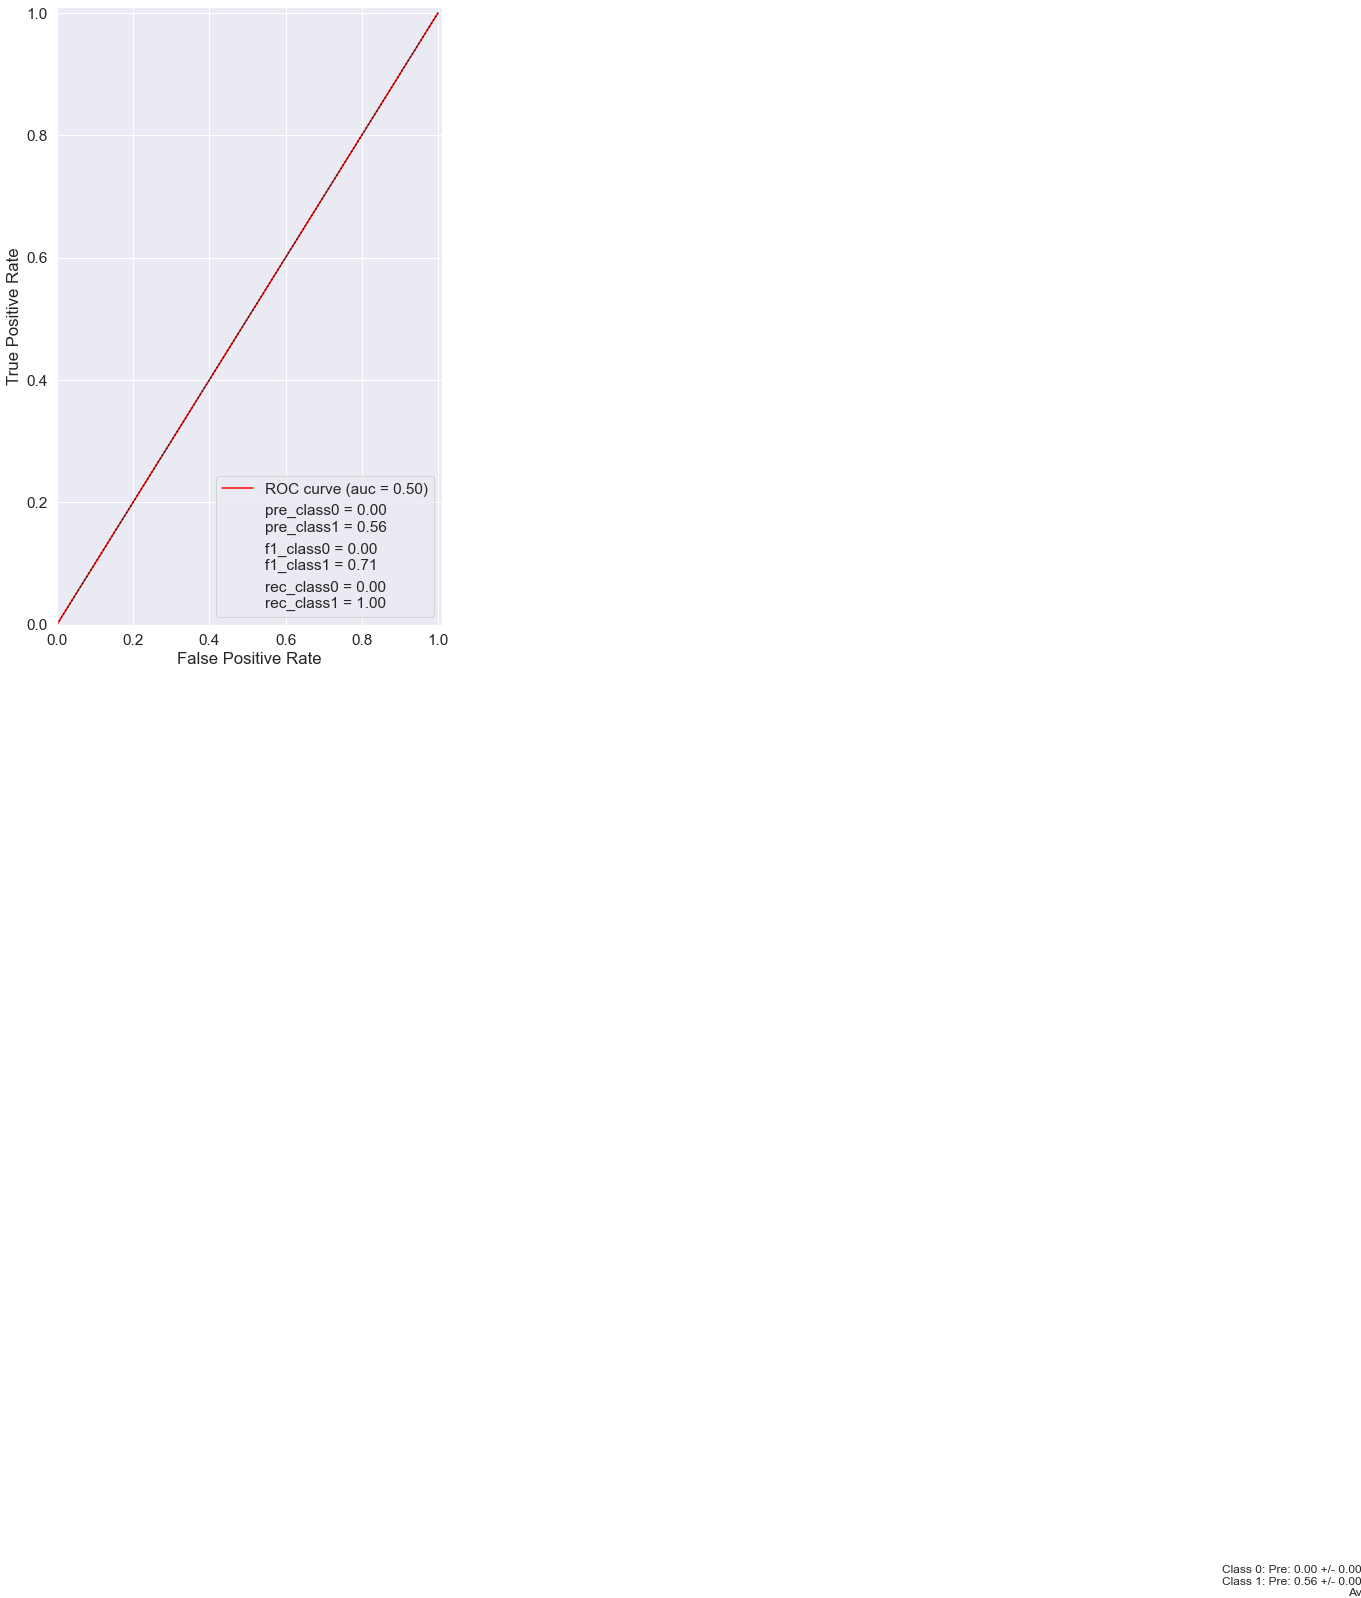


-----
Begin Gaussian Process
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again ma

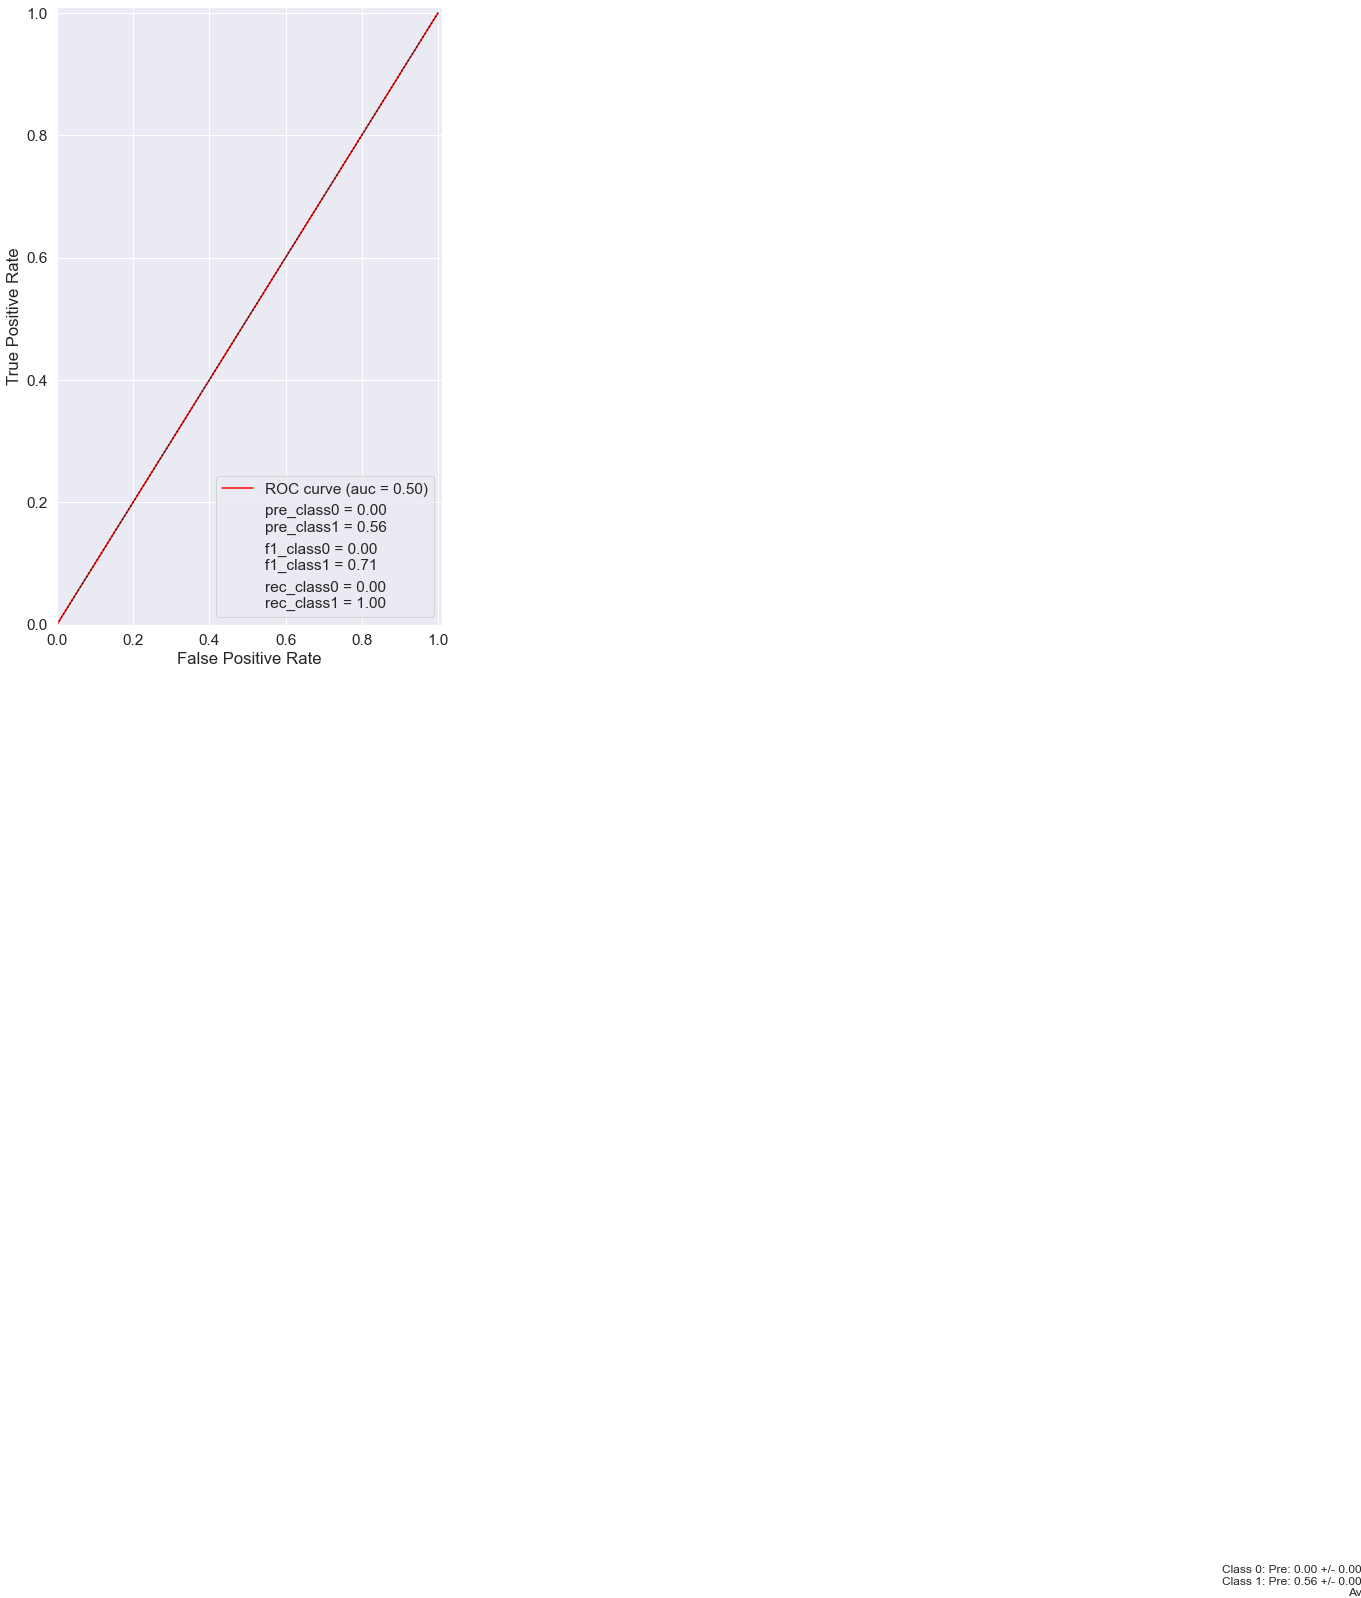


-----
Begin Decision Tree
-----

	Best parameters; {'max_depth': 4}
	0.7366 (+/-0.1226) for {'max_depth': 2}
	0.8191 (+/-0.0851) for {'max_depth': 3}
	0.8282 (+/-0.0896) for {'max_depth': 4}
	0.7822 (+/-0.1369) for {'max_depth': 5}
	0.7585 (+/-0.1282) for {'max_depth': 7}
	0.7545 (+/-0.1281) for {'max_depth': 10}

	----- Predicting using: Decision_Tree -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
	ROC analysis area under the curve: 0.5
	Confusion matrix (Decision_Tree):
[[4 0]
 [5 0]]


	score (Decision_Tree): 0.4444444444444444
	Imbalence reports:
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Prec

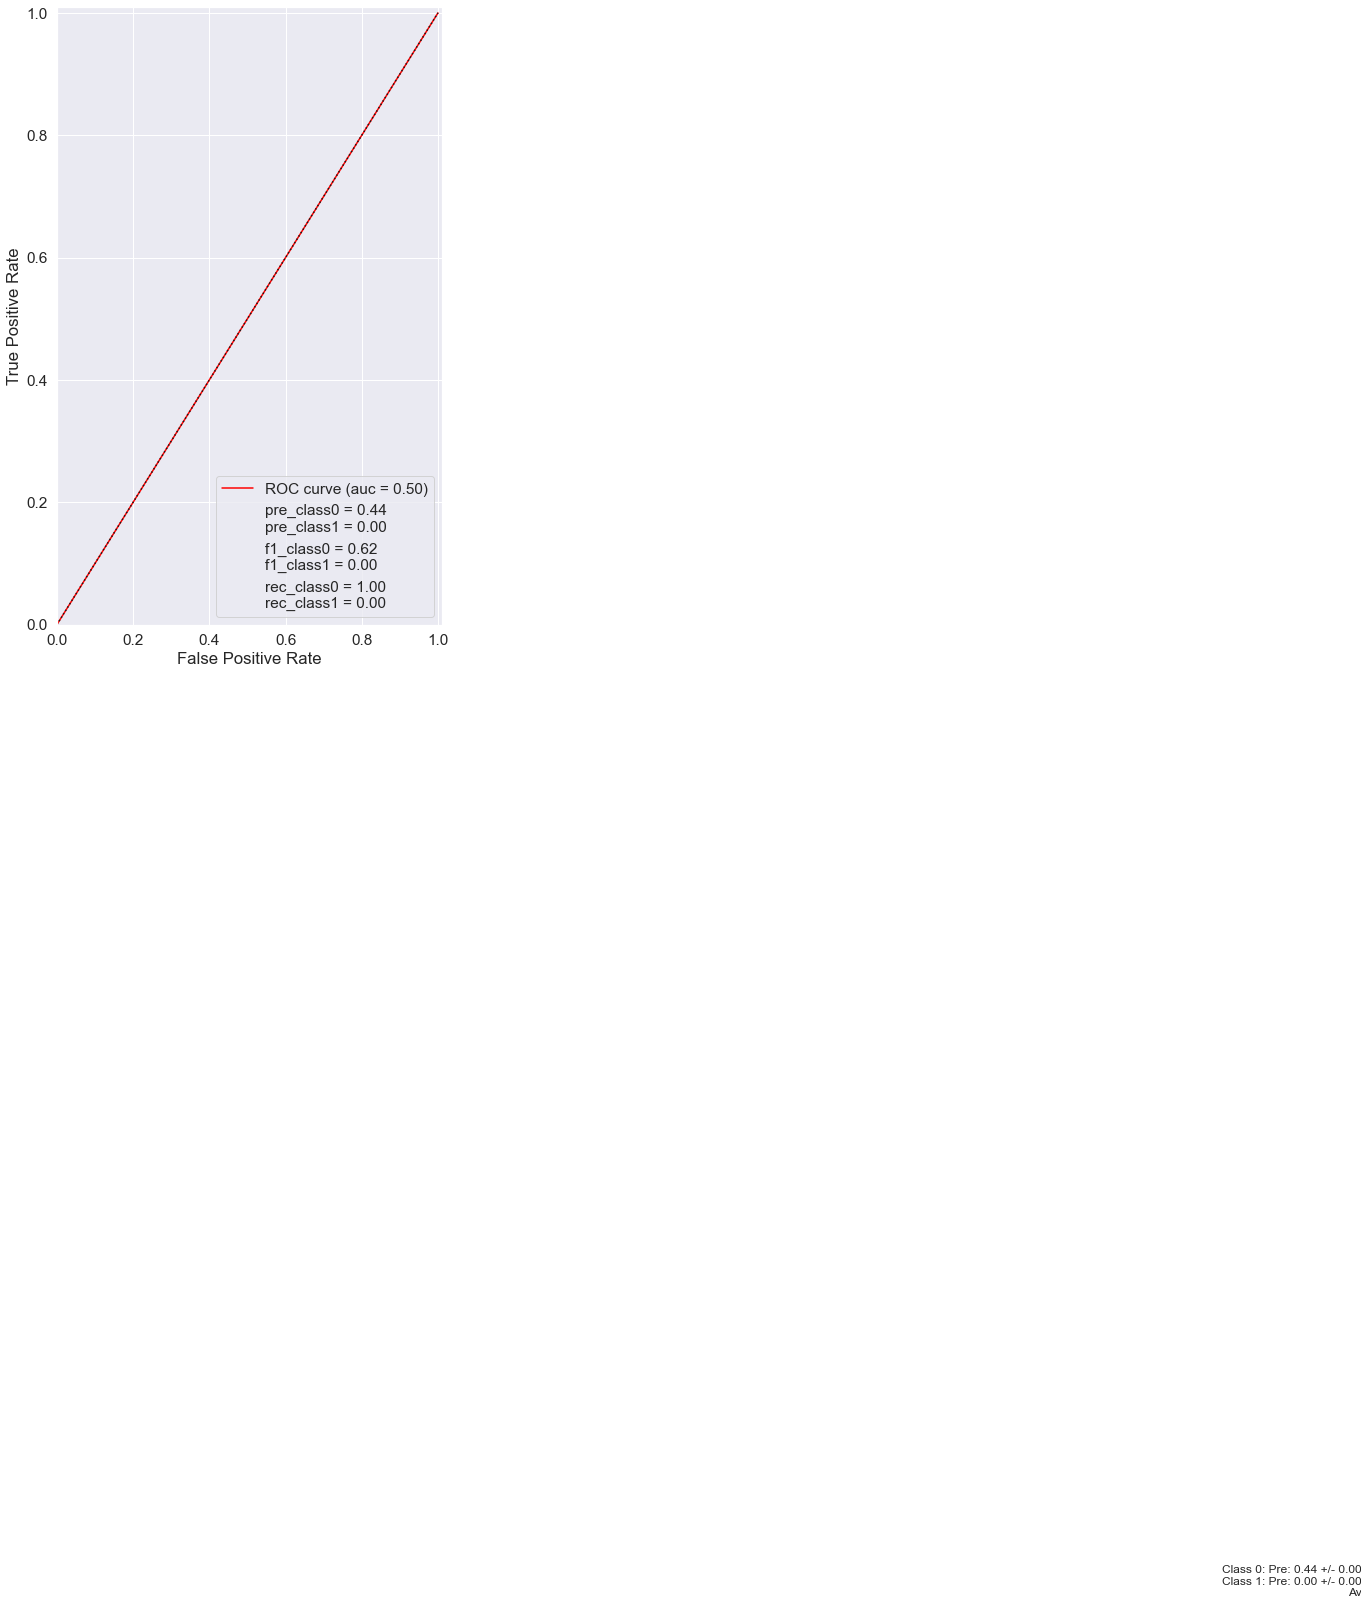


-----
Begin ExtraTreesClassifier
-----

	Best parameters; {'max_depth': 7, 'n_estimators': 50}
	0.8415 (+/-0.1161) for {'max_depth': 2, 'n_estimators': 10}
	0.8766 (+/-0.1143) for {'max_depth': 2, 'n_estimators': 20}
	0.8619 (+/-0.1222) for {'max_depth': 2, 'n_estimators': 50}
	0.8679 (+/-0.1115) for {'max_depth': 2, 'n_estimators': 100}
	0.8834 (+/-0.1126) for {'max_depth': 3, 'n_estimators': 10}
	0.9068 (+/-0.0776) for {'max_depth': 3, 'n_estimators': 20}
	0.8999 (+/-0.0885) for {'max_depth': 3, 'n_estimators': 50}
	0.8988 (+/-0.0877) for {'max_depth': 3, 'n_estimators': 100}
	0.8746 (+/-0.0989) for {'max_depth': 4, 'n_estimators': 10}
	0.8884 (+/-0.0781) for {'max_depth': 4, 'n_estimators': 20}
	0.9043 (+/-0.0827) for {'max_depth': 4, 'n_estimators': 50}
	0.8926 (+/-0.0913) for {'max_depth': 4, 'n_estimators': 100}
	0.8830 (+/-0.0728) for {'max_depth': 5, 'n_estimators': 10}
	0.9114 (+/-0.0832) for {'max_depth': 5, 'n_estimators': 20}
	0.9145 (+/-0.0795) for {'max_depth': 5, 'n_est

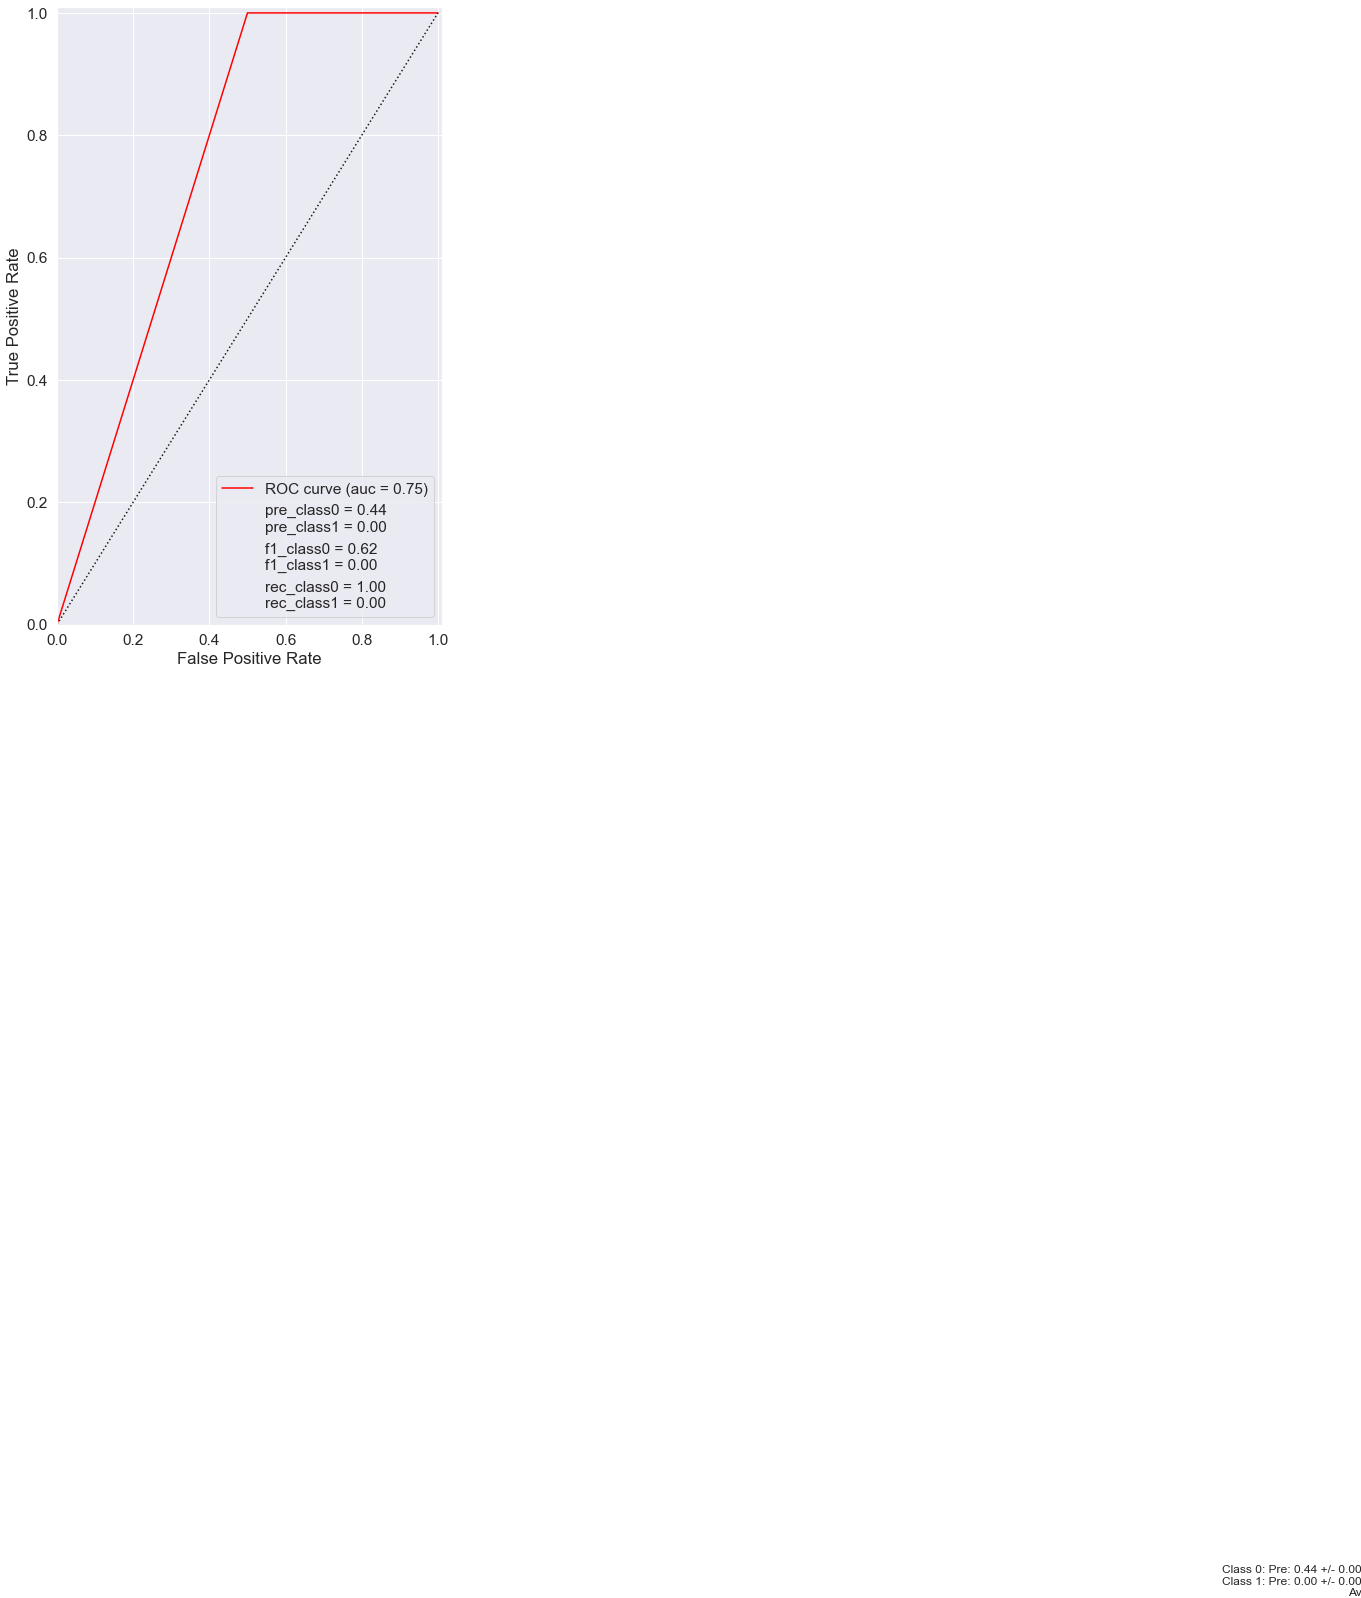


-----
Begin AdaBoost
-----

	Best parameters; {'n_estimators': 20}
	0.8614 (+/-0.1136) for {'n_estimators': 10}
	0.8868 (+/-0.0931) for {'n_estimators': 20}
	0.8837 (+/-0.0922) for {'n_estimators': 50}
	0.8679 (+/-0.0696) for {'n_estimators': 100}

	----- Predicting using: AdaBoost -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
	ROC analysis area under the curve: 0.375
	Confusion matrix (AdaBoost):
[[

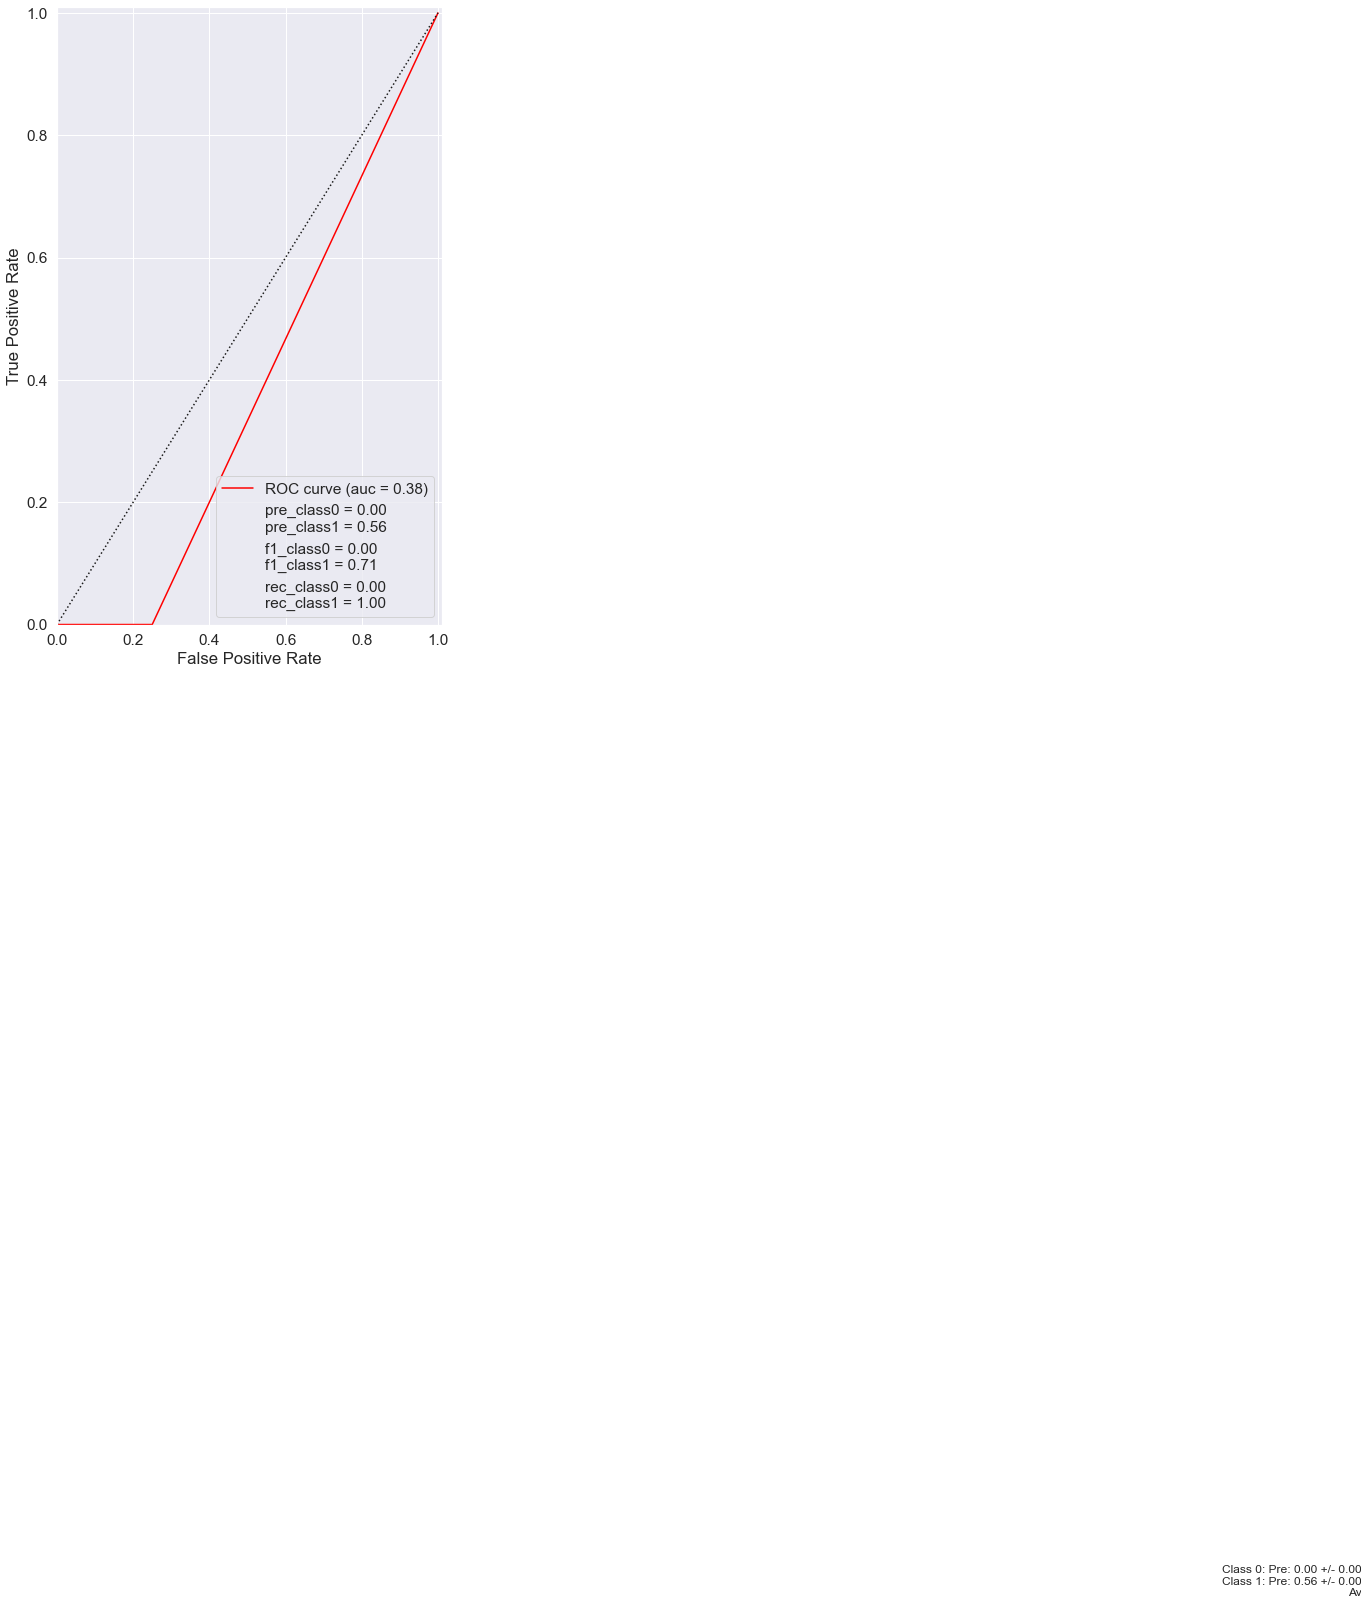


-----
Begin Logistic Regression
-----

	Best parameters; {'C': 0.5, 'penalty': 'l2'}
	0.8331 (+/-0.1327) for {'C': 0.05, 'penalty': 'l2'}
	0.8349 (+/-0.1323) for {'C': 0.1, 'penalty': 'l2'}
	0.8389 (+/-0.1335) for {'C': 0.25, 'penalty': 'l2'}
	0.8425 (+/-0.1326) for {'C': 0.5, 'penalty': 'l2'}
	0.8385 (+/-0.1307) for {'C': 1.0, 'penalty': 'l2'}
	0.8409 (+/-0.1177) for {'C': 1.25, 'penalty': 'l2'}

	----- Predicting using: Logistic_Regression -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

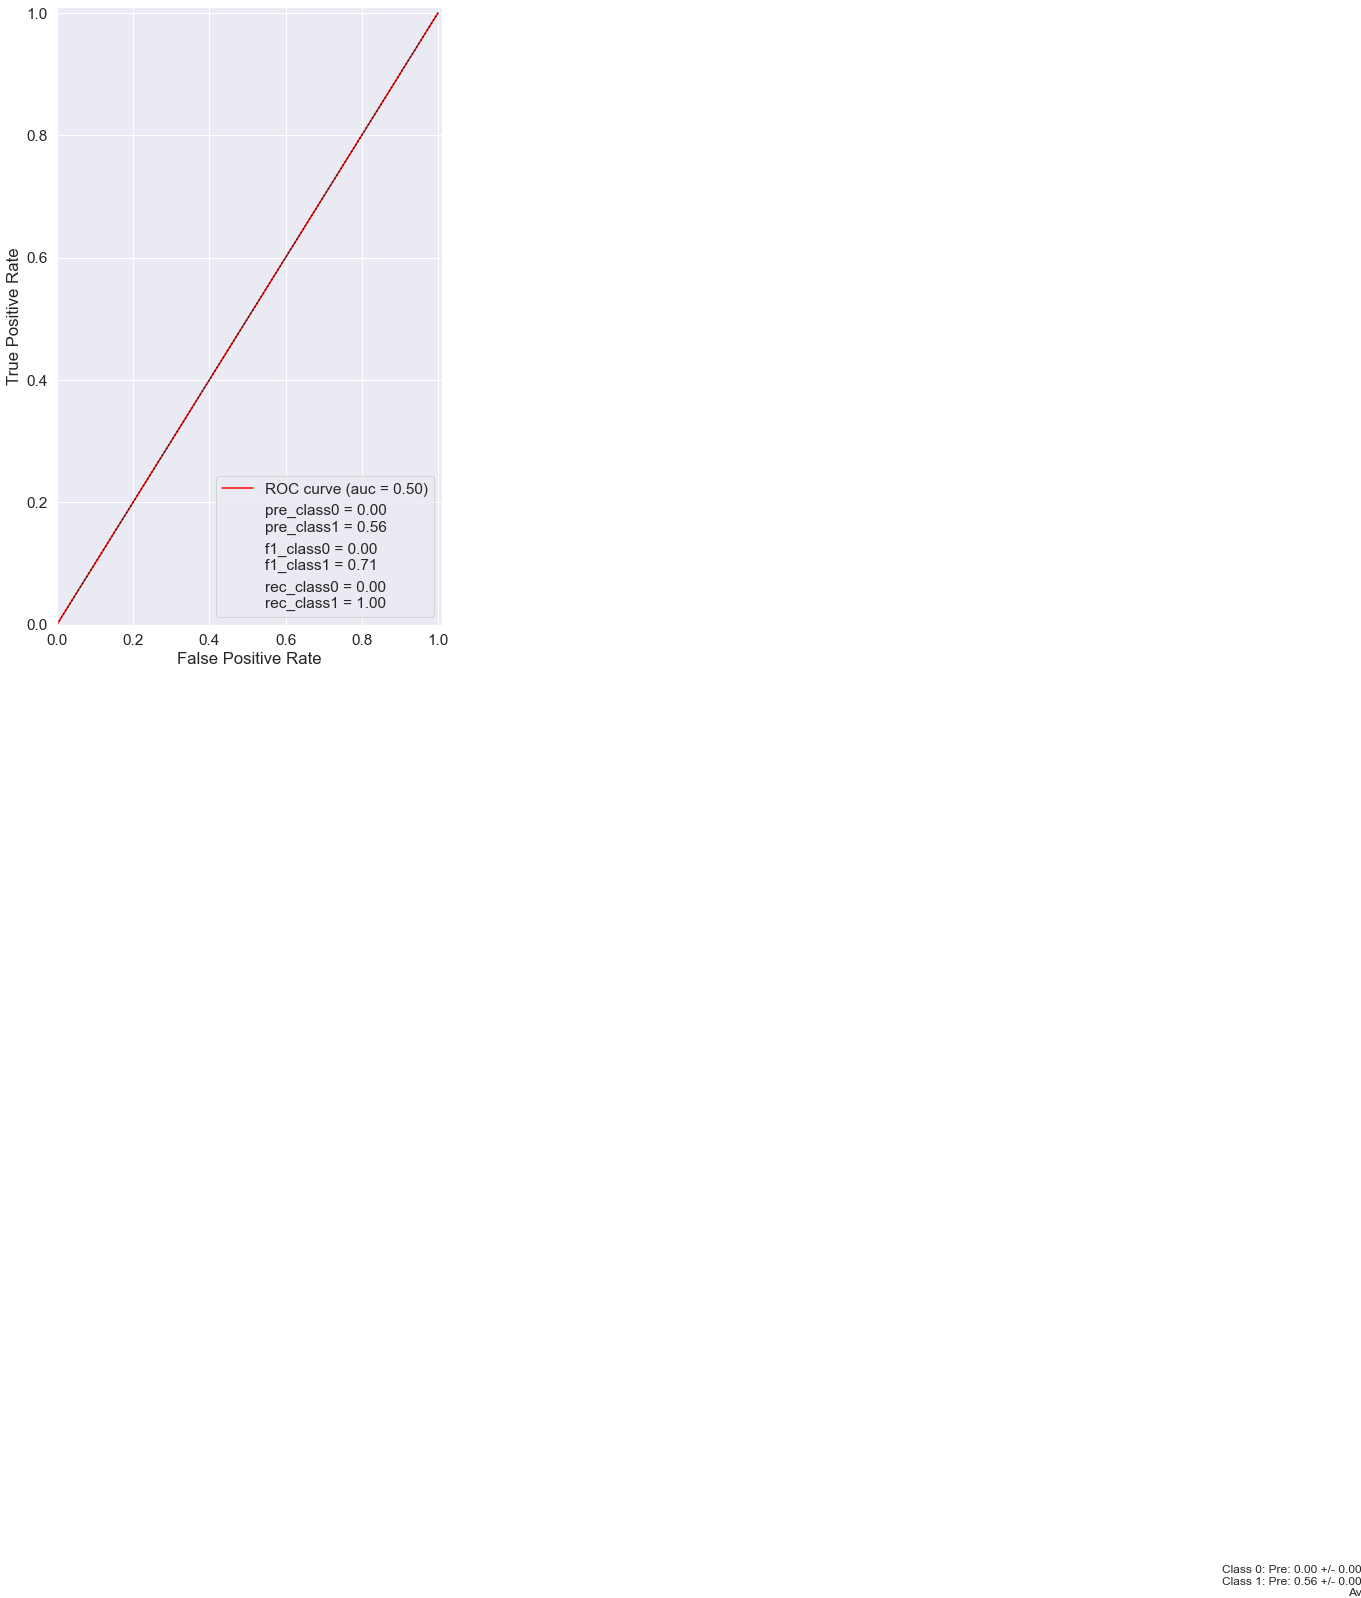

In [111]:
kfold_test_imbalenced_classifiers_with_optimization(Xtrain,Xtest, Ytrain , Ytest, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, cv=5, n_repeats=10,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

In [112]:
kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "Logistic Regression"]

In [113]:
directory_names = cwf.directory_names_from_classfier_names(kfold_clf_names)

In [114]:
# data = cwf.build_data_from_directory(directory_names[1],max_folds=1)


Nearest_Neighbors
-------------

Reading 0.csv
Saving plot to ddg_nearest_neighbors_morderd.png
['ddg_nearest_neighbors_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 0, 'fp': 4, 'fn': 0, 'tp': 5}
[[0 4]
 [0 5]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/Workflow/Modules/classification_metrics.py:221: RuntimeWarning: invalid value encountered in true_divide
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/Workflow/Modules/classification_metrics.py:221: RuntimeWarning: invalid value encountered in true_divide
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/Workflow/Modules/classification_metrics.py:185: RuntimeWarning: invalid value encountered in long_scalars
  return cm_d["tp"] / (cm_d["tp"] + cm_d["fp"])
/Users/matina/Desktop/Workflow/Modules/classification_metrics.py:221: RuntimeWarning: invalid value encountered in true_divide
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are 

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/Workflow/Modules/classification_metrics.py:185: RuntimeWarning: invalid value encountered in long_scalars
  return cm_d["tp"] / (cm_d["tp"] + cm_d["fp"])
/Users/matina/Desktop/Workflow/Modules/classification_metrics.py:221: RuntimeWarning: invalid value encountered in true_divide
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are 

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/Workflow/Modules/classification_metrics.py:221: RuntimeWarning: invalid value encountered in true_divide
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/Workflow/Modules/classification_metrics.py:221: RuntimeWarning: invalid value encountered in true_divide
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

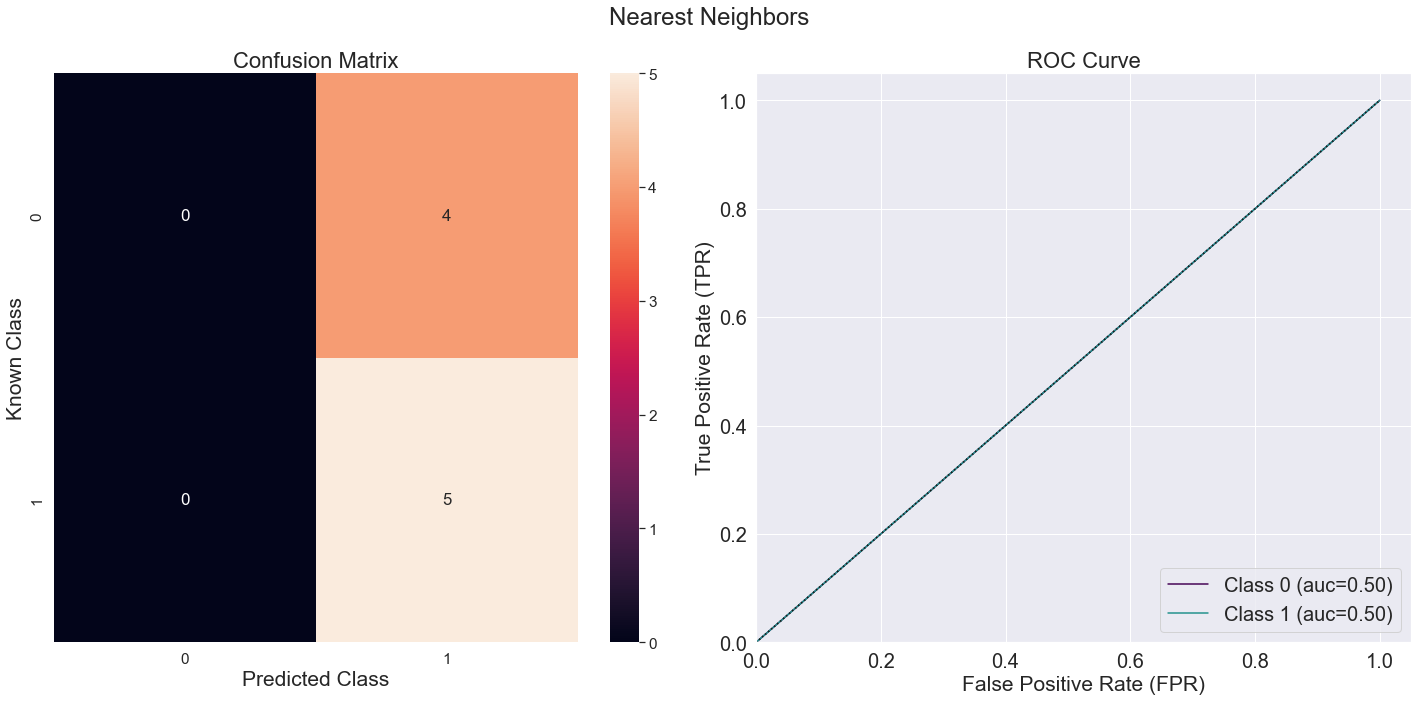

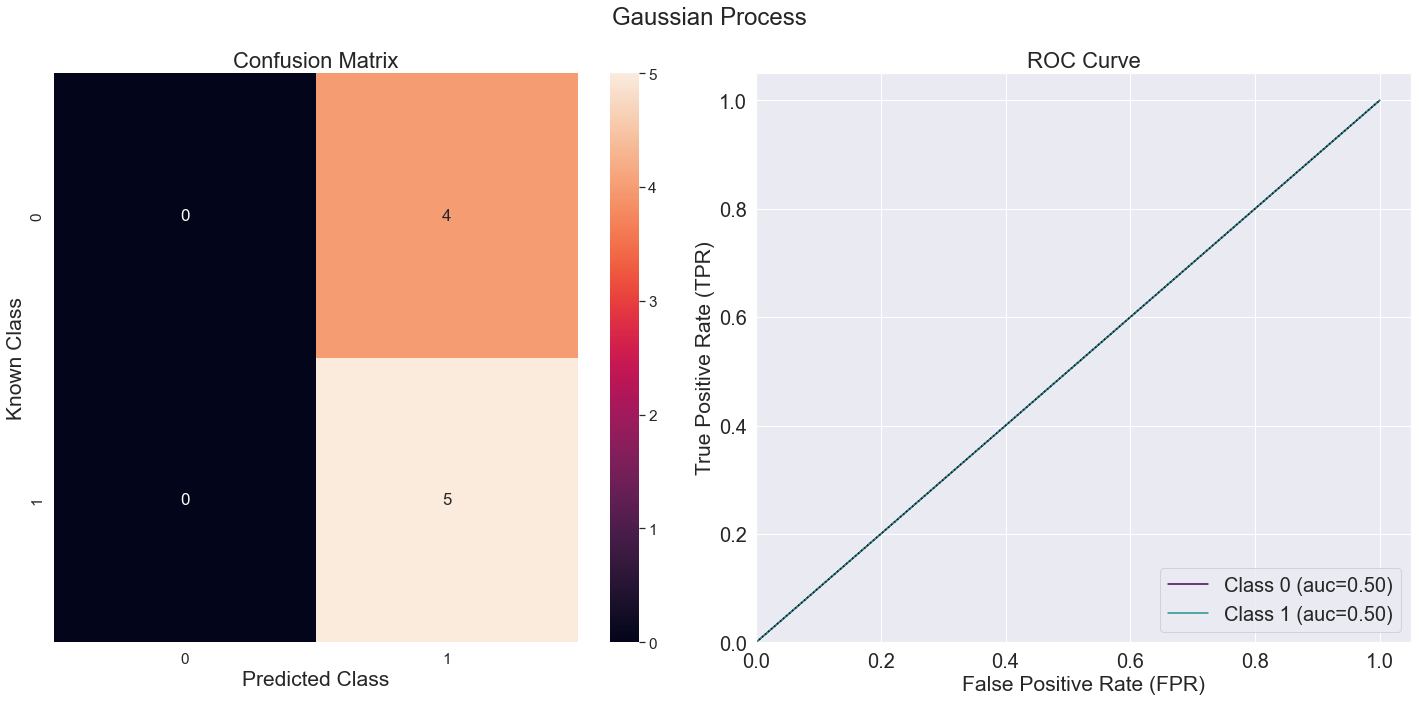

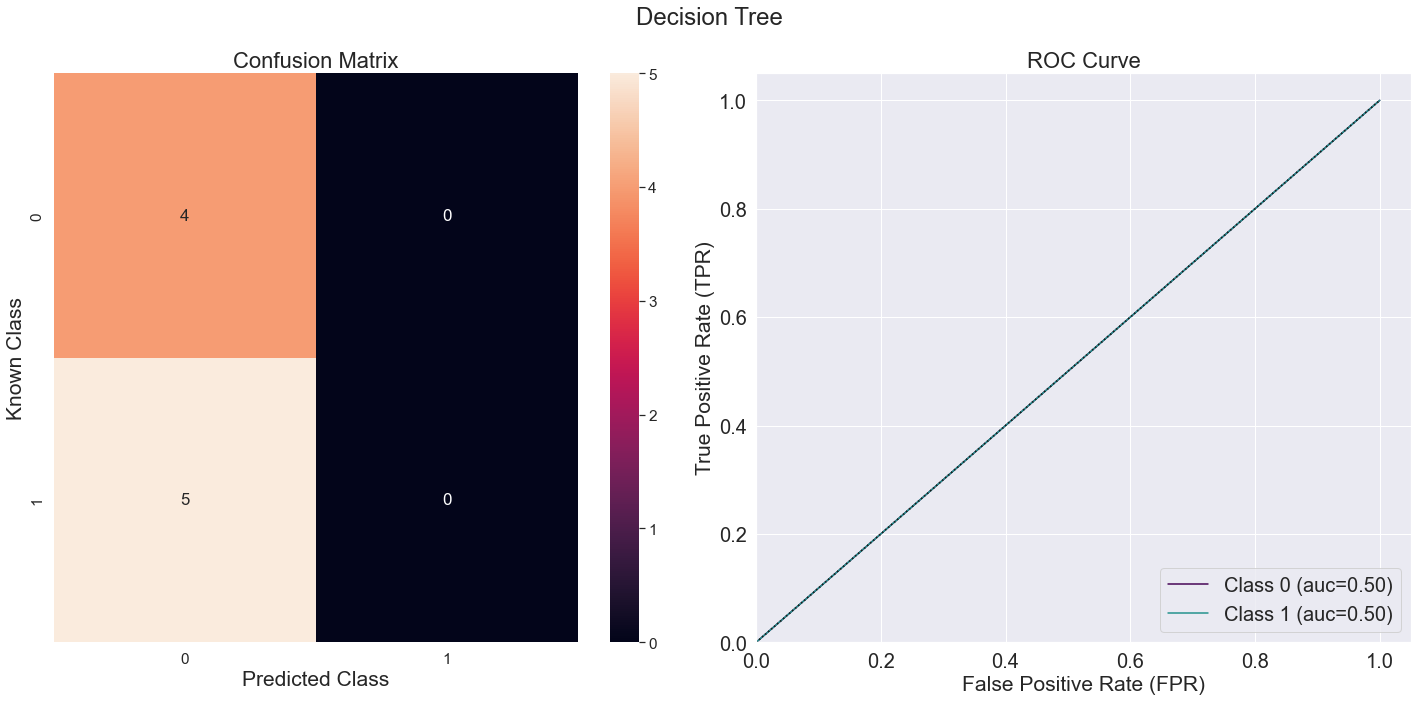

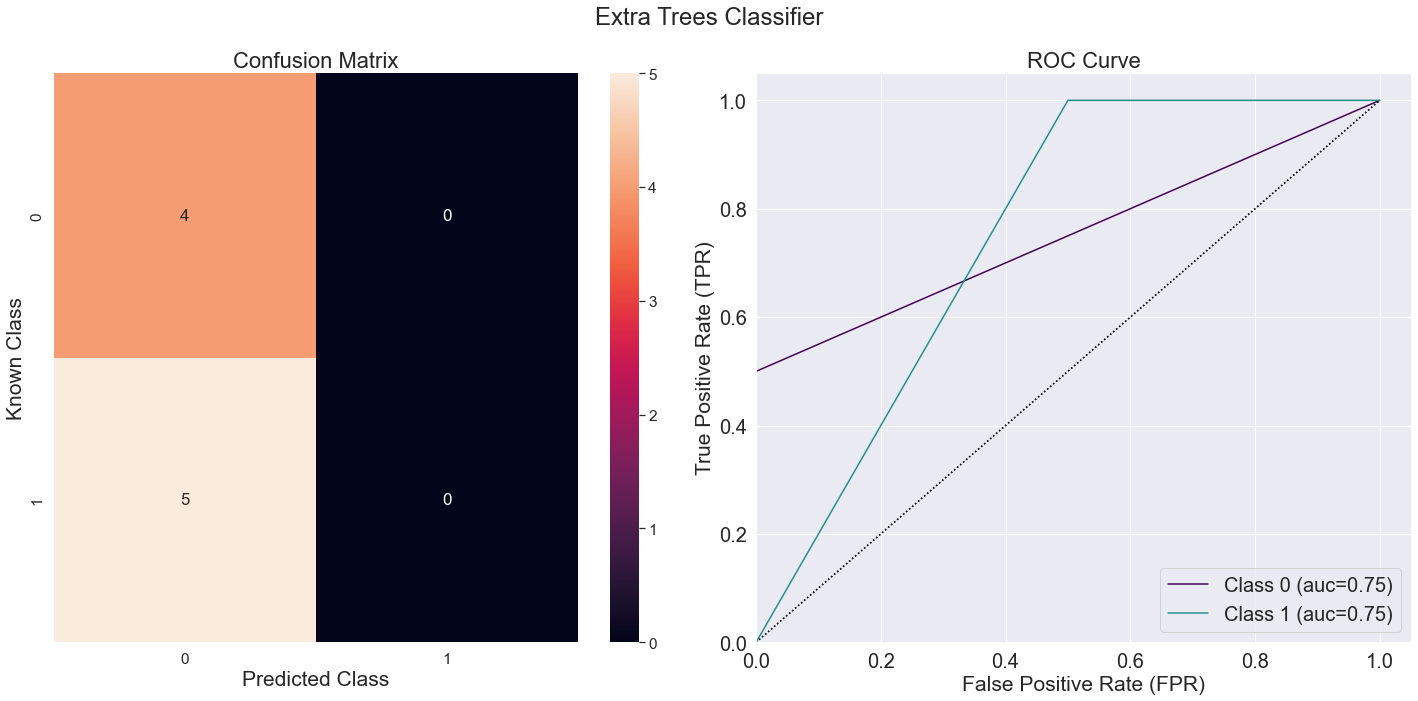

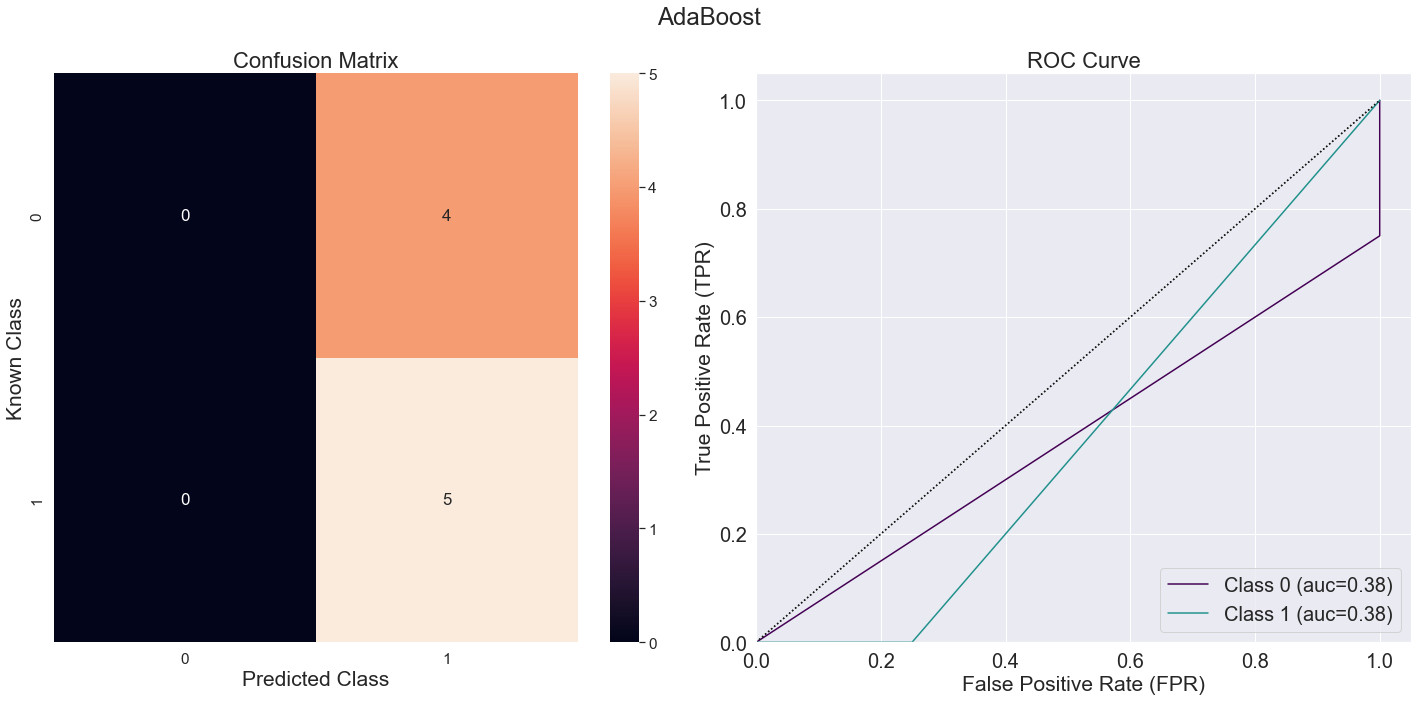

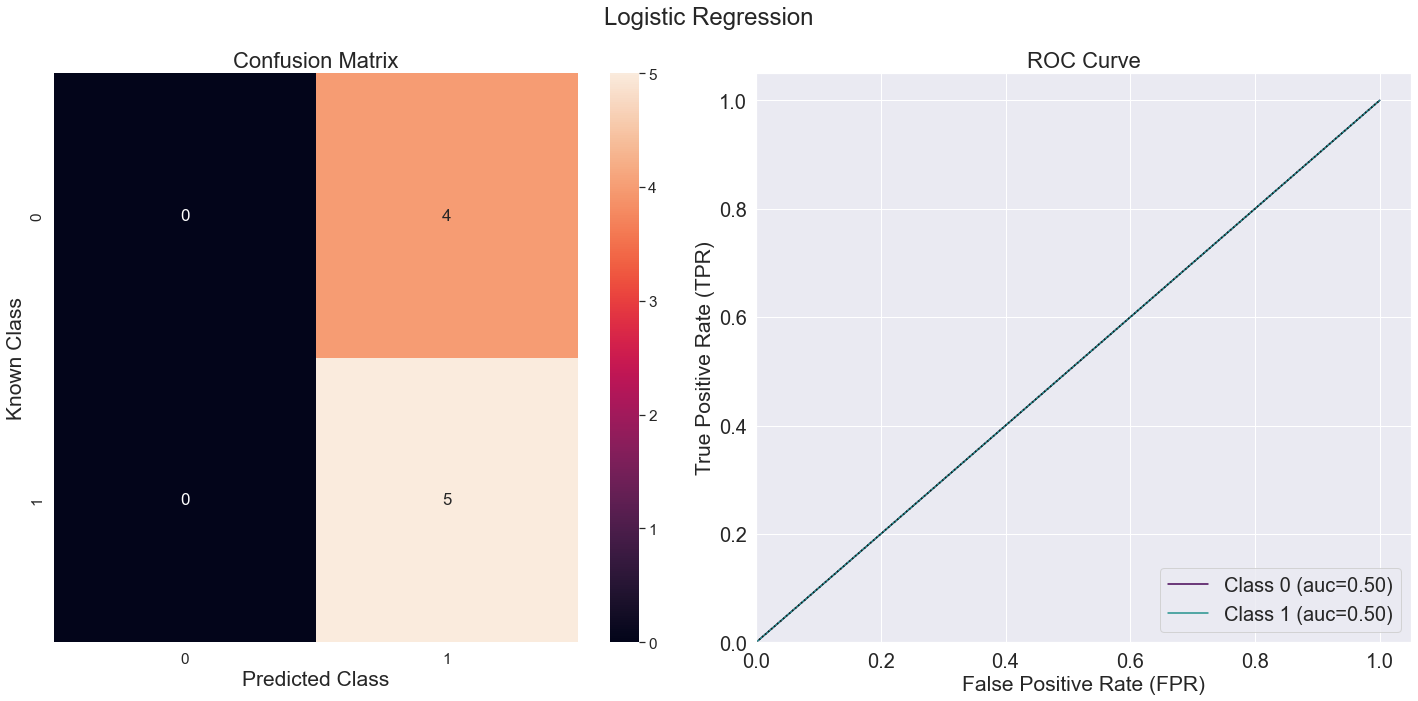

In [116]:
files_plt = []

kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Extra Trees Classifier", "AdaBoost",
         "Logistic Regression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=1)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_morderd.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [117]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_mordred.png")

Combining 6 images
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
New image will be W:1440 H:4320
Image 0 added at offset height 0
Image 1 added at offset height 720
Image 2 added at offset height 1440
Image 3 added at offset height 2160
Image 4 added at offset height 2880
Image 5 added at offset height 3600
